In [1]:
# Initialization

In [40]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
import pandas as pd
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

In [3]:
#import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.gpu_options.visible_device_list = "0"
#set_session(tf.Session(config=config))

In [41]:
LABELS = [ 'D00', 'D20', 'D40' ]
#['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

IMAGE_H, IMAGE_W = 416, 416 #416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 1 #16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [42]:
wt_path = 'yolov2.weights'                      
train_image_folder = 'RoadDamageDataset/Train_Images/'
train_annot_folder = 'RoadDamageDataset/Train_Annotations/'
valid_image_folder = 'RoadDamageDataset/Test_Images/'
valid_annot_folder = 'RoadDamageDataset/Test_Annotations/'

# Construct the network

In [6]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [7]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

# Load pretrained weights

**Load the weights originally provided by YOLO**

In [9]:
weight_reader = WeightReader(wt_path)

In [10]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

**Randomize weights of the last layer**

In [11]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

# Perform training

**Loss function**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [12]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

**Parse the annotations to construct train generator and validation generator**

In [13]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [14]:
def normalize(image):
    return image / 255.

In [15]:
train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('train_imgs', 'wb') as fp:
#    pickle.dump(train_imgs, fp)

### read saved pickle of parsed annotations
#with open ('train_imgs', 'rb') as fp:
#    train_imgs = pickle.load(fp)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('valid_imgs', 'wb') as fp:
#    pickle.dump(valid_imgs, fp)

### read saved pickle of parsed annotations
#with open ('valid_imgs', 'rb') as fp:
#    valid_imgs = pickle.load(fp)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

**Setup a few callbacks and start the training**

In [16]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_2_classes.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [17]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('~/logs1/')) if 'road_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs1/') + 'road_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer, metrics=['accuracy'])

#epochs           = 100, 
history = model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 25, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint, tensorboard], #, tensorboard
                    max_queue_size   = 3)

Epoch 1/25


 203/2859 [=>............................] - ETA: 10:34:58 - loss: 2.3969 - acc: 0.197 - ETA: 5:27:15 - loss: 2.5952 - acc: 0.188 - ETA: 3:44:12 - loss: 3.9195 - acc: 0.19 - ETA: 2:52:50 - loss: 3.3248 - acc: 0.18 - ETA: 2:21:53 - loss: 3.3529 - acc: 0.18 - ETA: 2:01:14 - loss: 3.2110 - acc: 0.19 - ETA: 1:46:35 - loss: 3.4982 - acc: 0.19 - ETA: 1:35:31 - loss: 3.5433 - acc: 0.19 - ETA: 1:26:59 - loss: 3.3320 - acc: 0.19 - ETA: 1:20:05 - loss: 3.4567 - acc: 0.19 - ETA: 1:14:30 - loss: 3.3325 - acc: 0.19 - ETA: 1:09:47 - loss: 3.1649 - acc: 0.19 - ETA: 1:05:47 - loss: 3.5466 - acc: 0.19 - ETA: 1:02:25 - loss: 3.4610 - acc: 0.19 - ETA: 59:27 - loss: 3.3123 - acc: 0.1896 - ETA: 56:54 - loss: 3.1881 - acc: 0.18 - ETA: 54:36 - loss: 3.1444 - acc: 0.19 - ETA: 52:36 - loss: 3.4539 - acc: 0.18 - ETA: 50:47 - loss: 3.3481 - acc: 0.18 - ETA: 49:08 - loss: 3.2686 - acc: 0.18 - ETA: 47:40 - loss: 3.4732 - acc: 0.18 - ETA: 46:19 - loss: 3.5589 - acc: 0.18 - ETA: 45:06 - loss: 3.4772 - acc: 0.18 - ET

 815/2859 [=======>......................] - ETA: 15:25 - loss: 2.4329 - acc: 0.08 - ETA: 15:25 - loss: 2.4344 - acc: 0.08 - ETA: 15:24 - loss: 2.4323 - acc: 0.08 - ETA: 15:24 - loss: 2.4308 - acc: 0.08 - ETA: 15:23 - loss: 2.4278 - acc: 0.08 - ETA: 15:23 - loss: 2.4282 - acc: 0.08 - ETA: 15:22 - loss: 2.4265 - acc: 0.08 - ETA: 15:22 - loss: 2.4257 - acc: 0.08 - ETA: 15:21 - loss: 2.4250 - acc: 0.08 - ETA: 15:21 - loss: 2.4233 - acc: 0.08 - ETA: 15:20 - loss: 2.4207 - acc: 0.08 - ETA: 15:20 - loss: 2.4184 - acc: 0.08 - ETA: 15:19 - loss: 2.4288 - acc: 0.08 - ETA: 15:19 - loss: 2.4267 - acc: 0.08 - ETA: 15:18 - loss: 2.4260 - acc: 0.08 - ETA: 15:18 - loss: 2.4261 - acc: 0.08 - ETA: 15:17 - loss: 2.4240 - acc: 0.08 - ETA: 15:17 - loss: 2.4228 - acc: 0.08 - ETA: 15:16 - loss: 2.4229 - acc: 0.08 - ETA: 15:16 - loss: 2.4206 - acc: 0.08 - ETA: 15:15 - loss: 2.4187 - acc: 0.08 - ETA: 15:15 - loss: 2.4220 - acc: 0.08 - ETA: 15:14 - loss: 2.4206 - acc: 0.08 - ETA: 15:14 - loss: 2.4203 - acc: 0.

1019/2859 [=========>....................] - ETA: 13:50 - loss: 2.3537 - acc: 0.07 - ETA: 13:50 - loss: 2.3526 - acc: 0.07 - ETA: 13:49 - loss: 2.3515 - acc: 0.07 - ETA: 13:49 - loss: 2.3503 - acc: 0.07 - ETA: 13:48 - loss: 2.3505 - acc: 0.07 - ETA: 13:48 - loss: 2.3597 - acc: 0.07 - ETA: 13:47 - loss: 2.3591 - acc: 0.07 - ETA: 13:47 - loss: 2.3575 - acc: 0.07 - ETA: 13:47 - loss: 2.3552 - acc: 0.07 - ETA: 13:46 - loss: 2.3529 - acc: 0.07 - ETA: 13:46 - loss: 2.3511 - acc: 0.07 - ETA: 13:45 - loss: 2.3537 - acc: 0.07 - ETA: 13:45 - loss: 2.3555 - acc: 0.07 - ETA: 13:44 - loss: 2.3545 - acc: 0.07 - ETA: 13:44 - loss: 2.3537 - acc: 0.07 - ETA: 13:43 - loss: 2.3517 - acc: 0.07 - ETA: 13:43 - loss: 2.3516 - acc: 0.07 - ETA: 13:43 - loss: 2.3501 - acc: 0.07 - ETA: 13:42 - loss: 2.3489 - acc: 0.07 - ETA: 13:42 - loss: 2.3471 - acc: 0.07 - ETA: 13:41 - loss: 2.3461 - acc: 0.07 - ETA: 13:41 - loss: 2.3447 - acc: 0.07 - ETA: 13:40 - loss: 2.3430 - acc: 0.07 - ETA: 13:40 - loss: 2.3419 - acc: 0.

1223/2859 [===========>..................] - ETA: 12:21 - loss: 2.2842 - acc: 0.06 - ETA: 12:21 - loss: 2.2832 - acc: 0.06 - ETA: 12:21 - loss: 2.2819 - acc: 0.06 - ETA: 12:20 - loss: 2.2813 - acc: 0.06 - ETA: 12:20 - loss: 2.2800 - acc: 0.06 - ETA: 12:19 - loss: 2.2781 - acc: 0.06 - ETA: 12:19 - loss: 2.2776 - acc: 0.06 - ETA: 12:19 - loss: 2.2764 - acc: 0.06 - ETA: 12:18 - loss: 2.2751 - acc: 0.06 - ETA: 12:18 - loss: 2.2737 - acc: 0.06 - ETA: 12:17 - loss: 2.2737 - acc: 0.06 - ETA: 12:17 - loss: 2.2727 - acc: 0.06 - ETA: 12:16 - loss: 2.2743 - acc: 0.06 - ETA: 12:16 - loss: 2.2727 - acc: 0.06 - ETA: 12:16 - loss: 2.2715 - acc: 0.06 - ETA: 12:15 - loss: 2.2778 - acc: 0.06 - ETA: 12:15 - loss: 2.2772 - acc: 0.06 - ETA: 12:14 - loss: 2.2766 - acc: 0.06 - ETA: 12:14 - loss: 2.2766 - acc: 0.06 - ETA: 12:13 - loss: 2.2762 - acc: 0.06 - ETA: 12:13 - loss: 2.2773 - acc: 0.06 - ETA: 12:13 - loss: 2.2775 - acc: 0.06 - ETA: 12:12 - loss: 2.2763 - acc: 0.06 - ETA: 12:12 - loss: 2.2754 - acc: 0.

1427/2859 [=============>................] - ETA: 10:56 - loss: 2.2208 - acc: 0.05 - ETA: 10:55 - loss: 2.2194 - acc: 0.05 - ETA: 10:55 - loss: 2.2190 - acc: 0.05 - ETA: 10:55 - loss: 2.2181 - acc: 0.05 - ETA: 10:54 - loss: 2.2176 - acc: 0.05 - ETA: 10:54 - loss: 2.2174 - acc: 0.05 - ETA: 10:53 - loss: 2.2183 - acc: 0.05 - ETA: 10:53 - loss: 2.2172 - acc: 0.05 - ETA: 10:53 - loss: 2.2163 - acc: 0.05 - ETA: 10:52 - loss: 2.2167 - acc: 0.05 - ETA: 10:52 - loss: 2.2174 - acc: 0.05 - ETA: 10:51 - loss: 2.2224 - acc: 0.05 - ETA: 10:51 - loss: 2.2211 - acc: 0.05 - ETA: 10:50 - loss: 2.2209 - acc: 0.05 - ETA: 10:50 - loss: 2.2232 - acc: 0.05 - ETA: 10:50 - loss: 2.2235 - acc: 0.05 - ETA: 10:49 - loss: 2.2228 - acc: 0.05 - ETA: 10:49 - loss: 2.2259 - acc: 0.05 - ETA: 10:48 - loss: 2.2269 - acc: 0.05 - ETA: 10:48 - loss: 2.2257 - acc: 0.05 - ETA: 10:48 - loss: 2.2242 - acc: 0.05 - ETA: 10:47 - loss: 2.2225 - acc: 0.05 - ETA: 10:47 - loss: 2.2214 - acc: 0.05 - ETA: 10:46 - loss: 2.2209 - acc: 0.

1631/2859 [================>.............] - ETA: 9:32 - loss: 2.1984 - acc: 0.047 - ETA: 9:31 - loss: 2.1982 - acc: 0.047 - ETA: 9:31 - loss: 2.1977 - acc: 0.047 - ETA: 9:30 - loss: 2.1967 - acc: 0.047 - ETA: 9:30 - loss: 2.1960 - acc: 0.047 - ETA: 9:29 - loss: 2.1948 - acc: 0.047 - ETA: 9:29 - loss: 2.1947 - acc: 0.047 - ETA: 9:29 - loss: 2.1939 - acc: 0.047 - ETA: 9:28 - loss: 2.1931 - acc: 0.047 - ETA: 9:28 - loss: 2.1922 - acc: 0.047 - ETA: 9:27 - loss: 2.1916 - acc: 0.046 - ETA: 9:27 - loss: 2.1909 - acc: 0.046 - ETA: 9:27 - loss: 2.1897 - acc: 0.046 - ETA: 9:26 - loss: 2.1912 - acc: 0.046 - ETA: 9:26 - loss: 2.1901 - acc: 0.046 - ETA: 9:25 - loss: 2.1901 - acc: 0.046 - ETA: 9:25 - loss: 2.1895 - acc: 0.046 - ETA: 9:25 - loss: 2.1883 - acc: 0.046 - ETA: 9:24 - loss: 2.1876 - acc: 0.046 - ETA: 9:24 - loss: 2.1890 - acc: 0.046 - ETA: 9:23 - loss: 2.1883 - acc: 0.046 - ETA: 9:23 - loss: 2.1873 - acc: 0.046 - ETA: 9:23 - loss: 2.1873 - acc: 0.046 - ETA: 9:22 - loss: 2.1864 - acc: 0.0

1835/2859 [==================>...........] - ETA: 8:08 - loss: 2.1716 - acc: 0.041 - ETA: 8:08 - loss: 2.1709 - acc: 0.041 - ETA: 8:07 - loss: 2.1703 - acc: 0.041 - ETA: 8:07 - loss: 2.1693 - acc: 0.041 - ETA: 8:07 - loss: 2.1694 - acc: 0.041 - ETA: 8:06 - loss: 2.1688 - acc: 0.041 - ETA: 8:06 - loss: 2.1686 - acc: 0.041 - ETA: 8:05 - loss: 2.1688 - acc: 0.041 - ETA: 8:05 - loss: 2.1680 - acc: 0.041 - ETA: 8:05 - loss: 2.1673 - acc: 0.041 - ETA: 8:04 - loss: 2.1664 - acc: 0.041 - ETA: 8:04 - loss: 2.1660 - acc: 0.041 - ETA: 8:03 - loss: 2.1651 - acc: 0.041 - ETA: 8:03 - loss: 2.1655 - acc: 0.041 - ETA: 8:03 - loss: 2.1665 - acc: 0.041 - ETA: 8:02 - loss: 2.1655 - acc: 0.041 - ETA: 8:02 - loss: 2.1644 - acc: 0.041 - ETA: 8:01 - loss: 2.1633 - acc: 0.041 - ETA: 8:01 - loss: 2.1622 - acc: 0.041 - ETA: 8:01 - loss: 2.1614 - acc: 0.041 - ETA: 8:00 - loss: 2.1605 - acc: 0.041 - ETA: 8:00 - loss: 2.1598 - acc: 0.041 - ETA: 7:59 - loss: 2.1591 - acc: 0.041 - ETA: 7:59 - loss: 2.1583 - acc: 0.0

2039/2859 [====================>.........] - ETA: 6:46 - loss: 2.1237 - acc: 0.037 - ETA: 6:46 - loss: 2.1230 - acc: 0.037 - ETA: 6:45 - loss: 2.1221 - acc: 0.037 - ETA: 6:45 - loss: 2.1212 - acc: 0.037 - ETA: 6:44 - loss: 2.1221 - acc: 0.037 - ETA: 6:44 - loss: 2.1224 - acc: 0.037 - ETA: 6:44 - loss: 2.1223 - acc: 0.037 - ETA: 6:43 - loss: 2.1215 - acc: 0.037 - ETA: 6:43 - loss: 2.1221 - acc: 0.037 - ETA: 6:42 - loss: 2.1219 - acc: 0.037 - ETA: 6:42 - loss: 2.1219 - acc: 0.037 - ETA: 6:42 - loss: 2.1213 - acc: 0.037 - ETA: 6:41 - loss: 2.1207 - acc: 0.037 - ETA: 6:41 - loss: 2.1200 - acc: 0.037 - ETA: 6:40 - loss: 2.1193 - acc: 0.037 - ETA: 6:40 - loss: 2.1194 - acc: 0.037 - ETA: 6:40 - loss: 2.1184 - acc: 0.037 - ETA: 6:39 - loss: 2.1175 - acc: 0.037 - ETA: 6:39 - loss: 2.1170 - acc: 0.036 - ETA: 6:38 - loss: 2.1171 - acc: 0.036 - ETA: 6:38 - loss: 2.1166 - acc: 0.036 - ETA: 6:38 - loss: 2.1159 - acc: 0.036 - ETA: 6:37 - loss: 2.1153 - acc: 0.036 - ETA: 6:37 - loss: 2.1146 - acc: 0.0

2243/2859 [======================>.......] - ETA: 5:24 - loss: 2.0905 - acc: 0.033 - ETA: 5:24 - loss: 2.0912 - acc: 0.033 - ETA: 5:23 - loss: 2.0908 - acc: 0.033 - ETA: 5:23 - loss: 2.0903 - acc: 0.033 - ETA: 5:23 - loss: 2.0896 - acc: 0.033 - ETA: 5:22 - loss: 2.0896 - acc: 0.033 - ETA: 5:22 - loss: 2.0892 - acc: 0.033 - ETA: 5:21 - loss: 2.0884 - acc: 0.033 - ETA: 5:21 - loss: 2.0878 - acc: 0.033 - ETA: 5:21 - loss: 2.0881 - acc: 0.033 - ETA: 5:20 - loss: 2.0874 - acc: 0.033 - ETA: 5:20 - loss: 2.0884 - acc: 0.033 - ETA: 5:19 - loss: 2.0878 - acc: 0.033 - ETA: 5:19 - loss: 2.0870 - acc: 0.033 - ETA: 5:19 - loss: 2.0878 - acc: 0.033 - ETA: 5:18 - loss: 2.0875 - acc: 0.033 - ETA: 5:18 - loss: 2.0873 - acc: 0.033 - ETA: 5:17 - loss: 2.0866 - acc: 0.033 - ETA: 5:17 - loss: 2.0859 - acc: 0.033 - ETA: 5:17 - loss: 2.0854 - acc: 0.033 - ETA: 5:16 - loss: 2.0847 - acc: 0.033 - ETA: 5:16 - loss: 2.0844 - acc: 0.033 - ETA: 5:15 - loss: 2.0837 - acc: 0.033 - ETA: 5:15 - loss: 2.0836 - acc: 0.0

2447/2859 [========================>.....] - ETA: 4:03 - loss: 2.0529 - acc: 0.031 - ETA: 4:02 - loss: 2.0522 - acc: 0.031 - ETA: 4:02 - loss: 2.0519 - acc: 0.031 - ETA: 4:02 - loss: 2.0512 - acc: 0.030 - ETA: 4:01 - loss: 2.0511 - acc: 0.030 - ETA: 4:01 - loss: 2.0514 - acc: 0.030 - ETA: 4:00 - loss: 2.0514 - acc: 0.030 - ETA: 4:00 - loss: 2.0509 - acc: 0.030 - ETA: 4:00 - loss: 2.0523 - acc: 0.030 - ETA: 3:59 - loss: 2.0516 - acc: 0.030 - ETA: 3:59 - loss: 2.0516 - acc: 0.030 - ETA: 3:58 - loss: 2.0510 - acc: 0.030 - ETA: 3:58 - loss: 2.0502 - acc: 0.030 - ETA: 3:58 - loss: 2.0495 - acc: 0.030 - ETA: 3:57 - loss: 2.0496 - acc: 0.030 - ETA: 3:57 - loss: 2.0490 - acc: 0.030 - ETA: 3:56 - loss: 2.0493 - acc: 0.030 - ETA: 3:56 - loss: 2.0485 - acc: 0.030 - ETA: 3:56 - loss: 2.0479 - acc: 0.030 - ETA: 3:55 - loss: 2.0473 - acc: 0.030 - ETA: 3:55 - loss: 2.0467 - acc: 0.030 - ETA: 3:55 - loss: 2.0485 - acc: 0.030 - ETA: 3:54 - loss: 2.0487 - acc: 0.030 - ETA: 3:54 - loss: 2.0486 - acc: 0.0

2651/2859 [==========================>...] - ETA: 2:42 - loss: 2.0138 - acc: 0.028 - ETA: 2:41 - loss: 2.0137 - acc: 0.028 - ETA: 2:41 - loss: 2.0147 - acc: 0.028 - ETA: 2:41 - loss: 2.0143 - acc: 0.028 - ETA: 2:40 - loss: 2.0136 - acc: 0.028 - ETA: 2:40 - loss: 2.0129 - acc: 0.028 - ETA: 2:40 - loss: 2.0141 - acc: 0.028 - ETA: 2:39 - loss: 2.0146 - acc: 0.028 - ETA: 2:39 - loss: 2.0143 - acc: 0.028 - ETA: 2:38 - loss: 2.0138 - acc: 0.028 - ETA: 2:38 - loss: 2.0146 - acc: 0.028 - ETA: 2:38 - loss: 2.0151 - acc: 0.028 - ETA: 2:37 - loss: 2.0158 - acc: 0.028 - ETA: 2:37 - loss: 2.0152 - acc: 0.028 - ETA: 2:36 - loss: 2.0156 - acc: 0.028 - ETA: 2:36 - loss: 2.0151 - acc: 0.028 - ETA: 2:36 - loss: 2.0148 - acc: 0.028 - ETA: 2:35 - loss: 2.0154 - acc: 0.028 - ETA: 2:35 - loss: 2.0150 - acc: 0.028 - ETA: 2:34 - loss: 2.0152 - acc: 0.028 - ETA: 2:34 - loss: 2.0154 - acc: 0.028 - ETA: 2:34 - loss: 2.0150 - acc: 0.028 - ETA: 2:33 - loss: 2.0144 - acc: 0.028 - ETA: 2:33 - loss: 2.0137 - acc: 0.0

2859/2859 [==============================] - ETA: 1:21 - loss: 2.0154 - acc: 0.026 - ETA: 1:21 - loss: 2.0149 - acc: 0.026 - ETA: 1:20 - loss: 2.0145 - acc: 0.026 - ETA: 1:20 - loss: 2.0141 - acc: 0.026 - ETA: 1:20 - loss: 2.0136 - acc: 0.026 - ETA: 1:19 - loss: 2.0141 - acc: 0.026 - ETA: 1:19 - loss: 2.0140 - acc: 0.026 - ETA: 1:18 - loss: 2.0156 - acc: 0.026 - ETA: 1:18 - loss: 2.0150 - acc: 0.026 - ETA: 1:18 - loss: 2.0143 - acc: 0.026 - ETA: 1:17 - loss: 2.0150 - acc: 0.026 - ETA: 1:17 - loss: 2.0149 - acc: 0.026 - ETA: 1:16 - loss: 2.0153 - acc: 0.026 - ETA: 1:16 - loss: 2.0147 - acc: 0.026 - ETA: 1:16 - loss: 2.0141 - acc: 0.026 - ETA: 1:15 - loss: 2.0142 - acc: 0.026 - ETA: 1:15 - loss: 2.0147 - acc: 0.026 - ETA: 1:14 - loss: 2.0150 - acc: 0.026 - ETA: 1:14 - loss: 2.0150 - acc: 0.026 - ETA: 1:14 - loss: 2.0148 - acc: 0.026 - ETA: 1:13 - loss: 2.0142 - acc: 0.026 - ETA: 1:13 - loss: 2.0138 - acc: 0.026 - ETA: 1:12 - loss: 2.0133 - acc: 0.026 - ETA: 1:12 - loss: 2.0128 - acc: 0.0

 202/2859 [=>............................] - ETA: 17:54 - loss: 0.3383 - acc: 0.00 - ETA: 18:28 - loss: 0.9784 - acc: 0.00 - ETA: 18:24 - loss: 0.8109 - acc: 0.00 - ETA: 18:21 - loss: 0.6522 - acc: 0.00 - ETA: 18:29 - loss: 0.6823 - acc: 0.00 - ETA: 18:26 - loss: 0.6504 - acc: 0.00 - ETA: 18:24 - loss: 0.6045 - acc: 0.00 - ETA: 18:28 - loss: 0.9668 - acc: 0.00 - ETA: 18:26 - loss: 0.8895 - acc: 0.00 - ETA: 18:24 - loss: 1.1805 - acc: 0.00 - ETA: 18:27 - loss: 1.3676 - acc: 0.00 - ETA: 18:25 - loss: 1.2908 - acc: 0.00 - ETA: 18:24 - loss: 1.2231 - acc: 0.00 - ETA: 18:22 - loss: 1.2239 - acc: 0.00 - ETA: 18:24 - loss: 1.2314 - acc: 0.00 - ETA: 18:23 - loss: 1.2111 - acc: 0.00 - ETA: 18:23 - loss: 1.1927 - acc: 0.00 - ETA: 18:23 - loss: 1.1399 - acc: 0.00 - ETA: 18:22 - loss: 1.1166 - acc: 0.00 - ETA: 18:21 - loss: 1.1239 - acc: 0.00 - ETA: 18:22 - loss: 1.1315 - acc: 0.00 - ETA: 18:21 - loss: 1.0905 - acc: 0.00 - ETA: 18:20 - loss: 1.0888 - acc: 0.00 - ETA: 18:19 - loss: 1.1124 - acc: 0.

 406/2859 [===>..........................] - ETA: 17:11 - loss: 1.6558 - acc: 0.00 - ETA: 17:10 - loss: 1.6633 - acc: 0.00 - ETA: 17:10 - loss: 1.6613 - acc: 0.00 - ETA: 17:09 - loss: 1.6571 - acc: 0.00 - ETA: 17:09 - loss: 1.6528 - acc: 0.00 - ETA: 17:09 - loss: 1.6627 - acc: 0.00 - ETA: 17:08 - loss: 1.6592 - acc: 0.00 - ETA: 17:08 - loss: 1.6538 - acc: 0.00 - ETA: 17:07 - loss: 1.6492 - acc: 0.00 - ETA: 17:07 - loss: 1.6471 - acc: 0.00 - ETA: 17:07 - loss: 1.6407 - acc: 0.00 - ETA: 17:06 - loss: 1.6467 - acc: 0.00 - ETA: 17:06 - loss: 1.6410 - acc: 0.00 - ETA: 17:06 - loss: 1.6427 - acc: 0.00 - ETA: 17:05 - loss: 1.6392 - acc: 0.00 - ETA: 17:05 - loss: 1.6457 - acc: 0.00 - ETA: 17:04 - loss: 1.6494 - acc: 0.00 - ETA: 17:04 - loss: 1.6441 - acc: 0.00 - ETA: 17:04 - loss: 1.6394 - acc: 0.00 - ETA: 17:03 - loss: 1.6366 - acc: 0.00 - ETA: 17:03 - loss: 1.6320 - acc: 0.00 - ETA: 17:02 - loss: 1.6410 - acc: 0.00 - ETA: 17:02 - loss: 1.6524 - acc: 0.00 - ETA: 17:02 - loss: 1.6594 - acc: 0.

 610/2859 [=====>........................] - ETA: 15:51 - loss: 1.6891 - acc: 0.00 - ETA: 15:51 - loss: 1.6938 - acc: 0.00 - ETA: 15:51 - loss: 1.6938 - acc: 0.00 - ETA: 15:50 - loss: 1.6924 - acc: 0.00 - ETA: 15:50 - loss: 1.6929 - acc: 0.00 - ETA: 15:49 - loss: 1.6989 - acc: 0.00 - ETA: 15:49 - loss: 1.6977 - acc: 0.00 - ETA: 15:49 - loss: 1.6960 - acc: 0.00 - ETA: 15:48 - loss: 1.6961 - acc: 0.00 - ETA: 15:48 - loss: 1.6934 - acc: 0.00 - ETA: 15:47 - loss: 1.6912 - acc: 0.00 - ETA: 15:47 - loss: 1.6895 - acc: 0.00 - ETA: 15:47 - loss: 1.6866 - acc: 0.00 - ETA: 15:46 - loss: 1.6899 - acc: 0.00 - ETA: 15:46 - loss: 1.6878 - acc: 0.00 - ETA: 15:45 - loss: 1.6865 - acc: 0.00 - ETA: 15:45 - loss: 1.6834 - acc: 0.00 - ETA: 15:45 - loss: 1.6808 - acc: 0.00 - ETA: 15:44 - loss: 1.6788 - acc: 0.00 - ETA: 15:44 - loss: 1.6770 - acc: 0.00 - ETA: 15:44 - loss: 1.6743 - acc: 0.00 - ETA: 15:43 - loss: 1.6716 - acc: 0.00 - ETA: 15:43 - loss: 1.6699 - acc: 0.00 - ETA: 15:42 - loss: 1.6686 - acc: 0.

 814/2859 [=======>......................] - ETA: 14:32 - loss: 1.6564 - acc: 0.00 - ETA: 14:32 - loss: 1.6557 - acc: 0.00 - ETA: 14:31 - loss: 1.6539 - acc: 0.00 - ETA: 14:31 - loss: 1.6534 - acc: 0.00 - ETA: 14:31 - loss: 1.6530 - acc: 0.00 - ETA: 14:30 - loss: 1.6545 - acc: 0.00 - ETA: 14:30 - loss: 1.6537 - acc: 0.00 - ETA: 14:29 - loss: 1.6540 - acc: 0.00 - ETA: 14:29 - loss: 1.6608 - acc: 0.00 - ETA: 14:29 - loss: 1.6606 - acc: 0.00 - ETA: 14:28 - loss: 1.6630 - acc: 0.00 - ETA: 14:28 - loss: 1.6618 - acc: 0.00 - ETA: 14:27 - loss: 1.6608 - acc: 0.00 - ETA: 14:27 - loss: 1.6612 - acc: 0.00 - ETA: 14:27 - loss: 1.6598 - acc: 0.00 - ETA: 14:26 - loss: 1.6612 - acc: 0.00 - ETA: 14:26 - loss: 1.6603 - acc: 0.00 - ETA: 14:26 - loss: 1.6592 - acc: 0.00 - ETA: 14:25 - loss: 1.6575 - acc: 0.00 - ETA: 14:25 - loss: 1.6598 - acc: 0.00 - ETA: 14:24 - loss: 1.6645 - acc: 0.00 - ETA: 14:24 - loss: 1.6633 - acc: 0.00 - ETA: 14:24 - loss: 1.6634 - acc: 0.00 - ETA: 14:23 - loss: 1.6621 - acc: 0.

1018/2859 [=========>....................] - ETA: 13:13 - loss: 1.6298 - acc: 0.00 - ETA: 13:13 - loss: 1.6286 - acc: 0.00 - ETA: 13:12 - loss: 1.6293 - acc: 0.00 - ETA: 13:12 - loss: 1.6283 - acc: 0.00 - ETA: 13:11 - loss: 1.6281 - acc: 0.00 - ETA: 13:11 - loss: 1.6291 - acc: 0.00 - ETA: 13:11 - loss: 1.6301 - acc: 0.00 - ETA: 13:10 - loss: 1.6298 - acc: 0.00 - ETA: 13:10 - loss: 1.6315 - acc: 0.00 - ETA: 13:10 - loss: 1.6302 - acc: 0.00 - ETA: 13:09 - loss: 1.6294 - acc: 0.00 - ETA: 13:09 - loss: 1.6282 - acc: 0.00 - ETA: 13:08 - loss: 1.6278 - acc: 0.00 - ETA: 13:08 - loss: 1.6283 - acc: 0.00 - ETA: 13:08 - loss: 1.6265 - acc: 0.00 - ETA: 13:07 - loss: 1.6249 - acc: 0.00 - ETA: 13:07 - loss: 1.6237 - acc: 0.00 - ETA: 13:06 - loss: 1.6220 - acc: 0.00 - ETA: 13:06 - loss: 1.6205 - acc: 0.00 - ETA: 13:06 - loss: 1.6190 - acc: 0.00 - ETA: 13:05 - loss: 1.6206 - acc: 0.00 - ETA: 13:05 - loss: 1.6191 - acc: 0.00 - ETA: 13:04 - loss: 1.6204 - acc: 0.00 - ETA: 13:04 - loss: 1.6212 - acc: 0.

1222/2859 [===========>..................] - ETA: 11:54 - loss: 1.6258 - acc: 0.00 - ETA: 11:53 - loss: 1.6281 - acc: 0.00 - ETA: 11:53 - loss: 1.6278 - acc: 0.00 - ETA: 11:53 - loss: 1.6272 - acc: 0.00 - ETA: 11:52 - loss: 1.6262 - acc: 0.00 - ETA: 11:52 - loss: 1.6253 - acc: 0.00 - ETA: 11:52 - loss: 1.6246 - acc: 0.00 - ETA: 11:51 - loss: 1.6238 - acc: 0.00 - ETA: 11:51 - loss: 1.6243 - acc: 0.00 - ETA: 11:50 - loss: 1.6237 - acc: 0.00 - ETA: 11:50 - loss: 1.6235 - acc: 0.00 - ETA: 11:50 - loss: 1.6231 - acc: 0.00 - ETA: 11:49 - loss: 1.6221 - acc: 0.00 - ETA: 11:49 - loss: 1.6215 - acc: 0.00 - ETA: 11:48 - loss: 1.6204 - acc: 0.00 - ETA: 11:48 - loss: 1.6200 - acc: 0.00 - ETA: 11:48 - loss: 1.6192 - acc: 0.00 - ETA: 11:47 - loss: 1.6187 - acc: 0.00 - ETA: 11:47 - loss: 1.6175 - acc: 0.00 - ETA: 11:46 - loss: 1.6164 - acc: 0.00 - ETA: 11:46 - loss: 1.6166 - acc: 0.00 - ETA: 11:46 - loss: 1.6157 - acc: 0.00 - ETA: 11:45 - loss: 1.6153 - acc: 0.00 - ETA: 11:45 - loss: 1.6144 - acc: 0.

1426/2859 [=============>................] - ETA: 10:35 - loss: 1.6314 - acc: 0.00 - ETA: 10:34 - loss: 1.6302 - acc: 0.00 - ETA: 10:34 - loss: 1.6298 - acc: 0.00 - ETA: 10:33 - loss: 1.6317 - acc: 0.00 - ETA: 10:33 - loss: 1.6320 - acc: 0.00 - ETA: 10:33 - loss: 1.6350 - acc: 0.00 - ETA: 10:32 - loss: 1.6342 - acc: 0.00 - ETA: 10:32 - loss: 1.6335 - acc: 0.00 - ETA: 10:32 - loss: 1.6329 - acc: 0.00 - ETA: 10:31 - loss: 1.6343 - acc: 0.00 - ETA: 10:31 - loss: 1.6357 - acc: 0.00 - ETA: 10:30 - loss: 1.6353 - acc: 0.00 - ETA: 10:30 - loss: 1.6351 - acc: 0.00 - ETA: 10:30 - loss: 1.6365 - acc: 0.00 - ETA: 10:29 - loss: 1.6356 - acc: 0.00 - ETA: 10:29 - loss: 1.6362 - acc: 0.00 - ETA: 10:28 - loss: 1.6350 - acc: 0.00 - ETA: 10:28 - loss: 1.6349 - acc: 0.00 - ETA: 10:28 - loss: 1.6342 - acc: 0.00 - ETA: 10:27 - loss: 1.6343 - acc: 0.00 - ETA: 10:27 - loss: 1.6336 - acc: 0.00 - ETA: 10:26 - loss: 1.6332 - acc: 0.00 - ETA: 10:26 - loss: 1.6330 - acc: 0.00 - ETA: 10:26 - loss: 1.6339 - acc: 0.

1630/2859 [================>.............] - ETA: 9:15 - loss: 1.6188 - acc: 0.001 - ETA: 9:15 - loss: 1.6181 - acc: 0.001 - ETA: 9:15 - loss: 1.6186 - acc: 0.001 - ETA: 9:14 - loss: 1.6177 - acc: 0.001 - ETA: 9:14 - loss: 1.6168 - acc: 0.001 - ETA: 9:13 - loss: 1.6165 - acc: 0.001 - ETA: 9:13 - loss: 1.6155 - acc: 0.001 - ETA: 9:13 - loss: 1.6177 - acc: 0.001 - ETA: 9:12 - loss: 1.6170 - acc: 0.001 - ETA: 9:12 - loss: 1.6167 - acc: 0.001 - ETA: 9:12 - loss: 1.6162 - acc: 0.001 - ETA: 9:11 - loss: 1.6163 - acc: 0.001 - ETA: 9:11 - loss: 1.6170 - acc: 0.001 - ETA: 9:10 - loss: 1.6175 - acc: 0.001 - ETA: 9:10 - loss: 1.6166 - acc: 0.001 - ETA: 9:10 - loss: 1.6160 - acc: 0.001 - ETA: 9:09 - loss: 1.6161 - acc: 0.001 - ETA: 9:09 - loss: 1.6159 - acc: 0.001 - ETA: 9:08 - loss: 1.6152 - acc: 0.001 - ETA: 9:08 - loss: 1.6143 - acc: 0.001 - ETA: 9:08 - loss: 1.6140 - acc: 0.001 - ETA: 9:07 - loss: 1.6135 - acc: 0.001 - ETA: 9:07 - loss: 1.6128 - acc: 0.001 - ETA: 9:07 - loss: 1.6126 - acc: 0.0

1834/2859 [==================>...........] - ETA: 7:56 - loss: 1.5921 - acc: 0.001 - ETA: 7:56 - loss: 1.5915 - acc: 0.001 - ETA: 7:55 - loss: 1.5912 - acc: 0.001 - ETA: 7:55 - loss: 1.5914 - acc: 0.001 - ETA: 7:55 - loss: 1.5906 - acc: 0.001 - ETA: 7:54 - loss: 1.5899 - acc: 0.001 - ETA: 7:54 - loss: 1.5894 - acc: 0.001 - ETA: 7:54 - loss: 1.5889 - acc: 0.001 - ETA: 7:53 - loss: 1.5881 - acc: 0.001 - ETA: 7:53 - loss: 1.5885 - acc: 0.001 - ETA: 7:52 - loss: 1.5889 - acc: 0.001 - ETA: 7:52 - loss: 1.5882 - acc: 0.001 - ETA: 7:52 - loss: 1.5876 - acc: 0.001 - ETA: 7:51 - loss: 1.5879 - acc: 0.001 - ETA: 7:51 - loss: 1.5879 - acc: 0.001 - ETA: 7:50 - loss: 1.5871 - acc: 0.001 - ETA: 7:50 - loss: 1.5864 - acc: 0.001 - ETA: 7:50 - loss: 1.5856 - acc: 0.001 - ETA: 7:49 - loss: 1.5854 - acc: 0.001 - ETA: 7:49 - loss: 1.5848 - acc: 0.001 - ETA: 7:48 - loss: 1.5861 - acc: 0.001 - ETA: 7:48 - loss: 1.5860 - acc: 0.001 - ETA: 7:48 - loss: 1.5861 - acc: 0.001 - ETA: 7:47 - loss: 1.5855 - acc: 0.0

2038/2859 [====================>.........] - ETA: 6:37 - loss: 1.5832 - acc: 0.001 - ETA: 6:37 - loss: 1.5825 - acc: 0.001 - ETA: 6:36 - loss: 1.5831 - acc: 0.001 - ETA: 6:36 - loss: 1.5828 - acc: 0.001 - ETA: 6:35 - loss: 1.5821 - acc: 0.001 - ETA: 6:35 - loss: 1.5829 - acc: 0.001 - ETA: 6:35 - loss: 1.5832 - acc: 0.001 - ETA: 6:34 - loss: 1.5828 - acc: 0.001 - ETA: 6:34 - loss: 1.5825 - acc: 0.001 - ETA: 6:34 - loss: 1.5819 - acc: 0.001 - ETA: 6:33 - loss: 1.5841 - acc: 0.001 - ETA: 6:33 - loss: 1.5837 - acc: 0.001 - ETA: 6:32 - loss: 1.5833 - acc: 0.001 - ETA: 6:32 - loss: 1.5826 - acc: 0.001 - ETA: 6:32 - loss: 1.5822 - acc: 0.001 - ETA: 6:31 - loss: 1.5821 - acc: 0.001 - ETA: 6:31 - loss: 1.5821 - acc: 0.001 - ETA: 6:30 - loss: 1.5813 - acc: 0.001 - ETA: 6:30 - loss: 1.5809 - acc: 0.001 - ETA: 6:30 - loss: 1.5824 - acc: 0.001 - ETA: 6:29 - loss: 1.5828 - acc: 0.001 - ETA: 6:29 - loss: 1.5827 - acc: 0.001 - ETA: 6:29 - loss: 1.5829 - acc: 0.001 - ETA: 6:28 - loss: 1.5861 - acc: 0.0

2242/2859 [======================>.......] - ETA: 5:18 - loss: 1.5991 - acc: 0.001 - ETA: 5:17 - loss: 1.5987 - acc: 0.001 - ETA: 5:17 - loss: 1.5999 - acc: 0.001 - ETA: 5:17 - loss: 1.5998 - acc: 0.001 - ETA: 5:16 - loss: 1.5994 - acc: 0.001 - ETA: 5:16 - loss: 1.5991 - acc: 0.001 - ETA: 5:16 - loss: 1.6001 - acc: 0.001 - ETA: 5:15 - loss: 1.6002 - acc: 0.001 - ETA: 5:15 - loss: 1.6002 - acc: 0.001 - ETA: 5:14 - loss: 1.6003 - acc: 0.001 - ETA: 5:14 - loss: 1.5998 - acc: 0.001 - ETA: 5:14 - loss: 1.6015 - acc: 0.001 - ETA: 5:13 - loss: 1.6033 - acc: 0.001 - ETA: 5:13 - loss: 1.6030 - acc: 0.001 - ETA: 5:12 - loss: 1.6026 - acc: 0.001 - ETA: 5:12 - loss: 1.6023 - acc: 0.001 - ETA: 5:12 - loss: 1.6018 - acc: 0.001 - ETA: 5:11 - loss: 1.6012 - acc: 0.001 - ETA: 5:11 - loss: 1.6006 - acc: 0.001 - ETA: 5:10 - loss: 1.6000 - acc: 0.001 - ETA: 5:10 - loss: 1.5996 - acc: 0.001 - ETA: 5:10 - loss: 1.5993 - acc: 0.001 - ETA: 5:09 - loss: 1.6001 - acc: 0.001 - ETA: 5:09 - loss: 1.5998 - acc: 0.0

2446/2859 [========================>.....] - ETA: 3:59 - loss: 1.6189 - acc: 0.001 - ETA: 3:58 - loss: 1.6184 - acc: 0.001 - ETA: 3:58 - loss: 1.6179 - acc: 0.001 - ETA: 3:57 - loss: 1.6173 - acc: 0.001 - ETA: 3:57 - loss: 1.6172 - acc: 0.001 - ETA: 3:57 - loss: 1.6168 - acc: 0.001 - ETA: 3:56 - loss: 1.6163 - acc: 0.001 - ETA: 3:56 - loss: 1.6162 - acc: 0.001 - ETA: 3:56 - loss: 1.6157 - acc: 0.001 - ETA: 3:55 - loss: 1.6160 - acc: 0.001 - ETA: 3:55 - loss: 1.6155 - acc: 0.001 - ETA: 3:54 - loss: 1.6157 - acc: 0.001 - ETA: 3:54 - loss: 1.6152 - acc: 0.001 - ETA: 3:54 - loss: 1.6151 - acc: 0.001 - ETA: 3:53 - loss: 1.6147 - acc: 0.001 - ETA: 3:53 - loss: 1.6146 - acc: 0.001 - ETA: 3:52 - loss: 1.6141 - acc: 0.001 - ETA: 3:52 - loss: 1.6147 - acc: 0.001 - ETA: 3:52 - loss: 1.6163 - acc: 0.001 - ETA: 3:51 - loss: 1.6168 - acc: 0.001 - ETA: 3:51 - loss: 1.6170 - acc: 0.001 - ETA: 3:51 - loss: 1.6174 - acc: 0.001 - ETA: 3:50 - loss: 1.6172 - acc: 0.001 - ETA: 3:50 - loss: 1.6169 - acc: 0.0

2650/2859 [==========================>...] - ETA: 2:39 - loss: 1.6232 - acc: 0.001 - ETA: 2:39 - loss: 1.6233 - acc: 0.001 - ETA: 2:39 - loss: 1.6233 - acc: 0.001 - ETA: 2:38 - loss: 1.6231 - acc: 0.001 - ETA: 2:38 - loss: 1.6226 - acc: 0.001 - ETA: 2:38 - loss: 1.6222 - acc: 0.001 - ETA: 2:37 - loss: 1.6222 - acc: 0.001 - ETA: 2:37 - loss: 1.6217 - acc: 0.001 - ETA: 2:36 - loss: 1.6211 - acc: 0.001 - ETA: 2:36 - loss: 1.6215 - acc: 0.001 - ETA: 2:36 - loss: 1.6213 - acc: 0.001 - ETA: 2:35 - loss: 1.6217 - acc: 0.001 - ETA: 2:35 - loss: 1.6222 - acc: 0.001 - ETA: 2:34 - loss: 1.6217 - acc: 0.001 - ETA: 2:34 - loss: 1.6225 - acc: 0.001 - ETA: 2:34 - loss: 1.6231 - acc: 0.001 - ETA: 2:33 - loss: 1.6247 - acc: 0.001 - ETA: 2:33 - loss: 1.6245 - acc: 0.001 - ETA: 2:32 - loss: 1.6242 - acc: 0.001 - ETA: 2:32 - loss: 1.6239 - acc: 0.001 - ETA: 2:32 - loss: 1.6237 - acc: 0.001 - ETA: 2:31 - loss: 1.6238 - acc: 0.001 - ETA: 2:31 - loss: 1.6237 - acc: 0.001 - ETA: 2:31 - loss: 1.6235 - acc: 0.0

2859/2859 [==============================] - ETA: 1:20 - loss: 1.6279 - acc: 0.001 - ETA: 1:20 - loss: 1.6279 - acc: 0.001 - ETA: 1:19 - loss: 1.6278 - acc: 0.001 - ETA: 1:19 - loss: 1.6274 - acc: 0.001 - ETA: 1:19 - loss: 1.6272 - acc: 0.001 - ETA: 1:18 - loss: 1.6273 - acc: 0.001 - ETA: 1:18 - loss: 1.6272 - acc: 0.001 - ETA: 1:18 - loss: 1.6270 - acc: 0.001 - ETA: 1:17 - loss: 1.6270 - acc: 0.001 - ETA: 1:17 - loss: 1.6266 - acc: 0.001 - ETA: 1:16 - loss: 1.6263 - acc: 0.001 - ETA: 1:16 - loss: 1.6262 - acc: 0.001 - ETA: 1:16 - loss: 1.6261 - acc: 0.001 - ETA: 1:15 - loss: 1.6262 - acc: 0.001 - ETA: 1:15 - loss: 1.6260 - acc: 0.001 - ETA: 1:14 - loss: 1.6255 - acc: 0.001 - ETA: 1:14 - loss: 1.6251 - acc: 0.001 - ETA: 1:14 - loss: 1.6494 - acc: 0.001 - ETA: 1:13 - loss: 1.6495 - acc: 0.001 - ETA: 1:13 - loss: 1.6494 - acc: 0.001 - ETA: 1:12 - loss: 1.6490 - acc: 0.001 - ETA: 1:12 - loss: 1.6484 - acc: 0.001 - ETA: 1:12 - loss: 1.6485 - acc: 0.001 - ETA: 1:11 - loss: 1.6486 - acc: 0.0

 202/2859 [=>............................] - ETA: 18:49 - loss: 0.7288 - acc: 0.00 - ETA: 18:30 - loss: 0.8903 - acc: 0.00 - ETA: 18:24 - loss: 1.3038 - acc: 0.00 - ETA: 18:34 - loss: 1.4129 - acc: 0.00 - ETA: 18:29 - loss: 1.2920 - acc: 0.00 - ETA: 18:34 - loss: 1.4521 - acc: 0.00 - ETA: 18:31 - loss: 1.4283 - acc: 0.00 - ETA: 18:28 - loss: 1.3427 - acc: 0.00 - ETA: 18:26 - loss: 1.6010 - acc: 0.00 - ETA: 18:29 - loss: 1.4977 - acc: 0.00 - ETA: 18:27 - loss: 1.6984 - acc: 0.00 - ETA: 18:25 - loss: 1.6528 - acc: 0.00 - ETA: 18:27 - loss: 1.5740 - acc: 0.00 - ETA: 18:26 - loss: 1.4812 - acc: 0.00 - ETA: 18:24 - loss: 1.4204 - acc: 0.00 - ETA: 18:23 - loss: 1.3603 - acc: 0.00 - ETA: 18:25 - loss: 1.2996 - acc: 0.00 - ETA: 18:23 - loss: 1.2512 - acc: 0.00 - ETA: 18:22 - loss: 1.2109 - acc: 0.00 - ETA: 18:23 - loss: 1.1756 - acc: 0.00 - ETA: 18:22 - loss: 1.1505 - acc: 0.00 - ETA: 18:21 - loss: 1.3452 - acc: 0.00 - ETA: 18:20 - loss: 1.4013 - acc: 0.00 - ETA: 18:21 - loss: 1.3626 - acc: 0.

 399/2859 [===>..........................] - ETA: 17:11 - loss: 1.5173 - acc: 0.00 - ETA: 17:11 - loss: 1.5140 - acc: 0.00 - ETA: 17:11 - loss: 1.5116 - acc: 0.00 - ETA: 17:10 - loss: 1.5064 - acc: 0.00 - ETA: 17:10 - loss: 1.5094 - acc: 0.00 - ETA: 17:09 - loss: 1.5128 - acc: 0.00 - ETA: 17:09 - loss: 1.5457 - acc: 0.00 - ETA: 17:08 - loss: 1.5460 - acc: 0.00 - ETA: 17:08 - loss: 1.5427 - acc: 0.00 - ETA: 17:08 - loss: 1.5551 - acc: 0.00 - ETA: 17:07 - loss: 1.5498 - acc: 0.00 - ETA: 17:07 - loss: 1.5565 - acc: 0.00 - ETA: 17:07 - loss: 1.5536 - acc: 0.00 - ETA: 17:06 - loss: 1.5513 - acc: 0.00 - ETA: 17:06 - loss: 1.5576 - acc: 0.00 - ETA: 17:06 - loss: 1.5533 - acc: 0.00 - ETA: 17:05 - loss: 1.5509 - acc: 0.00 - ETA: 17:05 - loss: 1.5468 - acc: 0.00 - ETA: 17:04 - loss: 1.5469 - acc: 0.00 - ETA: 17:04 - loss: 1.5424 - acc: 0.00 - ETA: 17:03 - loss: 1.5431 - acc: 0.00 - ETA: 17:03 - loss: 1.5407 - acc: 0.00 - ETA: 17:03 - loss: 1.5349 - acc: 0.00 - ETA: 17:02 - loss: 1.5351 - acc: 0.

 585/2859 [=====>........................] - ETA: 15:55 - loss: 1.5173 - acc: 8.5799e- - ETA: 15:54 - loss: 1.5267 - acc: 8.5585e- - ETA: 15:54 - loss: 1.5273 - acc: 8.5372e- - ETA: 15:54 - loss: 1.5245 - acc: 8.5160e- - ETA: 15:53 - loss: 1.5214 - acc: 8.4949e- - ETA: 15:53 - loss: 1.5200 - acc: 8.5032e- - ETA: 15:52 - loss: 1.5191 - acc: 8.4822e- - ETA: 15:52 - loss: 1.5206 - acc: 8.4614e- - ETA: 15:52 - loss: 1.5198 - acc: 8.4407e- - ETA: 15:51 - loss: 1.5190 - acc: 8.4200e- - ETA: 15:51 - loss: 1.5184 - acc: 8.3995e- - ETA: 15:50 - loss: 1.5219 - acc: 8.3790e- - ETA: 15:50 - loss: 1.5203 - acc: 8.3587e- - ETA: 15:50 - loss: 1.5200 - acc: 8.3385e- - ETA: 15:49 - loss: 1.5168 - acc: 8.3183e- - ETA: 15:49 - loss: 1.5168 - acc: 8.2983e- - ETA: 15:48 - loss: 1.5136 - acc: 8.2783e- - ETA: 15:48 - loss: 1.5117 - acc: 8.2869e- - ETA: 15:48 - loss: 1.5099 - acc: 8.3237e- - ETA: 15:47 - loss: 1.5100 - acc: 8.3320e- - ETA: 15:47 - loss: 1.5385 - acc: 8.3404e- - ETA: 15:47 - loss: 1.5359 - acc

 771/2859 [=======>......................] - ETA: 14:42 - loss: 1.5062 - acc: 6.2605e- - ETA: 14:42 - loss: 1.5052 - acc: 6.2498e- - ETA: 14:42 - loss: 1.5036 - acc: 6.2392e- - ETA: 14:41 - loss: 1.5024 - acc: 6.2286e- - ETA: 14:41 - loss: 1.5007 - acc: 6.2180e- - ETA: 14:41 - loss: 1.5001 - acc: 6.2075e- - ETA: 14:40 - loss: 1.4998 - acc: 6.1970e- - ETA: 14:40 - loss: 1.5008 - acc: 6.1866e- - ETA: 14:39 - loss: 1.4990 - acc: 6.1762e- - ETA: 14:39 - loss: 1.5026 - acc: 6.1658e- - ETA: 14:39 - loss: 1.5096 - acc: 6.1554e- - ETA: 14:38 - loss: 1.5086 - acc: 6.1451e- - ETA: 14:38 - loss: 1.5076 - acc: 6.1348e- - ETA: 14:37 - loss: 1.5055 - acc: 6.1246e- - ETA: 14:37 - loss: 1.5100 - acc: 6.1341e- - ETA: 14:37 - loss: 1.5114 - acc: 6.1239e- - ETA: 14:36 - loss: 1.5108 - acc: 6.1137e- - ETA: 14:36 - loss: 1.5090 - acc: 6.1036e- - ETA: 14:35 - loss: 1.5068 - acc: 6.0935e- - ETA: 14:35 - loss: 1.5066 - acc: 6.0834e- - ETA: 14:35 - loss: 1.5045 - acc: 6.0734e- - ETA: 14:34 - loss: 1.5027 - acc

 957/2859 [=========>....................] - ETA: 13:30 - loss: 1.5222 - acc: 5.0894e- - ETA: 13:30 - loss: 1.5214 - acc: 5.0828e- - ETA: 13:30 - loss: 1.5222 - acc: 5.0762e- - ETA: 13:29 - loss: 1.5221 - acc: 5.0697e- - ETA: 13:29 - loss: 1.5219 - acc: 5.0631e- - ETA: 13:28 - loss: 1.5208 - acc: 5.0566e- - ETA: 13:28 - loss: 1.5195 - acc: 5.0501e- - ETA: 13:28 - loss: 1.5181 - acc: 5.0436e- - ETA: 13:27 - loss: 1.5164 - acc: 5.0372e- - ETA: 13:27 - loss: 1.5157 - acc: 5.0307e- - ETA: 13:26 - loss: 1.5142 - acc: 5.0394e- - ETA: 13:26 - loss: 1.5129 - acc: 5.0330e- - ETA: 13:26 - loss: 1.5127 - acc: 5.0266e- - ETA: 13:25 - loss: 1.5133 - acc: 5.0202e- - ETA: 13:25 - loss: 1.5148 - acc: 5.0138e- - ETA: 13:24 - loss: 1.5144 - acc: 5.0074e- - ETA: 13:24 - loss: 1.5127 - acc: 5.0011e- - ETA: 13:24 - loss: 1.5129 - acc: 4.9947e- - ETA: 13:23 - loss: 1.5144 - acc: 4.9884e- - ETA: 13:23 - loss: 1.5144 - acc: 4.9821e- - ETA: 13:23 - loss: 1.5128 - acc: 4.9758e- - ETA: 13:22 - loss: 1.5110 - acc

1143/2859 [==========>...................] - ETA: 12:18 - loss: 1.4959 - acc: 4.7807e- - ETA: 12:18 - loss: 1.4957 - acc: 4.7757e- - ETA: 12:17 - loss: 1.4944 - acc: 4.7707e- - ETA: 12:17 - loss: 1.4938 - acc: 4.7657e- - ETA: 12:16 - loss: 1.4936 - acc: 4.7608e- - ETA: 12:16 - loss: 1.4929 - acc: 4.7558e- - ETA: 12:16 - loss: 1.4926 - acc: 4.7632e- - ETA: 12:15 - loss: 1.4914 - acc: 4.7583e- - ETA: 12:15 - loss: 1.4903 - acc: 4.7533e- - ETA: 12:15 - loss: 1.4902 - acc: 4.7484e- - ETA: 12:14 - loss: 1.4888 - acc: 4.7435e- - ETA: 12:14 - loss: 1.4883 - acc: 4.7386e- - ETA: 12:13 - loss: 1.4891 - acc: 4.7337e- - ETA: 12:13 - loss: 1.4877 - acc: 4.7289e- - ETA: 12:13 - loss: 1.4880 - acc: 4.7240e- - ETA: 12:12 - loss: 1.4878 - acc: 4.7191e- - ETA: 12:12 - loss: 1.4879 - acc: 4.7143e- - ETA: 12:11 - loss: 1.4870 - acc: 4.7095e- - ETA: 12:11 - loss: 1.4860 - acc: 4.7046e- - ETA: 12:11 - loss: 1.4847 - acc: 4.7119e- - ETA: 12:10 - loss: 1.4851 - acc: 4.7071e- - ETA: 12:10 - loss: 1.4846 - acc

1329/2859 [============>.................] - ETA: 11:06 - loss: 2.4788 - acc: 4.9344e- - ETA: 11:05 - loss: 2.4771 - acc: 4.9404e- - ETA: 11:05 - loss: 2.4758 - acc: 4.9465e- - ETA: 11:05 - loss: 2.4739 - acc: 4.9525e- - ETA: 11:04 - loss: 2.4836 - acc: 4.9585e- - ETA: 11:04 - loss: 2.4818 - acc: 4.9644e- - ETA: 11:03 - loss: 2.4811 - acc: 4.9601e- - ETA: 11:03 - loss: 2.4800 - acc: 4.9558e- - ETA: 11:03 - loss: 2.4781 - acc: 4.9515e- - ETA: 11:02 - loss: 2.4769 - acc: 4.9472e- - ETA: 11:02 - loss: 2.4760 - acc: 4.9429e- - ETA: 11:01 - loss: 2.4743 - acc: 4.9489e- - ETA: 11:01 - loss: 2.4730 - acc: 4.9446e- - ETA: 11:01 - loss: 2.4721 - acc: 4.9403e- - ETA: 11:00 - loss: 2.4712 - acc: 4.9463e- - ETA: 11:00 - loss: 2.4700 - acc: 4.9522e- - ETA: 11:00 - loss: 2.4705 - acc: 4.9582e- - ETA: 10:59 - loss: 2.4696 - acc: 4.9539e- - ETA: 10:59 - loss: 2.4712 - acc: 4.9700e- - ETA: 10:58 - loss: 2.4696 - acc: 4.9657e- - ETA: 10:58 - loss: 2.4698 - acc: 4.9716e- - ETA: 10:58 - loss: 2.4687 - acc

1515/2859 [==============>...............] - ETA: 9:53 - loss: 2.3333 - acc: 5.1252e-0 - ETA: 9:53 - loss: 2.3321 - acc: 5.1214e-0 - ETA: 9:53 - loss: 2.3313 - acc: 5.1175e-0 - ETA: 9:52 - loss: 2.3297 - acc: 5.1137e-0 - ETA: 9:52 - loss: 2.3290 - acc: 5.1099e-0 - ETA: 9:52 - loss: 2.3275 - acc: 5.1238e-0 - ETA: 9:51 - loss: 2.3264 - acc: 5.1377e-0 - ETA: 9:51 - loss: 2.3284 - acc: 5.1427e-0 - ETA: 9:50 - loss: 2.3285 - acc: 5.1388e-0 - ETA: 9:50 - loss: 2.3273 - acc: 5.1350e-0 - ETA: 9:50 - loss: 2.3258 - acc: 5.1311e-0 - ETA: 9:49 - loss: 2.3249 - acc: 5.1273e-0 - ETA: 9:49 - loss: 2.3234 - acc: 5.1235e-0 - ETA: 9:48 - loss: 2.3238 - acc: 5.1197e-0 - ETA: 9:48 - loss: 2.3293 - acc: 5.1159e-0 - ETA: 9:48 - loss: 2.3283 - acc: 5.1209e-0 - ETA: 9:47 - loss: 2.3268 - acc: 5.1171e-0 - ETA: 9:47 - loss: 2.3251 - acc: 5.1308e-0 - ETA: 9:46 - loss: 2.3241 - acc: 5.1270e-0 - ETA: 9:46 - loss: 2.3230 - acc: 5.1232e-0 - ETA: 9:46 - loss: 2.3214 - acc: 5.1457e-0 - ETA: 9:45 - loss: 2.3224 - acc:

1701/2859 [================>.............] - ETA: 8:41 - loss: 2.2217 - acc: 5.2692e-0 - ETA: 8:41 - loss: 2.2217 - acc: 5.2736e-0 - ETA: 8:40 - loss: 2.2204 - acc: 5.2779e-0 - ETA: 8:40 - loss: 2.2190 - acc: 5.2822e-0 - ETA: 8:40 - loss: 2.2179 - acc: 5.2787e-0 - ETA: 8:39 - loss: 2.2165 - acc: 5.2753e-0 - ETA: 8:39 - loss: 2.2163 - acc: 5.2796e-0 - ETA: 8:39 - loss: 2.2155 - acc: 5.2761e-0 - ETA: 8:38 - loss: 2.2167 - acc: 5.2726e-0 - ETA: 8:38 - loss: 2.2158 - acc: 5.2847e-0 - ETA: 8:37 - loss: 2.2153 - acc: 5.2812e-0 - ETA: 8:37 - loss: 2.2173 - acc: 5.2778e-0 - ETA: 8:37 - loss: 2.2160 - acc: 5.3053e-0 - ETA: 8:36 - loss: 2.2153 - acc: 5.3018e-0 - ETA: 8:36 - loss: 2.2145 - acc: 5.3061e-0 - ETA: 8:35 - loss: 2.2132 - acc: 5.3026e-0 - ETA: 8:35 - loss: 2.2122 - acc: 5.2992e-0 - ETA: 8:35 - loss: 2.2111 - acc: 5.2957e-0 - ETA: 8:34 - loss: 2.2101 - acc: 5.2923e-0 - ETA: 8:34 - loss: 2.2106 - acc: 5.3042e-0 - ETA: 8:33 - loss: 2.2099 - acc: 5.3239e-0 - ETA: 8:33 - loss: 2.2116 - acc:

1887/2859 [==================>...........] - ETA: 7:29 - loss: 2.1511 - acc: 6.0979e-0 - ETA: 7:29 - loss: 2.1501 - acc: 6.1083e-0 - ETA: 7:28 - loss: 2.1498 - acc: 6.1047e-0 - ETA: 7:28 - loss: 2.1488 - acc: 6.1080e-0 - ETA: 7:27 - loss: 2.1491 - acc: 6.1045e-0 - ETA: 7:27 - loss: 2.1486 - acc: 6.1147e-0 - ETA: 7:27 - loss: 2.1481 - acc: 6.1181e-0 - ETA: 7:26 - loss: 2.1477 - acc: 6.1214e-0 - ETA: 7:26 - loss: 2.1472 - acc: 6.1179e-0 - ETA: 7:25 - loss: 2.1470 - acc: 6.1143e-0 - ETA: 7:25 - loss: 2.1467 - acc: 6.1245e-0 - ETA: 7:25 - loss: 2.1457 - acc: 6.1279e-0 - ETA: 7:24 - loss: 2.1446 - acc: 6.1312e-0 - ETA: 7:24 - loss: 2.1435 - acc: 6.1345e-0 - ETA: 7:24 - loss: 2.1427 - acc: 6.1378e-0 - ETA: 7:23 - loss: 2.1428 - acc: 6.1412e-0 - ETA: 7:23 - loss: 2.1417 - acc: 6.1445e-0 - ETA: 7:22 - loss: 2.1420 - acc: 6.1478e-0 - ETA: 7:22 - loss: 2.1417 - acc: 6.1511e-0 - ETA: 7:22 - loss: 2.1406 - acc: 6.1613e-0 - ETA: 7:21 - loss: 2.1395 - acc: 6.1714e-0 - ETA: 7:21 - loss: 2.1396 - acc:

2073/2859 [====================>.........] - ETA: 6:17 - loss: 2.0696 - acc: 8.1048e-0 - ETA: 6:16 - loss: 2.0687 - acc: 8.1067e-0 - ETA: 6:16 - loss: 2.0693 - acc: 8.1087e-0 - ETA: 6:16 - loss: 2.0693 - acc: 8.1169e-0 - ETA: 6:15 - loss: 2.0685 - acc: 8.1314e-0 - ETA: 6:15 - loss: 2.0675 - acc: 8.1396e-0 - ETA: 6:14 - loss: 2.0667 - acc: 8.1353e-0 - ETA: 6:14 - loss: 2.0666 - acc: 8.1373e-0 - ETA: 6:14 - loss: 2.0659 - acc: 8.1767e-0 - ETA: 6:13 - loss: 2.0652 - acc: 8.2160e-0 - ETA: 6:13 - loss: 2.0649 - acc: 8.2179e-0 - ETA: 6:12 - loss: 2.0646 - acc: 8.2198e-0 - ETA: 6:12 - loss: 2.0641 - acc: 8.2280e-0 - ETA: 6:12 - loss: 2.0631 - acc: 8.2485e-0 - ETA: 6:11 - loss: 2.0629 - acc: 8.2629e-0 - ETA: 6:11 - loss: 2.0623 - acc: 8.2647e-0 - ETA: 6:10 - loss: 2.0616 - acc: 8.2915e-0 - ETA: 6:10 - loss: 2.0612 - acc: 8.2933e-0 - ETA: 6:10 - loss: 2.0607 - acc: 8.3014e-0 - ETA: 6:09 - loss: 2.0610 - acc: 8.3033e-0 - ETA: 6:09 - loss: 2.0613 - acc: 8.3113e-0 - ETA: 6:09 - loss: 2.0606 - acc:

2259/2859 [======================>.......] - ETA: 5:04 - loss: 1.9938 - acc: 8.5762e-0 - ETA: 5:04 - loss: 1.9932 - acc: 8.5720e-0 - ETA: 5:04 - loss: 1.9928 - acc: 8.5679e-0 - ETA: 5:03 - loss: 1.9925 - acc: 8.5638e-0 - ETA: 5:03 - loss: 1.9919 - acc: 8.5597e-0 - ETA: 5:03 - loss: 1.9910 - acc: 8.5555e-0 - ETA: 5:02 - loss: 1.9906 - acc: 8.5571e-0 - ETA: 5:02 - loss: 1.9904 - acc: 8.5587e-0 - ETA: 5:01 - loss: 1.9896 - acc: 8.5546e-0 - ETA: 5:01 - loss: 1.9888 - acc: 8.5505e-0 - ETA: 5:01 - loss: 1.9905 - acc: 8.5521e-0 - ETA: 5:00 - loss: 1.9897 - acc: 8.5480e-0 - ETA: 5:00 - loss: 1.9903 - acc: 8.5439e-0 - ETA: 4:59 - loss: 1.9897 - acc: 8.5398e-0 - ETA: 4:59 - loss: 1.9892 - acc: 8.5357e-0 - ETA: 4:59 - loss: 1.9886 - acc: 8.5373e-0 - ETA: 4:58 - loss: 1.9881 - acc: 8.5332e-0 - ETA: 4:58 - loss: 1.9876 - acc: 8.5347e-0 - ETA: 4:57 - loss: 1.9869 - acc: 8.5307e-0 - ETA: 4:57 - loss: 1.9866 - acc: 8.5266e-0 - ETA: 4:57 - loss: 1.9863 - acc: 8.5338e-0 - ETA: 4:56 - loss: 1.9855 - acc:

2445/2859 [========================>.....] - ETA: 3:52 - loss: 1.9385 - acc: 8.1060e-0 - ETA: 3:52 - loss: 1.9377 - acc: 8.1024e-0 - ETA: 3:51 - loss: 1.9370 - acc: 8.1197e-0 - ETA: 3:51 - loss: 1.9365 - acc: 8.1162e-0 - ETA: 3:51 - loss: 1.9359 - acc: 8.1126e-0 - ETA: 3:50 - loss: 1.9354 - acc: 8.1090e-0 - ETA: 3:50 - loss: 1.9354 - acc: 8.1106e-0 - ETA: 3:49 - loss: 1.9355 - acc: 8.1071e-0 - ETA: 3:49 - loss: 1.9352 - acc: 8.1035e-0 - ETA: 3:49 - loss: 1.9345 - acc: 8.0999e-0 - ETA: 3:48 - loss: 1.9355 - acc: 8.0963e-0 - ETA: 3:48 - loss: 1.9362 - acc: 8.0928e-0 - ETA: 3:48 - loss: 1.9368 - acc: 8.0892e-0 - ETA: 3:47 - loss: 1.9380 - acc: 8.0909e-0 - ETA: 3:47 - loss: 1.9373 - acc: 8.0873e-0 - ETA: 3:46 - loss: 1.9367 - acc: 8.0838e-0 - ETA: 3:46 - loss: 1.9359 - acc: 8.0906e-0 - ETA: 3:46 - loss: 1.9359 - acc: 8.0922e-0 - ETA: 3:45 - loss: 1.9357 - acc: 8.0887e-0 - ETA: 3:45 - loss: 1.9351 - acc: 8.0851e-0 - ETA: 3:44 - loss: 1.9345 - acc: 8.0920e-0 - ETA: 3:44 - loss: 1.9341 - acc:

2631/2859 [==========================>...] - ETA: 2:40 - loss: 1.8891 - acc: 8.0702e-0 - ETA: 2:40 - loss: 1.8888 - acc: 8.0669e-0 - ETA: 2:39 - loss: 1.8889 - acc: 8.0684e-0 - ETA: 2:39 - loss: 1.8882 - acc: 8.0700e-0 - ETA: 2:38 - loss: 1.8876 - acc: 8.0715e-0 - ETA: 2:38 - loss: 1.8871 - acc: 8.0730e-0 - ETA: 2:38 - loss: 1.8879 - acc: 8.0697e-0 - ETA: 2:37 - loss: 1.8875 - acc: 8.0664e-0 - ETA: 2:37 - loss: 1.8869 - acc: 8.0632e-0 - ETA: 2:36 - loss: 1.8864 - acc: 8.0599e-0 - ETA: 2:36 - loss: 1.8857 - acc: 8.0566e-0 - ETA: 2:36 - loss: 1.8867 - acc: 8.0533e-0 - ETA: 2:35 - loss: 1.8861 - acc: 8.0548e-0 - ETA: 2:35 - loss: 1.8857 - acc: 8.0564e-0 - ETA: 2:35 - loss: 1.8850 - acc: 8.0627e-0 - ETA: 2:34 - loss: 1.8844 - acc: 8.0595e-0 - ETA: 2:34 - loss: 1.8837 - acc: 8.0562e-0 - ETA: 2:33 - loss: 1.8831 - acc: 8.0577e-0 - ETA: 2:33 - loss: 1.8825 - acc: 8.0592e-0 - ETA: 2:33 - loss: 1.8829 - acc: 8.0560e-0 - ETA: 2:32 - loss: 1.8826 - acc: 8.0623e-0 - ETA: 2:32 - loss: 1.8828 - acc:

2822/2859 [============================>.] - ETA: 1:28 - loss: 1.8458 - acc: 8.2822e-0 - ETA: 1:27 - loss: 1.8452 - acc: 8.2926e-0 - ETA: 1:27 - loss: 1.8450 - acc: 8.2894e-0 - ETA: 1:27 - loss: 1.8457 - acc: 8.2863e-0 - ETA: 1:26 - loss: 1.8454 - acc: 8.2966e-0 - ETA: 1:26 - loss: 1.8448 - acc: 8.3159e-0 - ETA: 1:25 - loss: 1.8443 - acc: 8.3127e-0 - ETA: 1:25 - loss: 1.8443 - acc: 8.3096e-0 - ETA: 1:25 - loss: 1.8438 - acc: 8.3064e-0 - ETA: 1:24 - loss: 1.8432 - acc: 8.3033e-0 - ETA: 1:24 - loss: 1.8431 - acc: 8.3046e-0 - ETA: 1:23 - loss: 1.8427 - acc: 8.3149e-0 - ETA: 1:23 - loss: 1.8421 - acc: 8.3163e-0 - ETA: 1:23 - loss: 1.8417 - acc: 8.3310e-0 - ETA: 1:22 - loss: 1.8411 - acc: 8.3323e-0 - ETA: 1:22 - loss: 1.8406 - acc: 8.3471e-0 - ETA: 1:21 - loss: 1.8405 - acc: 8.3484e-0 - ETA: 1:21 - loss: 1.8406 - acc: 8.3497e-0 - ETA: 1:21 - loss: 1.8400 - acc: 8.3465e-0 - ETA: 1:20 - loss: 1.8395 - acc: 8.3479e-0 - ETA: 1:20 - loss: 1.8401 - acc: 8.3492e-0 - ETA: 1:20 - loss: 1.8397 - acc:

2859/2859 [==============================] - ETA: 13s - loss: 1.8036 - acc: 8.7741e- - ETA: 13s - loss: 1.8031 - acc: 8.7710e- - ETA: 13s - loss: 1.8026 - acc: 8.7721e- - ETA: 12s - loss: 1.8046 - acc: 8.7815e- - ETA: 12s - loss: 1.8041 - acc: 8.7952e- - ETA: 12s - loss: 1.8039 - acc: 8.7920e- - ETA: 11s - loss: 1.8041 - acc: 8.7931e- - ETA: 11s - loss: 1.8039 - acc: 8.7942e- - ETA: 10s - loss: 1.8042 - acc: 8.7994e- - ETA: 10s - loss: 1.8038 - acc: 8.7963e- - ETA: 10s - loss: 1.8032 - acc: 8.8016e- - ETA: 9s - loss: 1.8027 - acc: 8.8110e-04 - ETA: 9s - loss: 1.8021 - acc: 8.8079e-0 - ETA: 8s - loss: 1.8024 - acc: 8.8173e-0 - ETA: 8s - loss: 1.8018 - acc: 8.8226e-0 - ETA: 8s - loss: 1.8019 - acc: 8.8320e-0 - ETA: 7s - loss: 1.8014 - acc: 8.8330e-0 - ETA: 7s - loss: 1.8008 - acc: 8.8382e-0 - ETA: 6s - loss: 1.8014 - acc: 8.8393e-0 - ETA: 6s - loss: 1.8015 - acc: 8.8403e-0 - ETA: 6s - loss: 1.8018 - acc: 8.8414e-0 - ETA: 5s - loss: 1.8014 - acc: 8.8508e-0 - ETA: 5s - loss: 1.8009 - acc: 

 190/2859 [>.............................] - ETA: 19:08 - loss: 0.7226 - acc: 0.00 - ETA: 18:42 - loss: 1.5281 - acc: 5.9172e- - ETA: 18:47 - loss: 1.2954 - acc: 0.0012   - ETA: 18:39 - loss: 1.1058 - acc: 0.00 - ETA: 18:34 - loss: 1.4627 - acc: 0.00 - ETA: 18:30 - loss: 1.2402 - acc: 0.00 - ETA: 18:34 - loss: 1.2078 - acc: 0.00 - ETA: 18:31 - loss: 1.1947 - acc: 0.00 - ETA: 18:29 - loss: 1.0729 - acc: 0.00 - ETA: 18:27 - loss: 1.1623 - acc: 0.00 - ETA: 18:29 - loss: 1.3892 - acc: 0.00 - ETA: 18:27 - loss: 1.3350 - acc: 0.00 - ETA: 18:26 - loss: 1.2493 - acc: 0.00 - ETA: 18:27 - loss: 1.1968 - acc: 0.00 - ETA: 18:26 - loss: 1.2606 - acc: 0.00 - ETA: 18:27 - loss: 1.2200 - acc: 0.00 - ETA: 18:26 - loss: 1.2141 - acc: 0.00 - ETA: 18:23 - loss: 1.2155 - acc: 0.00 - ETA: 18:23 - loss: 1.1726 - acc: 0.00 - ETA: 18:22 - loss: 1.1593 - acc: 0.00 - ETA: 18:24 - loss: 1.4838 - acc: 0.00 - ETA: 18:22 - loss: 1.5264 - acc: 0.00 - ETA: 18:23 - loss: 1.5060 - acc: 0.00 - ETA: 18:22 - loss: 1.4512 -

 748/2859 [======>.......................] - ETA: 14:51 - loss: 1.2382 - acc: 7.7985e- - ETA: 14:50 - loss: 1.2366 - acc: 7.7846e- - ETA: 14:50 - loss: 1.2382 - acc: 7.7709e- - ETA: 14:49 - loss: 1.2365 - acc: 7.7571e- - ETA: 14:49 - loss: 1.2382 - acc: 7.7434e- - ETA: 14:49 - loss: 1.2363 - acc: 7.7298e- - ETA: 14:48 - loss: 1.2356 - acc: 7.7162e- - ETA: 14:48 - loss: 1.2388 - acc: 7.7235e- - ETA: 14:48 - loss: 1.2371 - acc: 7.7099e- - ETA: 14:47 - loss: 1.2387 - acc: 7.6964e- - ETA: 14:47 - loss: 1.2375 - acc: 7.7243e- - ETA: 14:46 - loss: 1.2365 - acc: 7.7109e- - ETA: 14:46 - loss: 1.2363 - acc: 7.6975e- - ETA: 14:46 - loss: 1.2513 - acc: 7.7046e- - ETA: 14:45 - loss: 1.2512 - acc: 7.6913e- - ETA: 14:45 - loss: 1.2506 - acc: 7.6780e- - ETA: 14:44 - loss: 1.2492 - acc: 7.6852e- - ETA: 14:44 - loss: 1.2475 - acc: 7.6719e- - ETA: 14:44 - loss: 1.2455 - acc: 7.6587e- - ETA: 14:43 - loss: 1.2436 - acc: 7.6455e- - ETA: 14:43 - loss: 1.2424 - acc: 7.6527e- - ETA: 14:43 - loss: 1.2415 - acc

 934/2859 [========>.....................] - ETA: 13:39 - loss: 1.2509 - acc: 7.6473e- - ETA: 13:38 - loss: 1.2522 - acc: 7.6529e- - ETA: 13:38 - loss: 1.2530 - acc: 7.6427e- - ETA: 13:38 - loss: 1.2513 - acc: 7.6325e- - ETA: 13:37 - loss: 1.2513 - acc: 7.6538e- - ETA: 13:37 - loss: 1.2534 - acc: 7.6750e- - ETA: 13:36 - loss: 1.2521 - acc: 7.7119e- - ETA: 13:36 - loss: 1.2508 - acc: 7.7643e- - ETA: 13:36 - loss: 1.2513 - acc: 7.7697e- - ETA: 13:35 - loss: 1.2499 - acc: 7.7594e- - ETA: 13:35 - loss: 1.2500 - acc: 7.7492e- - ETA: 13:34 - loss: 1.2504 - acc: 7.7390e- - ETA: 13:34 - loss: 1.2503 - acc: 7.7289e- - ETA: 13:34 - loss: 1.2489 - acc: 7.7187e- - ETA: 13:33 - loss: 1.2478 - acc: 7.7241e- - ETA: 13:33 - loss: 1.2485 - acc: 7.7140e- - ETA: 13:32 - loss: 1.2476 - acc: 7.7194e- - ETA: 13:32 - loss: 1.2467 - acc: 7.7093e- - ETA: 13:32 - loss: 1.2517 - acc: 7.7455e- - ETA: 13:31 - loss: 1.2508 - acc: 7.7509e- - ETA: 13:31 - loss: 1.2513 - acc: 7.7408e- - ETA: 13:31 - loss: 1.2505 - acc

1120/2859 [==========>...................] - ETA: 12:27 - loss: 1.2641 - acc: 8.5435e- - ETA: 12:26 - loss: 1.2633 - acc: 8.5470e- - ETA: 12:26 - loss: 1.2628 - acc: 8.5631e- - ETA: 12:25 - loss: 1.2620 - acc: 8.5793e- - ETA: 12:25 - loss: 1.2609 - acc: 8.5827e- - ETA: 12:25 - loss: 1.2606 - acc: 8.5988e- - ETA: 12:24 - loss: 1.2601 - acc: 8.6022e- - ETA: 12:24 - loss: 1.2589 - acc: 8.6056e- - ETA: 12:23 - loss: 1.2582 - acc: 8.6342e- - ETA: 12:23 - loss: 1.2572 - acc: 8.6375e- - ETA: 12:23 - loss: 1.2579 - acc: 8.6284e- - ETA: 12:22 - loss: 1.2570 - acc: 8.6193e- - ETA: 12:22 - loss: 1.2567 - acc: 8.6352e- - ETA: 12:22 - loss: 1.2556 - acc: 8.6386e- - ETA: 12:21 - loss: 1.2579 - acc: 8.6544e- - ETA: 12:21 - loss: 1.2594 - acc: 8.6702e- - ETA: 12:20 - loss: 1.2635 - acc: 8.6611e- - ETA: 12:20 - loss: 1.2626 - acc: 8.6893e- - ETA: 12:20 - loss: 1.2625 - acc: 8.7050e- - ETA: 12:19 - loss: 1.2614 - acc: 8.6959e- - ETA: 12:19 - loss: 1.2609 - acc: 8.6868e- - ETA: 12:18 - loss: 1.2611 - acc

1306/2859 [============>.................] - ETA: 11:14 - loss: 1.2467 - acc: 8.8045e- - ETA: 11:14 - loss: 1.2457 - acc: 8.7966e- - ETA: 11:14 - loss: 1.2456 - acc: 8.7888e- - ETA: 11:13 - loss: 1.2449 - acc: 8.8020e- - ETA: 11:13 - loss: 1.2441 - acc: 8.7942e- - ETA: 11:12 - loss: 1.2435 - acc: 8.8074e- - ETA: 11:12 - loss: 1.2427 - acc: 8.8206e- - ETA: 11:12 - loss: 1.2429 - acc: 8.8338e- - ETA: 11:11 - loss: 1.2421 - acc: 8.8364e- - ETA: 11:11 - loss: 1.2411 - acc: 8.8391e- - ETA: 11:11 - loss: 1.2412 - acc: 8.8417e- - ETA: 11:10 - loss: 1.2407 - acc: 8.8339e- - ETA: 11:10 - loss: 1.2398 - acc: 8.8366e- - ETA: 11:09 - loss: 1.2396 - acc: 8.8392e- - ETA: 11:09 - loss: 1.2393 - acc: 8.8523e- - ETA: 11:09 - loss: 1.2384 - acc: 8.8549e- - ETA: 11:08 - loss: 1.2384 - acc: 8.8575e- - ETA: 11:08 - loss: 1.2376 - acc: 8.8497e- - ETA: 11:07 - loss: 1.2374 - acc: 8.8420e- - ETA: 11:07 - loss: 1.2379 - acc: 8.8446e- - ETA: 11:07 - loss: 1.2372 - acc: 8.8368e- - ETA: 11:06 - loss: 1.2366 - acc

1510/2859 [==============>...............] - ETA: 10:02 - loss: 1.2498 - acc: 9.9691e- - ETA: 10:02 - loss: 1.2491 - acc: 9.9886e- - ETA: 10:01 - loss: 1.2487 - acc: 9.9900e- - ETA: 10:01 - loss: 1.2486 - acc: 0.0010   - ETA: 10:01 - loss: 1.2484 - acc: 0.00 - ETA: 10:00 - loss: 1.2480 - acc: 0.00 - ETA: 10:00 - loss: 1.2517 - acc: 0.00 - ETA: 9:59 - loss: 1.2518 - acc: 0.0010 - ETA: 9:59 - loss: 1.2519 - acc: 0.001 - ETA: 9:59 - loss: 1.2510 - acc: 0.001 - ETA: 9:58 - loss: 1.2503 - acc: 0.001 - ETA: 9:58 - loss: 1.2495 - acc: 0.001 - ETA: 9:58 - loss: 1.2490 - acc: 0.001 - ETA: 9:57 - loss: 1.2485 - acc: 0.001 - ETA: 9:57 - loss: 1.2483 - acc: 0.001 - ETA: 9:56 - loss: 1.2476 - acc: 0.001 - ETA: 9:56 - loss: 1.2472 - acc: 0.001 - ETA: 9:56 - loss: 1.2480 - acc: 0.001 - ETA: 9:55 - loss: 1.2472 - acc: 0.001 - ETA: 9:55 - loss: 1.2464 - acc: 0.001 - ETA: 9:54 - loss: 1.2459 - acc: 0.001 - ETA: 9:54 - loss: 1.2459 - acc: 0.001 - ETA: 9:54 - loss: 1.2454 - acc: 0.001 - ETA: 9:53 - loss: 

1714/2859 [================>.............] - ETA: 8:43 - loss: 1.2568 - acc: 0.001 - ETA: 8:43 - loss: 1.2576 - acc: 0.001 - ETA: 8:42 - loss: 1.2596 - acc: 0.001 - ETA: 8:42 - loss: 1.2599 - acc: 0.001 - ETA: 8:41 - loss: 1.2593 - acc: 0.001 - ETA: 8:41 - loss: 1.2590 - acc: 0.001 - ETA: 8:41 - loss: 1.2586 - acc: 0.001 - ETA: 8:40 - loss: 1.2583 - acc: 0.001 - ETA: 8:40 - loss: 1.2587 - acc: 0.001 - ETA: 8:40 - loss: 1.2584 - acc: 0.001 - ETA: 8:39 - loss: 1.2577 - acc: 0.001 - ETA: 8:39 - loss: 1.2571 - acc: 0.001 - ETA: 8:38 - loss: 1.2572 - acc: 0.001 - ETA: 8:38 - loss: 1.2568 - acc: 0.001 - ETA: 8:38 - loss: 1.2566 - acc: 0.001 - ETA: 8:37 - loss: 1.2559 - acc: 0.001 - ETA: 8:37 - loss: 1.2553 - acc: 0.001 - ETA: 8:36 - loss: 1.2548 - acc: 0.001 - ETA: 8:36 - loss: 1.2543 - acc: 0.001 - ETA: 8:36 - loss: 1.2539 - acc: 0.001 - ETA: 8:35 - loss: 1.2538 - acc: 0.001 - ETA: 8:35 - loss: 1.2533 - acc: 0.001 - ETA: 8:34 - loss: 1.2527 - acc: 0.001 - ETA: 8:34 - loss: 1.2523 - acc: 0.0

1918/2859 [===================>..........] - ETA: 7:24 - loss: 1.2465 - acc: 0.001 - ETA: 7:23 - loss: 1.2462 - acc: 0.001 - ETA: 7:23 - loss: 1.2461 - acc: 0.001 - ETA: 7:23 - loss: 1.2457 - acc: 0.001 - ETA: 7:22 - loss: 1.2452 - acc: 0.001 - ETA: 7:22 - loss: 1.2449 - acc: 0.001 - ETA: 7:21 - loss: 1.2456 - acc: 0.001 - ETA: 7:21 - loss: 1.2455 - acc: 0.001 - ETA: 7:21 - loss: 1.2450 - acc: 0.002 - ETA: 7:20 - loss: 1.2452 - acc: 0.002 - ETA: 7:20 - loss: 1.2464 - acc: 0.002 - ETA: 7:19 - loss: 1.2466 - acc: 0.002 - ETA: 7:19 - loss: 1.2465 - acc: 0.002 - ETA: 7:19 - loss: 1.2462 - acc: 0.002 - ETA: 7:18 - loss: 1.2463 - acc: 0.002 - ETA: 7:18 - loss: 1.2463 - acc: 0.002 - ETA: 7:18 - loss: 1.2465 - acc: 0.002 - ETA: 7:18 - loss: 1.2468 - acc: 0.002 - ETA: 7:17 - loss: 1.2464 - acc: 0.002 - ETA: 7:17 - loss: 1.2463 - acc: 0.002 - ETA: 7:16 - loss: 1.2466 - acc: 0.002 - ETA: 7:16 - loss: 1.2460 - acc: 0.002 - ETA: 7:16 - loss: 1.2454 - acc: 0.002 - ETA: 7:15 - loss: 1.2453 - acc: 0.0

2122/2859 [=====================>........] - ETA: 6:05 - loss: 1.2414 - acc: 0.002 - ETA: 6:05 - loss: 1.2408 - acc: 0.002 - ETA: 6:04 - loss: 1.2403 - acc: 0.002 - ETA: 6:04 - loss: 1.2400 - acc: 0.002 - ETA: 6:03 - loss: 1.2395 - acc: 0.002 - ETA: 6:03 - loss: 1.2389 - acc: 0.002 - ETA: 6:03 - loss: 1.2384 - acc: 0.002 - ETA: 6:02 - loss: 1.2379 - acc: 0.002 - ETA: 6:02 - loss: 1.2374 - acc: 0.002 - ETA: 6:01 - loss: 1.2381 - acc: 0.002 - ETA: 6:01 - loss: 1.2388 - acc: 0.002 - ETA: 6:01 - loss: 1.2382 - acc: 0.002 - ETA: 6:00 - loss: 1.2397 - acc: 0.002 - ETA: 6:00 - loss: 1.2396 - acc: 0.002 - ETA: 5:59 - loss: 1.2391 - acc: 0.002 - ETA: 5:59 - loss: 1.2388 - acc: 0.002 - ETA: 5:59 - loss: 1.2386 - acc: 0.002 - ETA: 5:58 - loss: 1.2384 - acc: 0.002 - ETA: 5:58 - loss: 1.2378 - acc: 0.002 - ETA: 5:58 - loss: 1.2387 - acc: 0.002 - ETA: 5:57 - loss: 1.2391 - acc: 0.002 - ETA: 5:57 - loss: 1.2389 - acc: 0.002 - ETA: 5:56 - loss: 1.2413 - acc: 0.002 - ETA: 5:56 - loss: 1.2408 - acc: 0.0

2326/2859 [=======================>......] - ETA: 4:46 - loss: 1.2362 - acc: 0.002 - ETA: 4:45 - loss: 1.2357 - acc: 0.002 - ETA: 4:45 - loss: 1.2358 - acc: 0.002 - ETA: 4:44 - loss: 1.2356 - acc: 0.002 - ETA: 4:44 - loss: 1.2358 - acc: 0.002 - ETA: 4:44 - loss: 1.2354 - acc: 0.002 - ETA: 4:43 - loss: 1.2349 - acc: 0.002 - ETA: 4:43 - loss: 1.2344 - acc: 0.002 - ETA: 4:42 - loss: 1.2363 - acc: 0.002 - ETA: 4:42 - loss: 1.2359 - acc: 0.002 - ETA: 4:42 - loss: 1.2360 - acc: 0.002 - ETA: 4:41 - loss: 1.2358 - acc: 0.002 - ETA: 4:41 - loss: 1.2360 - acc: 0.002 - ETA: 4:41 - loss: 1.2361 - acc: 0.002 - ETA: 4:40 - loss: 1.2362 - acc: 0.002 - ETA: 4:40 - loss: 1.2356 - acc: 0.002 - ETA: 4:39 - loss: 1.2353 - acc: 0.002 - ETA: 4:39 - loss: 1.2351 - acc: 0.002 - ETA: 4:39 - loss: 1.2353 - acc: 0.002 - ETA: 4:38 - loss: 1.2350 - acc: 0.002 - ETA: 4:38 - loss: 1.2346 - acc: 0.002 - ETA: 4:37 - loss: 1.2354 - acc: 0.002 - ETA: 4:37 - loss: 1.2365 - acc: 0.002 - ETA: 4:37 - loss: 1.2366 - acc: 0.0

2530/2859 [=========================>....] - ETA: 3:26 - loss: 1.2325 - acc: 0.002 - ETA: 3:26 - loss: 1.2320 - acc: 0.002 - ETA: 3:26 - loss: 1.2317 - acc: 0.002 - ETA: 3:25 - loss: 1.2313 - acc: 0.002 - ETA: 3:25 - loss: 1.2315 - acc: 0.002 - ETA: 3:24 - loss: 1.2312 - acc: 0.002 - ETA: 3:24 - loss: 1.2312 - acc: 0.002 - ETA: 3:24 - loss: 1.2317 - acc: 0.002 - ETA: 3:23 - loss: 1.2312 - acc: 0.002 - ETA: 3:23 - loss: 1.2311 - acc: 0.002 - ETA: 3:22 - loss: 1.2311 - acc: 0.002 - ETA: 3:22 - loss: 1.2306 - acc: 0.002 - ETA: 3:22 - loss: 1.2302 - acc: 0.002 - ETA: 3:21 - loss: 1.2309 - acc: 0.002 - ETA: 3:21 - loss: 1.2304 - acc: 0.002 - ETA: 3:20 - loss: 1.2303 - acc: 0.002 - ETA: 3:20 - loss: 1.2304 - acc: 0.002 - ETA: 3:20 - loss: 1.2304 - acc: 0.002 - ETA: 3:19 - loss: 1.2302 - acc: 0.002 - ETA: 3:19 - loss: 1.2299 - acc: 0.002 - ETA: 3:19 - loss: 1.2296 - acc: 0.002 - ETA: 3:18 - loss: 1.2293 - acc: 0.002 - ETA: 3:18 - loss: 1.2290 - acc: 0.002 - ETA: 3:17 - loss: 1.2290 - acc: 0.0

2736/2859 [===========================>..] - ETA: 2:07 - loss: 1.2374 - acc: 0.003 - ETA: 2:07 - loss: 1.2386 - acc: 0.003 - ETA: 2:06 - loss: 1.2384 - acc: 0.003 - ETA: 2:06 - loss: 1.2380 - acc: 0.003 - ETA: 2:05 - loss: 1.2376 - acc: 0.003 - ETA: 2:05 - loss: 1.2373 - acc: 0.003 - ETA: 2:05 - loss: 1.2369 - acc: 0.003 - ETA: 2:04 - loss: 1.2365 - acc: 0.003 - ETA: 2:04 - loss: 1.2363 - acc: 0.003 - ETA: 2:03 - loss: 1.2361 - acc: 0.003 - ETA: 2:03 - loss: 1.2357 - acc: 0.003 - ETA: 2:03 - loss: 1.2353 - acc: 0.003 - ETA: 2:02 - loss: 1.2359 - acc: 0.003 - ETA: 2:02 - loss: 1.2356 - acc: 0.003 - ETA: 2:02 - loss: 1.2353 - acc: 0.003 - ETA: 2:01 - loss: 1.2353 - acc: 0.003 - ETA: 2:01 - loss: 1.2350 - acc: 0.003 - ETA: 2:00 - loss: 1.2346 - acc: 0.003 - ETA: 2:00 - loss: 1.2347 - acc: 0.003 - ETA: 2:00 - loss: 1.2345 - acc: 0.003 - ETA: 1:59 - loss: 1.2344 - acc: 0.003 - ETA: 1:59 - loss: 1.2343 - acc: 0.003 - ETA: 1:58 - loss: 1.2340 - acc: 0.003 - ETA: 1:58 - loss: 1.2340 - acc: 0.0

2859/2859 [==============================] - ETA: 47s - loss: 1.2328 - acc: 0.00 - ETA: 47s - loss: 1.2325 - acc: 0.00 - ETA: 46s - loss: 1.2322 - acc: 0.00 - ETA: 46s - loss: 1.2318 - acc: 0.00 - ETA: 45s - loss: 1.2315 - acc: 0.00 - ETA: 45s - loss: 1.2313 - acc: 0.00 - ETA: 45s - loss: 1.2311 - acc: 0.00 - ETA: 44s - loss: 1.2312 - acc: 0.00 - ETA: 44s - loss: 1.2310 - acc: 0.00 - ETA: 43s - loss: 1.2309 - acc: 0.00 - ETA: 43s - loss: 1.2318 - acc: 0.00 - ETA: 43s - loss: 1.2315 - acc: 0.00 - ETA: 42s - loss: 1.2314 - acc: 0.00 - ETA: 42s - loss: 1.2310 - acc: 0.00 - ETA: 41s - loss: 1.2308 - acc: 0.00 - ETA: 41s - loss: 1.2306 - acc: 0.00 - ETA: 41s - loss: 1.2305 - acc: 0.00 - ETA: 40s - loss: 1.2307 - acc: 0.00 - ETA: 40s - loss: 1.2306 - acc: 0.00 - ETA: 40s - loss: 1.2309 - acc: 0.00 - ETA: 39s - loss: 1.2305 - acc: 0.00 - ETA: 39s - loss: 1.2302 - acc: 0.00 - ETA: 38s - loss: 1.2301 - acc: 0.00 - ETA: 38s - loss: 1.2303 - acc: 0.00 - ETA: 38s - loss: 1.2300 - acc: 0.00 - ETA: 

 204/2859 [=>............................] - ETA: 19:25 - loss: 0.4761 - acc: 0.01 - ETA: 18:52 - loss: 0.3053 - acc: 0.01 - ETA: 18:55 - loss: 0.4001 - acc: 0.01 - ETA: 18:45 - loss: 0.5254 - acc: 0.01 - ETA: 18:38 - loss: 0.4289 - acc: 0.01 - ETA: 18:42 - loss: 0.7641 - acc: 0.01 - ETA: 18:37 - loss: 0.9794 - acc: 0.01 - ETA: 18:34 - loss: 0.9723 - acc: 0.01 - ETA: 18:31 - loss: 1.1842 - acc: 0.01 - ETA: 18:33 - loss: 1.2390 - acc: 0.01 - ETA: 18:31 - loss: 1.1543 - acc: 0.01 - ETA: 18:29 - loss: 1.1730 - acc: 0.01 - ETA: 18:31 - loss: 1.1051 - acc: 0.01 - ETA: 18:29 - loss: 1.1031 - acc: 0.01 - ETA: 18:27 - loss: 1.2165 - acc: 0.01 - ETA: 18:28 - loss: 1.1511 - acc: 0.01 - ETA: 18:27 - loss: 1.1233 - acc: 0.01 - ETA: 18:26 - loss: 1.1322 - acc: 0.01 - ETA: 18:27 - loss: 1.0812 - acc: 0.01 - ETA: 18:26 - loss: 1.1008 - acc: 0.01 - ETA: 18:24 - loss: 1.1147 - acc: 0.01 - ETA: 18:23 - loss: 1.1307 - acc: 0.01 - ETA: 18:24 - loss: 1.1436 - acc: 0.01 - ETA: 18:23 - loss: 1.1795 - acc: 0.

 816/2859 [=======>......................] - ETA: 14:31 - loss: 1.0941 - acc: 0.01 - ETA: 14:31 - loss: 1.0940 - acc: 0.01 - ETA: 14:31 - loss: 1.0925 - acc: 0.01 - ETA: 14:30 - loss: 1.0913 - acc: 0.01 - ETA: 14:30 - loss: 1.0903 - acc: 0.01 - ETA: 14:29 - loss: 1.1097 - acc: 0.01 - ETA: 14:29 - loss: 1.1098 - acc: 0.01 - ETA: 14:29 - loss: 1.1084 - acc: 0.01 - ETA: 14:28 - loss: 1.1089 - acc: 0.01 - ETA: 14:28 - loss: 1.1111 - acc: 0.01 - ETA: 14:28 - loss: 1.1104 - acc: 0.01 - ETA: 14:27 - loss: 1.1089 - acc: 0.01 - ETA: 14:27 - loss: 1.1160 - acc: 0.01 - ETA: 14:26 - loss: 1.1159 - acc: 0.01 - ETA: 14:26 - loss: 1.1161 - acc: 0.01 - ETA: 14:26 - loss: 1.1149 - acc: 0.01 - ETA: 14:25 - loss: 1.1134 - acc: 0.01 - ETA: 14:25 - loss: 1.1155 - acc: 0.01 - ETA: 14:24 - loss: 1.1162 - acc: 0.01 - ETA: 14:24 - loss: 1.1147 - acc: 0.01 - ETA: 14:24 - loss: 1.1142 - acc: 0.01 - ETA: 14:23 - loss: 1.1158 - acc: 0.01 - ETA: 14:23 - loss: 1.1148 - acc: 0.01 - ETA: 14:23 - loss: 1.1147 - acc: 0.

1020/2859 [=========>....................] - ETA: 13:12 - loss: 1.1435 - acc: 0.01 - ETA: 13:12 - loss: 1.1428 - acc: 0.01 - ETA: 13:11 - loss: 1.1431 - acc: 0.01 - ETA: 13:11 - loss: 1.1430 - acc: 0.01 - ETA: 13:11 - loss: 1.1418 - acc: 0.01 - ETA: 13:10 - loss: 1.1409 - acc: 0.01 - ETA: 13:10 - loss: 1.1410 - acc: 0.01 - ETA: 13:10 - loss: 1.1417 - acc: 0.01 - ETA: 13:09 - loss: 1.1416 - acc: 0.01 - ETA: 13:09 - loss: 1.1411 - acc: 0.01 - ETA: 13:08 - loss: 1.1422 - acc: 0.01 - ETA: 13:08 - loss: 1.1426 - acc: 0.01 - ETA: 13:08 - loss: 1.1415 - acc: 0.01 - ETA: 13:07 - loss: 1.1413 - acc: 0.01 - ETA: 13:07 - loss: 1.1418 - acc: 0.01 - ETA: 13:06 - loss: 1.1430 - acc: 0.01 - ETA: 13:06 - loss: 1.1422 - acc: 0.01 - ETA: 13:06 - loss: 1.1414 - acc: 0.01 - ETA: 13:05 - loss: 1.1404 - acc: 0.01 - ETA: 13:05 - loss: 1.1407 - acc: 0.01 - ETA: 13:04 - loss: 1.1399 - acc: 0.01 - ETA: 13:04 - loss: 1.1391 - acc: 0.01 - ETA: 13:04 - loss: 1.1379 - acc: 0.01 - ETA: 13:03 - loss: 1.1383 - acc: 0.

1224/2859 [===========>..................] - ETA: 11:53 - loss: 1.1537 - acc: 0.01 - ETA: 11:53 - loss: 1.1531 - acc: 0.01 - ETA: 11:52 - loss: 1.1524 - acc: 0.01 - ETA: 11:52 - loss: 1.1522 - acc: 0.01 - ETA: 11:51 - loss: 1.1513 - acc: 0.01 - ETA: 11:51 - loss: 1.1504 - acc: 0.01 - ETA: 11:51 - loss: 1.1516 - acc: 0.01 - ETA: 11:50 - loss: 1.1510 - acc: 0.01 - ETA: 11:50 - loss: 1.1513 - acc: 0.01 - ETA: 11:50 - loss: 1.1507 - acc: 0.01 - ETA: 11:49 - loss: 1.1503 - acc: 0.01 - ETA: 11:49 - loss: 1.1512 - acc: 0.01 - ETA: 11:48 - loss: 1.1506 - acc: 0.01 - ETA: 11:48 - loss: 1.1501 - acc: 0.01 - ETA: 11:48 - loss: 1.1497 - acc: 0.01 - ETA: 11:47 - loss: 1.1513 - acc: 0.01 - ETA: 11:47 - loss: 1.1507 - acc: 0.01 - ETA: 11:46 - loss: 1.1510 - acc: 0.01 - ETA: 11:46 - loss: 1.1509 - acc: 0.01 - ETA: 11:46 - loss: 1.1501 - acc: 0.01 - ETA: 11:45 - loss: 1.1492 - acc: 0.01 - ETA: 11:45 - loss: 1.1489 - acc: 0.01 - ETA: 11:45 - loss: 1.1486 - acc: 0.01 - ETA: 11:44 - loss: 1.1476 - acc: 0.

1428/2859 [=============>................] - ETA: 10:34 - loss: 1.1419 - acc: 0.01 - ETA: 10:33 - loss: 1.1411 - acc: 0.01 - ETA: 10:33 - loss: 1.1405 - acc: 0.01 - ETA: 10:33 - loss: 1.1400 - acc: 0.01 - ETA: 10:32 - loss: 1.1395 - acc: 0.01 - ETA: 10:32 - loss: 1.1388 - acc: 0.01 - ETA: 10:32 - loss: 1.1386 - acc: 0.01 - ETA: 10:31 - loss: 1.1392 - acc: 0.01 - ETA: 10:31 - loss: 1.1388 - acc: 0.01 - ETA: 10:30 - loss: 1.1383 - acc: 0.01 - ETA: 10:30 - loss: 1.1378 - acc: 0.01 - ETA: 10:30 - loss: 1.1370 - acc: 0.01 - ETA: 10:29 - loss: 1.1364 - acc: 0.01 - ETA: 10:29 - loss: 1.1364 - acc: 0.01 - ETA: 10:28 - loss: 1.1358 - acc: 0.01 - ETA: 10:28 - loss: 1.1365 - acc: 0.01 - ETA: 10:28 - loss: 1.1363 - acc: 0.01 - ETA: 10:27 - loss: 1.1360 - acc: 0.01 - ETA: 10:27 - loss: 1.1357 - acc: 0.01 - ETA: 10:26 - loss: 1.1356 - acc: 0.01 - ETA: 10:26 - loss: 1.1371 - acc: 0.01 - ETA: 10:26 - loss: 1.1371 - acc: 0.01 - ETA: 10:25 - loss: 1.1367 - acc: 0.01 - ETA: 10:25 - loss: 1.1361 - acc: 0.

1632/2859 [================>.............] - ETA: 9:15 - loss: 1.1367 - acc: 0.012 - ETA: 9:14 - loss: 1.1364 - acc: 0.012 - ETA: 9:14 - loss: 1.1369 - acc: 0.012 - ETA: 9:13 - loss: 1.1388 - acc: 0.012 - ETA: 9:13 - loss: 1.1385 - acc: 0.012 - ETA: 9:13 - loss: 1.1378 - acc: 0.012 - ETA: 9:12 - loss: 1.1381 - acc: 0.012 - ETA: 9:12 - loss: 1.1379 - acc: 0.012 - ETA: 9:12 - loss: 1.1376 - acc: 0.012 - ETA: 9:11 - loss: 1.1373 - acc: 0.012 - ETA: 9:11 - loss: 1.1382 - acc: 0.012 - ETA: 9:10 - loss: 1.1388 - acc: 0.012 - ETA: 9:10 - loss: 1.1382 - acc: 0.012 - ETA: 9:10 - loss: 1.1395 - acc: 0.012 - ETA: 9:09 - loss: 1.1389 - acc: 0.012 - ETA: 9:09 - loss: 1.1390 - acc: 0.012 - ETA: 9:08 - loss: 1.1385 - acc: 0.012 - ETA: 9:08 - loss: 1.1383 - acc: 0.012 - ETA: 9:08 - loss: 1.1385 - acc: 0.012 - ETA: 9:07 - loss: 1.1424 - acc: 0.012 - ETA: 9:07 - loss: 1.1418 - acc: 0.012 - ETA: 9:07 - loss: 1.1411 - acc: 0.012 - ETA: 9:06 - loss: 1.1409 - acc: 0.012 - ETA: 9:06 - loss: 1.1412 - acc: 0.0

1836/2859 [==================>...........] - ETA: 7:55 - loss: 1.1540 - acc: 0.011 - ETA: 7:55 - loss: 1.1540 - acc: 0.011 - ETA: 7:55 - loss: 1.1548 - acc: 0.011 - ETA: 7:54 - loss: 1.1553 - acc: 0.011 - ETA: 7:54 - loss: 1.1570 - acc: 0.011 - ETA: 7:54 - loss: 1.1574 - acc: 0.011 - ETA: 7:53 - loss: 1.1581 - acc: 0.011 - ETA: 7:53 - loss: 1.1579 - acc: 0.011 - ETA: 7:52 - loss: 1.1579 - acc: 0.011 - ETA: 7:52 - loss: 1.1585 - acc: 0.011 - ETA: 7:52 - loss: 1.1584 - acc: 0.011 - ETA: 7:51 - loss: 1.1578 - acc: 0.011 - ETA: 7:51 - loss: 1.1596 - acc: 0.011 - ETA: 7:50 - loss: 1.1591 - acc: 0.011 - ETA: 7:50 - loss: 1.1598 - acc: 0.011 - ETA: 7:50 - loss: 1.1602 - acc: 0.011 - ETA: 7:49 - loss: 1.1605 - acc: 0.011 - ETA: 7:49 - loss: 1.1600 - acc: 0.011 - ETA: 7:48 - loss: 1.1598 - acc: 0.011 - ETA: 7:48 - loss: 1.1599 - acc: 0.011 - ETA: 7:48 - loss: 1.1593 - acc: 0.011 - ETA: 7:47 - loss: 1.1591 - acc: 0.011 - ETA: 7:47 - loss: 1.1586 - acc: 0.011 - ETA: 7:47 - loss: 1.1580 - acc: 0.0

2040/2859 [====================>.........] - ETA: 6:36 - loss: 1.1632 - acc: 0.011 - ETA: 6:36 - loss: 1.1630 - acc: 0.011 - ETA: 6:36 - loss: 1.1628 - acc: 0.011 - ETA: 6:35 - loss: 1.1622 - acc: 0.011 - ETA: 6:35 - loss: 1.1617 - acc: 0.011 - ETA: 6:34 - loss: 1.1624 - acc: 0.011 - ETA: 6:34 - loss: 1.1633 - acc: 0.011 - ETA: 6:34 - loss: 1.1636 - acc: 0.011 - ETA: 6:33 - loss: 1.1631 - acc: 0.011 - ETA: 6:33 - loss: 1.1638 - acc: 0.011 - ETA: 6:32 - loss: 1.1648 - acc: 0.011 - ETA: 6:32 - loss: 1.1644 - acc: 0.011 - ETA: 6:32 - loss: 1.1639 - acc: 0.011 - ETA: 6:31 - loss: 1.1637 - acc: 0.011 - ETA: 6:31 - loss: 1.1637 - acc: 0.011 - ETA: 6:30 - loss: 1.1646 - acc: 0.011 - ETA: 6:30 - loss: 1.1643 - acc: 0.011 - ETA: 6:30 - loss: 1.1639 - acc: 0.011 - ETA: 6:29 - loss: 1.1637 - acc: 0.011 - ETA: 6:29 - loss: 1.1636 - acc: 0.011 - ETA: 6:29 - loss: 1.1637 - acc: 0.011 - ETA: 6:28 - loss: 1.1632 - acc: 0.011 - ETA: 6:28 - loss: 1.1626 - acc: 0.011 - ETA: 6:27 - loss: 1.1621 - acc: 0.0

2244/2859 [======================>.......] - ETA: 5:17 - loss: 1.1826 - acc: 0.011 - ETA: 5:17 - loss: 1.1823 - acc: 0.011 - ETA: 5:16 - loss: 1.1826 - acc: 0.011 - ETA: 5:16 - loss: 1.1825 - acc: 0.011 - ETA: 5:16 - loss: 1.1819 - acc: 0.011 - ETA: 5:15 - loss: 1.1815 - acc: 0.011 - ETA: 5:15 - loss: 1.1813 - acc: 0.011 - ETA: 5:14 - loss: 1.1818 - acc: 0.011 - ETA: 5:14 - loss: 1.1816 - acc: 0.011 - ETA: 5:14 - loss: 1.1824 - acc: 0.011 - ETA: 5:13 - loss: 1.1836 - acc: 0.011 - ETA: 5:13 - loss: 1.1843 - acc: 0.011 - ETA: 5:12 - loss: 1.1838 - acc: 0.011 - ETA: 5:12 - loss: 1.1834 - acc: 0.011 - ETA: 5:12 - loss: 1.1830 - acc: 0.011 - ETA: 5:11 - loss: 1.1825 - acc: 0.011 - ETA: 5:11 - loss: 1.1822 - acc: 0.011 - ETA: 5:10 - loss: 1.1819 - acc: 0.011 - ETA: 5:10 - loss: 1.1817 - acc: 0.011 - ETA: 5:10 - loss: 1.1813 - acc: 0.011 - ETA: 5:09 - loss: 1.1807 - acc: 0.011 - ETA: 5:09 - loss: 1.1804 - acc: 0.011 - ETA: 5:09 - loss: 1.1808 - acc: 0.011 - ETA: 5:08 - loss: 1.1807 - acc: 0.0

2448/2859 [========================>.....] - ETA: 3:58 - loss: 1.1754 - acc: 0.011 - ETA: 3:57 - loss: 1.1756 - acc: 0.011 - ETA: 3:57 - loss: 1.1753 - acc: 0.011 - ETA: 3:57 - loss: 1.1749 - acc: 0.011 - ETA: 3:56 - loss: 1.1744 - acc: 0.011 - ETA: 3:56 - loss: 1.1742 - acc: 0.011 - ETA: 3:56 - loss: 1.1744 - acc: 0.011 - ETA: 3:55 - loss: 1.1746 - acc: 0.011 - ETA: 3:55 - loss: 1.1752 - acc: 0.011 - ETA: 3:54 - loss: 1.1747 - acc: 0.011 - ETA: 3:54 - loss: 1.1751 - acc: 0.011 - ETA: 3:54 - loss: 1.1748 - acc: 0.011 - ETA: 3:53 - loss: 1.1745 - acc: 0.011 - ETA: 3:53 - loss: 1.1743 - acc: 0.011 - ETA: 3:52 - loss: 1.1739 - acc: 0.011 - ETA: 3:52 - loss: 1.1736 - acc: 0.011 - ETA: 3:52 - loss: 1.1735 - acc: 0.011 - ETA: 3:51 - loss: 1.1740 - acc: 0.011 - ETA: 3:51 - loss: 1.1736 - acc: 0.011 - ETA: 3:50 - loss: 1.1733 - acc: 0.011 - ETA: 3:50 - loss: 1.1728 - acc: 0.011 - ETA: 3:50 - loss: 1.1727 - acc: 0.011 - ETA: 3:49 - loss: 1.1726 - acc: 0.011 - ETA: 3:49 - loss: 1.1721 - acc: 0.0

2652/2859 [==========================>...] - ETA: 2:39 - loss: 1.1652 - acc: 0.012 - ETA: 2:38 - loss: 1.1654 - acc: 0.012 - ETA: 2:38 - loss: 1.1650 - acc: 0.012 - ETA: 2:38 - loss: 1.1646 - acc: 0.012 - ETA: 2:37 - loss: 1.1643 - acc: 0.012 - ETA: 2:37 - loss: 1.1639 - acc: 0.012 - ETA: 2:36 - loss: 1.1635 - acc: 0.012 - ETA: 2:36 - loss: 1.1635 - acc: 0.012 - ETA: 2:36 - loss: 1.1631 - acc: 0.012 - ETA: 2:35 - loss: 1.1646 - acc: 0.012 - ETA: 2:35 - loss: 1.1643 - acc: 0.012 - ETA: 2:34 - loss: 1.1639 - acc: 0.012 - ETA: 2:34 - loss: 1.1638 - acc: 0.012 - ETA: 2:34 - loss: 1.1636 - acc: 0.012 - ETA: 2:33 - loss: 1.1633 - acc: 0.012 - ETA: 2:33 - loss: 1.1629 - acc: 0.012 - ETA: 2:32 - loss: 1.1625 - acc: 0.012 - ETA: 2:32 - loss: 1.1621 - acc: 0.012 - ETA: 2:32 - loss: 1.1622 - acc: 0.012 - ETA: 2:31 - loss: 1.1619 - acc: 0.012 - ETA: 2:31 - loss: 1.1615 - acc: 0.012 - ETA: 2:31 - loss: 1.1615 - acc: 0.012 - ETA: 2:30 - loss: 1.1620 - acc: 0.012 - ETA: 2:30 - loss: 1.1616 - acc: 0.0

2859/2859 [==============================] - ETA: 1:19 - loss: 1.1710 - acc: 0.012 - ETA: 1:19 - loss: 1.1707 - acc: 0.012 - ETA: 1:19 - loss: 1.1705 - acc: 0.012 - ETA: 1:18 - loss: 1.1705 - acc: 0.012 - ETA: 1:18 - loss: 1.1702 - acc: 0.012 - ETA: 1:18 - loss: 1.1724 - acc: 0.012 - ETA: 1:17 - loss: 1.1725 - acc: 0.012 - ETA: 1:17 - loss: 1.1721 - acc: 0.012 - ETA: 1:16 - loss: 1.1717 - acc: 0.012 - ETA: 1:16 - loss: 1.1714 - acc: 0.012 - ETA: 1:16 - loss: 1.1709 - acc: 0.012 - ETA: 1:15 - loss: 1.1710 - acc: 0.012 - ETA: 1:15 - loss: 1.1716 - acc: 0.012 - ETA: 1:14 - loss: 1.1715 - acc: 0.012 - ETA: 1:14 - loss: 1.1712 - acc: 0.012 - ETA: 1:14 - loss: 1.1709 - acc: 0.012 - ETA: 1:13 - loss: 1.1709 - acc: 0.012 - ETA: 1:13 - loss: 1.1707 - acc: 0.012 - ETA: 1:12 - loss: 1.1704 - acc: 0.012 - ETA: 1:12 - loss: 1.1704 - acc: 0.012 - ETA: 1:12 - loss: 1.1701 - acc: 0.012 - ETA: 1:11 - loss: 1.1707 - acc: 0.012 - ETA: 1:11 - loss: 1.1704 - acc: 0.012 - ETA: 1:11 - loss: 1.1701 - acc: 0.0

 204/2859 [=>............................] - ETA: 19:18 - loss: 0.2937 - acc: 0.01 - ETA: 18:48 - loss: 0.2290 - acc: 0.01 - ETA: 18:34 - loss: 0.2600 - acc: 0.01 - ETA: 18:30 - loss: 0.3761 - acc: 0.01 - ETA: 18:36 - loss: 0.3573 - acc: 0.01 - ETA: 18:32 - loss: 0.5943 - acc: 0.01 - ETA: 18:28 - loss: 0.5330 - acc: 0.01 - ETA: 18:26 - loss: 0.6552 - acc: 0.01 - ETA: 18:24 - loss: 0.5956 - acc: 0.01 - ETA: 18:27 - loss: 0.5501 - acc: 0.01 - ETA: 18:26 - loss: 0.5768 - acc: 0.01 - ETA: 18:24 - loss: 0.8497 - acc: 0.01 - ETA: 18:23 - loss: 0.8520 - acc: 0.01 - ETA: 18:25 - loss: 0.8129 - acc: 0.01 - ETA: 18:23 - loss: 0.8075 - acc: 0.01 - ETA: 18:25 - loss: 0.7953 - acc: 0.01 - ETA: 18:24 - loss: 0.7831 - acc: 0.01 - ETA: 18:22 - loss: 0.7460 - acc: 0.01 - ETA: 18:24 - loss: 0.7450 - acc: 0.01 - ETA: 18:23 - loss: 0.7250 - acc: 0.01 - ETA: 18:22 - loss: 0.7049 - acc: 0.01 - ETA: 18:21 - loss: 0.6877 - acc: 0.01 - ETA: 18:22 - loss: 0.6739 - acc: 0.01 - ETA: 18:20 - loss: 0.6541 - acc: 0.

 816/2859 [=======>......................] - ETA: 14:32 - loss: 1.0860 - acc: 0.01 - ETA: 14:31 - loss: 1.0858 - acc: 0.01 - ETA: 14:31 - loss: 1.0848 - acc: 0.01 - ETA: 14:31 - loss: 1.0856 - acc: 0.01 - ETA: 14:30 - loss: 1.0853 - acc: 0.01 - ETA: 14:30 - loss: 1.0858 - acc: 0.01 - ETA: 14:29 - loss: 1.0848 - acc: 0.01 - ETA: 14:29 - loss: 1.0966 - acc: 0.01 - ETA: 14:29 - loss: 1.0950 - acc: 0.01 - ETA: 14:28 - loss: 1.0941 - acc: 0.01 - ETA: 14:28 - loss: 1.0978 - acc: 0.01 - ETA: 14:27 - loss: 1.0979 - acc: 0.01 - ETA: 14:27 - loss: 1.0998 - acc: 0.01 - ETA: 14:27 - loss: 1.1000 - acc: 0.01 - ETA: 14:26 - loss: 1.1003 - acc: 0.01 - ETA: 14:26 - loss: 1.0990 - acc: 0.01 - ETA: 14:25 - loss: 1.0993 - acc: 0.01 - ETA: 14:25 - loss: 1.0978 - acc: 0.01 - ETA: 14:25 - loss: 1.0970 - acc: 0.01 - ETA: 14:24 - loss: 1.0963 - acc: 0.01 - ETA: 14:24 - loss: 1.0952 - acc: 0.01 - ETA: 14:24 - loss: 1.0942 - acc: 0.01 - ETA: 14:23 - loss: 1.0944 - acc: 0.01 - ETA: 14:23 - loss: 1.0964 - acc: 0.

1020/2859 [=========>....................] - ETA: 13:12 - loss: 1.1048 - acc: 0.01 - ETA: 13:12 - loss: 1.1046 - acc: 0.01 - ETA: 13:12 - loss: 1.1067 - acc: 0.01 - ETA: 13:11 - loss: 1.1070 - acc: 0.01 - ETA: 13:11 - loss: 1.1064 - acc: 0.01 - ETA: 13:10 - loss: 1.1064 - acc: 0.01 - ETA: 13:10 - loss: 1.1109 - acc: 0.01 - ETA: 13:10 - loss: 1.1096 - acc: 0.01 - ETA: 13:09 - loss: 1.1089 - acc: 0.01 - ETA: 13:09 - loss: 1.1095 - acc: 0.01 - ETA: 13:08 - loss: 1.1086 - acc: 0.01 - ETA: 13:08 - loss: 1.1109 - acc: 0.01 - ETA: 13:08 - loss: 1.1098 - acc: 0.01 - ETA: 13:07 - loss: 1.1104 - acc: 0.01 - ETA: 13:07 - loss: 1.1100 - acc: 0.01 - ETA: 13:07 - loss: 1.1092 - acc: 0.01 - ETA: 13:06 - loss: 1.1104 - acc: 0.01 - ETA: 13:06 - loss: 1.1114 - acc: 0.01 - ETA: 13:05 - loss: 1.1116 - acc: 0.01 - ETA: 13:05 - loss: 1.1109 - acc: 0.01 - ETA: 13:05 - loss: 1.1138 - acc: 0.01 - ETA: 13:04 - loss: 1.1130 - acc: 0.01 - ETA: 13:04 - loss: 1.1127 - acc: 0.01 - ETA: 13:03 - loss: 1.1133 - acc: 0.

1224/2859 [===========>..................] - ETA: 11:53 - loss: 1.1357 - acc: 0.01 - ETA: 11:53 - loss: 1.1357 - acc: 0.01 - ETA: 11:52 - loss: 1.1377 - acc: 0.01 - ETA: 11:52 - loss: 1.1367 - acc: 0.01 - ETA: 11:52 - loss: 1.1360 - acc: 0.01 - ETA: 11:51 - loss: 1.1350 - acc: 0.01 - ETA: 11:51 - loss: 1.1348 - acc: 0.01 - ETA: 11:50 - loss: 1.1342 - acc: 0.01 - ETA: 11:50 - loss: 1.1337 - acc: 0.01 - ETA: 11:50 - loss: 1.1335 - acc: 0.01 - ETA: 11:49 - loss: 1.1338 - acc: 0.01 - ETA: 11:49 - loss: 1.1374 - acc: 0.01 - ETA: 11:48 - loss: 1.1376 - acc: 0.01 - ETA: 11:48 - loss: 1.1380 - acc: 0.01 - ETA: 11:48 - loss: 1.1372 - acc: 0.01 - ETA: 11:47 - loss: 1.1457 - acc: 0.01 - ETA: 11:47 - loss: 1.1466 - acc: 0.01 - ETA: 11:46 - loss: 1.1464 - acc: 0.01 - ETA: 11:46 - loss: 1.1461 - acc: 0.01 - ETA: 11:46 - loss: 1.1455 - acc: 0.01 - ETA: 11:45 - loss: 1.1503 - acc: 0.01 - ETA: 11:45 - loss: 1.1512 - acc: 0.01 - ETA: 11:45 - loss: 1.1503 - acc: 0.01 - ETA: 11:44 - loss: 1.1498 - acc: 0.

1428/2859 [=============>................] - ETA: 10:34 - loss: 1.1617 - acc: 0.01 - ETA: 10:33 - loss: 1.1616 - acc: 0.01 - ETA: 10:33 - loss: 1.1609 - acc: 0.01 - ETA: 10:33 - loss: 1.1606 - acc: 0.01 - ETA: 10:32 - loss: 1.1600 - acc: 0.01 - ETA: 10:32 - loss: 1.1595 - acc: 0.01 - ETA: 10:32 - loss: 1.1594 - acc: 0.01 - ETA: 10:31 - loss: 1.1594 - acc: 0.01 - ETA: 10:31 - loss: 1.1595 - acc: 0.01 - ETA: 10:30 - loss: 1.1589 - acc: 0.01 - ETA: 10:30 - loss: 1.1603 - acc: 0.01 - ETA: 10:30 - loss: 1.1612 - acc: 0.01 - ETA: 10:29 - loss: 1.1606 - acc: 0.01 - ETA: 10:29 - loss: 1.1603 - acc: 0.01 - ETA: 10:28 - loss: 1.1594 - acc: 0.01 - ETA: 10:28 - loss: 1.1618 - acc: 0.01 - ETA: 10:28 - loss: 1.1618 - acc: 0.01 - ETA: 10:27 - loss: 1.1621 - acc: 0.01 - ETA: 10:27 - loss: 1.1622 - acc: 0.01 - ETA: 10:26 - loss: 1.1620 - acc: 0.01 - ETA: 10:26 - loss: 1.1629 - acc: 0.01 - ETA: 10:26 - loss: 1.1627 - acc: 0.01 - ETA: 10:25 - loss: 1.1620 - acc: 0.01 - ETA: 10:25 - loss: 1.1625 - acc: 0.

1632/2859 [================>.............] - ETA: 9:15 - loss: 1.1586 - acc: 0.019 - ETA: 9:14 - loss: 1.1582 - acc: 0.019 - ETA: 9:14 - loss: 1.1590 - acc: 0.019 - ETA: 9:13 - loss: 1.1599 - acc: 0.019 - ETA: 9:13 - loss: 1.1593 - acc: 0.019 - ETA: 9:13 - loss: 1.1589 - acc: 0.019 - ETA: 9:12 - loss: 1.1585 - acc: 0.019 - ETA: 9:12 - loss: 1.1586 - acc: 0.019 - ETA: 9:12 - loss: 1.1585 - acc: 0.019 - ETA: 9:11 - loss: 1.1581 - acc: 0.019 - ETA: 9:11 - loss: 1.1582 - acc: 0.019 - ETA: 9:10 - loss: 1.1576 - acc: 0.019 - ETA: 9:10 - loss: 1.1568 - acc: 0.019 - ETA: 9:10 - loss: 1.1561 - acc: 0.019 - ETA: 9:09 - loss: 1.1555 - acc: 0.019 - ETA: 9:09 - loss: 1.1557 - acc: 0.019 - ETA: 9:08 - loss: 1.1565 - acc: 0.019 - ETA: 9:08 - loss: 1.1565 - acc: 0.019 - ETA: 9:08 - loss: 1.1574 - acc: 0.019 - ETA: 9:07 - loss: 1.1570 - acc: 0.019 - ETA: 9:07 - loss: 1.1600 - acc: 0.019 - ETA: 9:06 - loss: 1.1596 - acc: 0.019 - ETA: 9:06 - loss: 1.1593 - acc: 0.019 - ETA: 9:06 - loss: 1.1589 - acc: 0.0

1836/2859 [==================>...........] - ETA: 7:55 - loss: 1.1676 - acc: 0.019 - ETA: 7:55 - loss: 1.1682 - acc: 0.019 - ETA: 7:55 - loss: 1.1676 - acc: 0.019 - ETA: 7:54 - loss: 1.1676 - acc: 0.019 - ETA: 7:54 - loss: 1.1670 - acc: 0.019 - ETA: 7:53 - loss: 1.1672 - acc: 0.019 - ETA: 7:53 - loss: 1.1670 - acc: 0.019 - ETA: 7:53 - loss: 1.1665 - acc: 0.019 - ETA: 7:52 - loss: 1.1660 - acc: 0.019 - ETA: 7:52 - loss: 1.1653 - acc: 0.019 - ETA: 7:52 - loss: 1.1647 - acc: 0.019 - ETA: 7:51 - loss: 1.1647 - acc: 0.019 - ETA: 7:51 - loss: 1.1641 - acc: 0.019 - ETA: 7:50 - loss: 1.1635 - acc: 0.019 - ETA: 7:50 - loss: 1.1632 - acc: 0.019 - ETA: 7:50 - loss: 1.1644 - acc: 0.019 - ETA: 7:49 - loss: 1.1645 - acc: 0.019 - ETA: 7:49 - loss: 1.1656 - acc: 0.019 - ETA: 7:48 - loss: 1.1657 - acc: 0.019 - ETA: 7:48 - loss: 1.1652 - acc: 0.019 - ETA: 7:48 - loss: 1.1646 - acc: 0.019 - ETA: 7:47 - loss: 1.1660 - acc: 0.019 - ETA: 7:47 - loss: 1.1662 - acc: 0.019 - ETA: 7:47 - loss: 1.1656 - acc: 0.0

2040/2859 [====================>.........] - ETA: 6:36 - loss: 1.1791 - acc: 0.019 - ETA: 6:36 - loss: 1.1796 - acc: 0.019 - ETA: 6:35 - loss: 1.1795 - acc: 0.019 - ETA: 6:35 - loss: 1.1809 - acc: 0.019 - ETA: 6:35 - loss: 1.1806 - acc: 0.019 - ETA: 6:34 - loss: 1.1803 - acc: 0.019 - ETA: 6:34 - loss: 1.1797 - acc: 0.019 - ETA: 6:34 - loss: 1.1794 - acc: 0.019 - ETA: 6:33 - loss: 1.1789 - acc: 0.019 - ETA: 6:33 - loss: 1.1794 - acc: 0.019 - ETA: 6:32 - loss: 1.1792 - acc: 0.019 - ETA: 6:32 - loss: 1.1787 - acc: 0.019 - ETA: 6:32 - loss: 1.1791 - acc: 0.019 - ETA: 6:31 - loss: 1.1789 - acc: 0.019 - ETA: 6:31 - loss: 1.1791 - acc: 0.019 - ETA: 6:30 - loss: 1.1790 - acc: 0.019 - ETA: 6:30 - loss: 1.1794 - acc: 0.019 - ETA: 6:30 - loss: 1.1802 - acc: 0.019 - ETA: 6:29 - loss: 1.1800 - acc: 0.019 - ETA: 6:29 - loss: 1.1803 - acc: 0.019 - ETA: 6:28 - loss: 1.1813 - acc: 0.019 - ETA: 6:28 - loss: 1.1807 - acc: 0.019 - ETA: 6:28 - loss: 1.1830 - acc: 0.019 - ETA: 6:27 - loss: 1.1824 - acc: 0.0

2244/2859 [======================>.......] - ETA: 5:17 - loss: 1.1835 - acc: 0.020 - ETA: 5:17 - loss: 1.1832 - acc: 0.020 - ETA: 5:16 - loss: 1.1826 - acc: 0.020 - ETA: 5:16 - loss: 1.1822 - acc: 0.020 - ETA: 5:16 - loss: 1.1822 - acc: 0.020 - ETA: 5:15 - loss: 1.1823 - acc: 0.020 - ETA: 5:15 - loss: 1.1820 - acc: 0.020 - ETA: 5:14 - loss: 1.1817 - acc: 0.020 - ETA: 5:14 - loss: 1.1830 - acc: 0.020 - ETA: 5:14 - loss: 1.1828 - acc: 0.020 - ETA: 5:13 - loss: 1.1823 - acc: 0.020 - ETA: 5:13 - loss: 1.1819 - acc: 0.020 - ETA: 5:12 - loss: 1.1815 - acc: 0.020 - ETA: 5:12 - loss: 1.1810 - acc: 0.020 - ETA: 5:12 - loss: 1.1816 - acc: 0.020 - ETA: 5:11 - loss: 1.1818 - acc: 0.020 - ETA: 5:11 - loss: 1.1829 - acc: 0.020 - ETA: 5:10 - loss: 1.1825 - acc: 0.020 - ETA: 5:10 - loss: 1.1824 - acc: 0.020 - ETA: 5:10 - loss: 1.1822 - acc: 0.020 - ETA: 5:09 - loss: 1.1821 - acc: 0.020 - ETA: 5:09 - loss: 1.1816 - acc: 0.020 - ETA: 5:09 - loss: 1.1813 - acc: 0.020 - ETA: 5:08 - loss: 1.1813 - acc: 0.0

2448/2859 [========================>.....] - ETA: 3:58 - loss: 1.1667 - acc: 0.020 - ETA: 3:57 - loss: 1.1665 - acc: 0.020 - ETA: 3:57 - loss: 1.1671 - acc: 0.020 - ETA: 3:57 - loss: 1.1678 - acc: 0.020 - ETA: 3:56 - loss: 1.1673 - acc: 0.020 - ETA: 3:56 - loss: 1.1670 - acc: 0.020 - ETA: 3:56 - loss: 1.1673 - acc: 0.020 - ETA: 3:55 - loss: 1.1670 - acc: 0.020 - ETA: 3:55 - loss: 1.1666 - acc: 0.020 - ETA: 3:54 - loss: 1.1661 - acc: 0.020 - ETA: 3:54 - loss: 1.1658 - acc: 0.020 - ETA: 3:54 - loss: 1.1673 - acc: 0.020 - ETA: 3:53 - loss: 1.1669 - acc: 0.020 - ETA: 3:53 - loss: 1.1709 - acc: 0.020 - ETA: 3:52 - loss: 1.1723 - acc: 0.020 - ETA: 3:52 - loss: 1.1721 - acc: 0.020 - ETA: 3:52 - loss: 1.1723 - acc: 0.020 - ETA: 3:51 - loss: 1.1719 - acc: 0.020 - ETA: 3:51 - loss: 1.1716 - acc: 0.020 - ETA: 3:50 - loss: 1.1716 - acc: 0.020 - ETA: 3:50 - loss: 1.1718 - acc: 0.020 - ETA: 3:50 - loss: 1.1719 - acc: 0.020 - ETA: 3:49 - loss: 1.1729 - acc: 0.020 - ETA: 3:49 - loss: 1.1726 - acc: 0.0

2652/2859 [==========================>...] - ETA: 2:39 - loss: 1.1780 - acc: 0.020 - ETA: 2:38 - loss: 1.1778 - acc: 0.020 - ETA: 2:38 - loss: 1.1788 - acc: 0.020 - ETA: 2:37 - loss: 1.1790 - acc: 0.020 - ETA: 2:37 - loss: 1.1787 - acc: 0.020 - ETA: 2:37 - loss: 1.1783 - acc: 0.020 - ETA: 2:36 - loss: 1.1779 - acc: 0.020 - ETA: 2:36 - loss: 1.1783 - acc: 0.020 - ETA: 2:36 - loss: 1.1780 - acc: 0.020 - ETA: 2:35 - loss: 1.1786 - acc: 0.020 - ETA: 2:35 - loss: 1.1785 - acc: 0.020 - ETA: 2:34 - loss: 1.1782 - acc: 0.020 - ETA: 2:34 - loss: 1.1779 - acc: 0.020 - ETA: 2:34 - loss: 1.1789 - acc: 0.020 - ETA: 2:33 - loss: 1.1786 - acc: 0.020 - ETA: 2:33 - loss: 1.1782 - acc: 0.020 - ETA: 2:32 - loss: 1.1779 - acc: 0.020 - ETA: 2:32 - loss: 1.1776 - acc: 0.020 - ETA: 2:32 - loss: 1.1772 - acc: 0.020 - ETA: 2:31 - loss: 1.1770 - acc: 0.020 - ETA: 2:31 - loss: 1.1766 - acc: 0.020 - ETA: 2:31 - loss: 1.1769 - acc: 0.020 - ETA: 2:30 - loss: 1.1772 - acc: 0.020 - ETA: 2:30 - loss: 1.1772 - acc: 0.0

2859/2859 [==============================] - ETA: 1:19 - loss: 1.1926 - acc: 0.021 - ETA: 1:19 - loss: 1.1923 - acc: 0.021 - ETA: 1:19 - loss: 1.1921 - acc: 0.021 - ETA: 1:18 - loss: 1.1919 - acc: 0.021 - ETA: 1:18 - loss: 1.1917 - acc: 0.021 - ETA: 1:18 - loss: 1.1917 - acc: 0.021 - ETA: 1:17 - loss: 1.1928 - acc: 0.021 - ETA: 1:17 - loss: 1.1927 - acc: 0.021 - ETA: 1:16 - loss: 1.1924 - acc: 0.021 - ETA: 1:16 - loss: 1.1923 - acc: 0.021 - ETA: 1:16 - loss: 1.1922 - acc: 0.021 - ETA: 1:15 - loss: 1.1920 - acc: 0.021 - ETA: 1:15 - loss: 1.1916 - acc: 0.021 - ETA: 1:14 - loss: 1.1916 - acc: 0.021 - ETA: 1:14 - loss: 1.1919 - acc: 0.021 - ETA: 1:14 - loss: 1.1930 - acc: 0.021 - ETA: 1:13 - loss: 1.1927 - acc: 0.021 - ETA: 1:13 - loss: 1.1936 - acc: 0.021 - ETA: 1:12 - loss: 1.1944 - acc: 0.021 - ETA: 1:12 - loss: 1.1941 - acc: 0.021 - ETA: 1:12 - loss: 1.1939 - acc: 0.021 - ETA: 1:11 - loss: 1.1937 - acc: 0.021 - ETA: 1:11 - loss: 1.1934 - acc: 0.021 - ETA: 1:11 - loss: 1.1931 - acc: 0.0

 204/2859 [=>............................] - ETA: 19:07 - loss: 0.2513 - acc: 0.02 - ETA: 19:03 - loss: 0.6011 - acc: 0.02 - ETA: 18:47 - loss: 1.1981 - acc: 0.02 - ETA: 18:39 - loss: 1.0650 - acc: 0.02 - ETA: 18:33 - loss: 1.1547 - acc: 0.02 - ETA: 18:37 - loss: 1.1391 - acc: 0.02 - ETA: 18:33 - loss: 1.3538 - acc: 0.02 - ETA: 18:30 - loss: 1.5634 - acc: 0.02 - ETA: 18:33 - loss: 1.4239 - acc: 0.02 - ETA: 18:31 - loss: 1.3399 - acc: 0.02 - ETA: 18:29 - loss: 1.5219 - acc: 0.02 - ETA: 18:27 - loss: 1.4181 - acc: 0.02 - ETA: 18:29 - loss: 1.3243 - acc: 0.02 - ETA: 18:27 - loss: 1.3172 - acc: 0.02 - ETA: 18:26 - loss: 1.3015 - acc: 0.02 - ETA: 18:27 - loss: 1.4040 - acc: 0.02 - ETA: 18:26 - loss: 1.3337 - acc: 0.02 - ETA: 18:24 - loss: 1.4274 - acc: 0.02 - ETA: 18:26 - loss: 1.3695 - acc: 0.02 - ETA: 18:24 - loss: 1.3489 - acc: 0.02 - ETA: 18:23 - loss: 1.3132 - acc: 0.02 - ETA: 18:22 - loss: 1.2947 - acc: 0.02 - ETA: 18:23 - loss: 1.2733 - acc: 0.02 - ETA: 18:22 - loss: 1.3658 - acc: 0.

 816/2859 [=======>......................] - ETA: 14:31 - loss: 1.0670 - acc: 0.02 - ETA: 14:31 - loss: 1.0809 - acc: 0.02 - ETA: 14:30 - loss: 1.0817 - acc: 0.02 - ETA: 14:30 - loss: 1.0850 - acc: 0.02 - ETA: 14:29 - loss: 1.0837 - acc: 0.02 - ETA: 14:29 - loss: 1.0830 - acc: 0.02 - ETA: 14:29 - loss: 1.0822 - acc: 0.02 - ETA: 14:28 - loss: 1.0820 - acc: 0.02 - ETA: 14:28 - loss: 1.0805 - acc: 0.02 - ETA: 14:28 - loss: 1.0852 - acc: 0.02 - ETA: 14:27 - loss: 1.0836 - acc: 0.02 - ETA: 14:27 - loss: 1.0822 - acc: 0.02 - ETA: 14:26 - loss: 1.0818 - acc: 0.02 - ETA: 14:26 - loss: 1.0834 - acc: 0.02 - ETA: 14:26 - loss: 1.0817 - acc: 0.02 - ETA: 14:25 - loss: 1.0809 - acc: 0.02 - ETA: 14:25 - loss: 1.0799 - acc: 0.02 - ETA: 14:24 - loss: 1.0790 - acc: 0.02 - ETA: 14:24 - loss: 1.0868 - acc: 0.02 - ETA: 14:24 - loss: 1.0919 - acc: 0.02 - ETA: 14:23 - loss: 1.0911 - acc: 0.02 - ETA: 14:23 - loss: 1.0905 - acc: 0.02 - ETA: 14:22 - loss: 1.0896 - acc: 0.02 - ETA: 14:22 - loss: 1.0886 - acc: 0.

1020/2859 [=========>....................] - ETA: 13:12 - loss: 1.1165 - acc: 0.02 - ETA: 13:11 - loss: 1.1193 - acc: 0.02 - ETA: 13:11 - loss: 1.1188 - acc: 0.02 - ETA: 13:11 - loss: 1.1190 - acc: 0.02 - ETA: 13:10 - loss: 1.1191 - acc: 0.02 - ETA: 13:10 - loss: 1.1179 - acc: 0.02 - ETA: 13:09 - loss: 1.1200 - acc: 0.02 - ETA: 13:09 - loss: 1.1196 - acc: 0.02 - ETA: 13:09 - loss: 1.1197 - acc: 0.02 - ETA: 13:08 - loss: 1.1189 - acc: 0.02 - ETA: 13:08 - loss: 1.1199 - acc: 0.02 - ETA: 13:08 - loss: 1.1192 - acc: 0.02 - ETA: 13:07 - loss: 1.1194 - acc: 0.02 - ETA: 13:07 - loss: 1.1182 - acc: 0.02 - ETA: 13:06 - loss: 1.1177 - acc: 0.02 - ETA: 13:06 - loss: 1.1169 - acc: 0.02 - ETA: 13:06 - loss: 1.1188 - acc: 0.02 - ETA: 13:05 - loss: 1.1197 - acc: 0.02 - ETA: 13:05 - loss: 1.1196 - acc: 0.02 - ETA: 13:04 - loss: 1.1195 - acc: 0.02 - ETA: 13:04 - loss: 1.1193 - acc: 0.02 - ETA: 13:04 - loss: 1.1183 - acc: 0.02 - ETA: 13:03 - loss: 1.1174 - acc: 0.02 - ETA: 13:03 - loss: 1.1171 - acc: 0.

1224/2859 [===========>..................] - ETA: 11:53 - loss: 1.1296 - acc: 0.02 - ETA: 11:52 - loss: 1.1295 - acc: 0.02 - ETA: 11:52 - loss: 1.1286 - acc: 0.02 - ETA: 11:51 - loss: 1.1290 - acc: 0.02 - ETA: 11:51 - loss: 1.1287 - acc: 0.02 - ETA: 11:51 - loss: 1.1279 - acc: 0.02 - ETA: 11:50 - loss: 1.1286 - acc: 0.02 - ETA: 11:50 - loss: 1.1280 - acc: 0.02 - ETA: 11:50 - loss: 1.1269 - acc: 0.02 - ETA: 11:49 - loss: 1.1259 - acc: 0.02 - ETA: 11:49 - loss: 1.1254 - acc: 0.02 - ETA: 11:48 - loss: 1.1248 - acc: 0.02 - ETA: 11:48 - loss: 1.1242 - acc: 0.02 - ETA: 11:48 - loss: 1.1236 - acc: 0.02 - ETA: 11:47 - loss: 1.1236 - acc: 0.02 - ETA: 11:47 - loss: 1.1227 - acc: 0.02 - ETA: 11:46 - loss: 1.1223 - acc: 0.02 - ETA: 11:46 - loss: 1.1218 - acc: 0.02 - ETA: 11:46 - loss: 1.1218 - acc: 0.02 - ETA: 11:45 - loss: 1.1212 - acc: 0.02 - ETA: 11:45 - loss: 1.1218 - acc: 0.02 - ETA: 11:45 - loss: 1.1219 - acc: 0.02 - ETA: 11:44 - loss: 1.1214 - acc: 0.02 - ETA: 11:44 - loss: 1.1234 - acc: 0.

1428/2859 [=============>................] - ETA: 10:34 - loss: 1.1243 - acc: 0.02 - ETA: 10:33 - loss: 1.1236 - acc: 0.02 - ETA: 10:33 - loss: 1.1240 - acc: 0.02 - ETA: 10:32 - loss: 1.1235 - acc: 0.02 - ETA: 10:32 - loss: 1.1232 - acc: 0.02 - ETA: 10:32 - loss: 1.1224 - acc: 0.02 - ETA: 10:31 - loss: 1.1217 - acc: 0.02 - ETA: 10:31 - loss: 1.1217 - acc: 0.02 - ETA: 10:30 - loss: 1.1224 - acc: 0.02 - ETA: 10:30 - loss: 1.1227 - acc: 0.02 - ETA: 10:30 - loss: 1.1222 - acc: 0.02 - ETA: 10:29 - loss: 1.1217 - acc: 0.02 - ETA: 10:29 - loss: 1.1220 - acc: 0.02 - ETA: 10:28 - loss: 1.1229 - acc: 0.02 - ETA: 10:28 - loss: 1.1236 - acc: 0.02 - ETA: 10:28 - loss: 1.1231 - acc: 0.02 - ETA: 10:27 - loss: 1.1224 - acc: 0.02 - ETA: 10:27 - loss: 1.1222 - acc: 0.02 - ETA: 10:27 - loss: 1.1222 - acc: 0.02 - ETA: 10:26 - loss: 1.1216 - acc: 0.02 - ETA: 10:26 - loss: 1.1230 - acc: 0.02 - ETA: 10:25 - loss: 1.1225 - acc: 0.02 - ETA: 10:25 - loss: 1.1222 - acc: 0.02 - ETA: 10:25 - loss: 1.1215 - acc: 0.

1632/2859 [================>.............] - ETA: 9:14 - loss: 1.1379 - acc: 0.022 - ETA: 9:14 - loss: 1.1387 - acc: 0.022 - ETA: 9:14 - loss: 1.1384 - acc: 0.022 - ETA: 9:13 - loss: 1.1383 - acc: 0.022 - ETA: 9:13 - loss: 1.1382 - acc: 0.022 - ETA: 9:12 - loss: 1.1380 - acc: 0.022 - ETA: 9:12 - loss: 1.1374 - acc: 0.022 - ETA: 9:12 - loss: 1.1388 - acc: 0.022 - ETA: 9:11 - loss: 1.1387 - acc: 0.022 - ETA: 9:11 - loss: 1.1380 - acc: 0.022 - ETA: 9:10 - loss: 1.1393 - acc: 0.022 - ETA: 9:10 - loss: 1.1388 - acc: 0.022 - ETA: 9:10 - loss: 1.1385 - acc: 0.022 - ETA: 9:09 - loss: 1.1377 - acc: 0.022 - ETA: 9:09 - loss: 1.1373 - acc: 0.022 - ETA: 9:09 - loss: 1.1372 - acc: 0.022 - ETA: 9:08 - loss: 1.1365 - acc: 0.022 - ETA: 9:08 - loss: 1.1359 - acc: 0.022 - ETA: 9:07 - loss: 1.1361 - acc: 0.022 - ETA: 9:07 - loss: 1.1356 - acc: 0.022 - ETA: 9:07 - loss: 1.1356 - acc: 0.022 - ETA: 9:06 - loss: 1.1366 - acc: 0.022 - ETA: 9:06 - loss: 1.1370 - acc: 0.022 - ETA: 9:05 - loss: 1.1370 - acc: 0.0

1836/2859 [==================>...........] - ETA: 7:55 - loss: 1.1230 - acc: 0.022 - ETA: 7:55 - loss: 1.1231 - acc: 0.022 - ETA: 7:54 - loss: 1.1231 - acc: 0.022 - ETA: 7:54 - loss: 1.1225 - acc: 0.022 - ETA: 7:54 - loss: 1.1221 - acc: 0.022 - ETA: 7:53 - loss: 1.1215 - acc: 0.022 - ETA: 7:53 - loss: 1.1209 - acc: 0.022 - ETA: 7:52 - loss: 1.1203 - acc: 0.022 - ETA: 7:52 - loss: 1.1204 - acc: 0.022 - ETA: 7:52 - loss: 1.1200 - acc: 0.022 - ETA: 7:51 - loss: 1.1194 - acc: 0.022 - ETA: 7:51 - loss: 1.1203 - acc: 0.022 - ETA: 7:51 - loss: 1.1202 - acc: 0.022 - ETA: 7:50 - loss: 1.1199 - acc: 0.022 - ETA: 7:50 - loss: 1.1194 - acc: 0.022 - ETA: 7:49 - loss: 1.1216 - acc: 0.022 - ETA: 7:49 - loss: 1.1212 - acc: 0.022 - ETA: 7:49 - loss: 1.1206 - acc: 0.022 - ETA: 7:48 - loss: 1.1206 - acc: 0.022 - ETA: 7:48 - loss: 1.1236 - acc: 0.022 - ETA: 7:47 - loss: 1.1237 - acc: 0.022 - ETA: 7:47 - loss: 1.1232 - acc: 0.022 - ETA: 7:47 - loss: 1.1245 - acc: 0.022 - ETA: 7:46 - loss: 1.1245 - acc: 0.0

2040/2859 [====================>.........] - ETA: 6:36 - loss: 1.1284 - acc: 0.023 - ETA: 6:36 - loss: 1.1295 - acc: 0.023 - ETA: 6:35 - loss: 1.1292 - acc: 0.023 - ETA: 6:35 - loss: 1.1292 - acc: 0.023 - ETA: 6:35 - loss: 1.1293 - acc: 0.023 - ETA: 6:34 - loss: 1.1289 - acc: 0.023 - ETA: 6:34 - loss: 1.1283 - acc: 0.023 - ETA: 6:33 - loss: 1.1281 - acc: 0.023 - ETA: 6:33 - loss: 1.1278 - acc: 0.023 - ETA: 6:33 - loss: 1.1275 - acc: 0.023 - ETA: 6:32 - loss: 1.1271 - acc: 0.023 - ETA: 6:32 - loss: 1.1274 - acc: 0.023 - ETA: 6:31 - loss: 1.1270 - acc: 0.023 - ETA: 6:31 - loss: 1.1267 - acc: 0.023 - ETA: 6:31 - loss: 1.1266 - acc: 0.023 - ETA: 6:30 - loss: 1.1269 - acc: 0.023 - ETA: 6:30 - loss: 1.1279 - acc: 0.023 - ETA: 6:29 - loss: 1.1284 - acc: 0.023 - ETA: 6:29 - loss: 1.1286 - acc: 0.023 - ETA: 6:29 - loss: 1.1285 - acc: 0.023 - ETA: 6:28 - loss: 1.1301 - acc: 0.023 - ETA: 6:28 - loss: 1.1321 - acc: 0.023 - ETA: 6:28 - loss: 1.1318 - acc: 0.023 - ETA: 6:27 - loss: 1.1322 - acc: 0.0

2244/2859 [======================>.......] - ETA: 5:17 - loss: 1.1358 - acc: 0.023 - ETA: 5:17 - loss: 1.1361 - acc: 0.023 - ETA: 5:16 - loss: 1.1357 - acc: 0.023 - ETA: 5:16 - loss: 1.1353 - acc: 0.023 - ETA: 5:15 - loss: 1.1348 - acc: 0.023 - ETA: 5:15 - loss: 1.1344 - acc: 0.023 - ETA: 5:15 - loss: 1.1343 - acc: 0.023 - ETA: 5:14 - loss: 1.1342 - acc: 0.023 - ETA: 5:14 - loss: 1.1337 - acc: 0.023 - ETA: 5:13 - loss: 1.1346 - acc: 0.023 - ETA: 5:13 - loss: 1.1347 - acc: 0.023 - ETA: 5:13 - loss: 1.1343 - acc: 0.023 - ETA: 5:12 - loss: 1.1351 - acc: 0.023 - ETA: 5:12 - loss: 1.1348 - acc: 0.023 - ETA: 5:11 - loss: 1.1345 - acc: 0.023 - ETA: 5:11 - loss: 1.1342 - acc: 0.023 - ETA: 5:11 - loss: 1.1344 - acc: 0.023 - ETA: 5:10 - loss: 1.1369 - acc: 0.023 - ETA: 5:10 - loss: 1.1365 - acc: 0.023 - ETA: 5:10 - loss: 1.1365 - acc: 0.023 - ETA: 5:09 - loss: 1.1361 - acc: 0.023 - ETA: 5:09 - loss: 1.1361 - acc: 0.023 - ETA: 5:08 - loss: 1.1363 - acc: 0.023 - ETA: 5:08 - loss: 1.1359 - acc: 0.0

2448/2859 [========================>.....] - ETA: 3:58 - loss: 1.1311 - acc: 0.024 - ETA: 3:57 - loss: 1.1310 - acc: 0.024 - ETA: 3:57 - loss: 1.1305 - acc: 0.024 - ETA: 3:57 - loss: 1.1311 - acc: 0.024 - ETA: 3:56 - loss: 1.1308 - acc: 0.024 - ETA: 3:56 - loss: 1.1319 - acc: 0.024 - ETA: 3:55 - loss: 1.1317 - acc: 0.024 - ETA: 3:55 - loss: 1.1313 - acc: 0.024 - ETA: 3:55 - loss: 1.1313 - acc: 0.024 - ETA: 3:54 - loss: 1.1324 - acc: 0.024 - ETA: 3:54 - loss: 1.1324 - acc: 0.024 - ETA: 3:54 - loss: 1.1335 - acc: 0.024 - ETA: 3:53 - loss: 1.1338 - acc: 0.024 - ETA: 3:53 - loss: 1.1333 - acc: 0.024 - ETA: 3:52 - loss: 1.1334 - acc: 0.024 - ETA: 3:52 - loss: 1.1335 - acc: 0.024 - ETA: 3:52 - loss: 1.1330 - acc: 0.024 - ETA: 3:51 - loss: 1.1326 - acc: 0.024 - ETA: 3:51 - loss: 1.1326 - acc: 0.024 - ETA: 3:50 - loss: 1.1322 - acc: 0.024 - ETA: 3:50 - loss: 1.1329 - acc: 0.024 - ETA: 3:50 - loss: 1.1325 - acc: 0.024 - ETA: 3:49 - loss: 1.1324 - acc: 0.024 - ETA: 3:49 - loss: 1.1322 - acc: 0.0

2652/2859 [==========================>...] - ETA: 2:39 - loss: 1.1290 - acc: 0.024 - ETA: 2:38 - loss: 1.1286 - acc: 0.024 - ETA: 2:38 - loss: 1.1282 - acc: 0.024 - ETA: 2:37 - loss: 1.1292 - acc: 0.024 - ETA: 2:37 - loss: 1.1289 - acc: 0.024 - ETA: 2:37 - loss: 1.1286 - acc: 0.024 - ETA: 2:36 - loss: 1.1284 - acc: 0.024 - ETA: 2:36 - loss: 1.1280 - acc: 0.024 - ETA: 2:36 - loss: 1.1277 - acc: 0.024 - ETA: 2:35 - loss: 1.1273 - acc: 0.024 - ETA: 2:35 - loss: 1.1277 - acc: 0.024 - ETA: 2:34 - loss: 1.1274 - acc: 0.024 - ETA: 2:34 - loss: 1.1271 - acc: 0.024 - ETA: 2:34 - loss: 1.1267 - acc: 0.024 - ETA: 2:33 - loss: 1.1279 - acc: 0.024 - ETA: 2:33 - loss: 1.1275 - acc: 0.024 - ETA: 2:32 - loss: 1.1282 - acc: 0.024 - ETA: 2:32 - loss: 1.1279 - acc: 0.024 - ETA: 2:32 - loss: 1.1295 - acc: 0.024 - ETA: 2:31 - loss: 1.1291 - acc: 0.024 - ETA: 2:31 - loss: 1.1290 - acc: 0.024 - ETA: 2:30 - loss: 1.1290 - acc: 0.024 - ETA: 2:30 - loss: 1.1300 - acc: 0.024 - ETA: 2:30 - loss: 1.1297 - acc: 0.0

2859/2859 [==============================] - ETA: 1:19 - loss: 1.1328 - acc: 0.024 - ETA: 1:19 - loss: 1.1325 - acc: 0.024 - ETA: 1:19 - loss: 1.1324 - acc: 0.024 - ETA: 1:18 - loss: 1.1324 - acc: 0.024 - ETA: 1:18 - loss: 1.1321 - acc: 0.024 - ETA: 1:18 - loss: 1.1327 - acc: 0.024 - ETA: 1:17 - loss: 1.1327 - acc: 0.024 - ETA: 1:17 - loss: 1.1326 - acc: 0.024 - ETA: 1:16 - loss: 1.1323 - acc: 0.024 - ETA: 1:16 - loss: 1.1322 - acc: 0.024 - ETA: 1:16 - loss: 1.1319 - acc: 0.024 - ETA: 1:15 - loss: 1.1316 - acc: 0.024 - ETA: 1:15 - loss: 1.1312 - acc: 0.024 - ETA: 1:14 - loss: 1.1312 - acc: 0.024 - ETA: 1:14 - loss: 1.1310 - acc: 0.024 - ETA: 1:14 - loss: 1.1308 - acc: 0.024 - ETA: 1:13 - loss: 1.1305 - acc: 0.024 - ETA: 1:13 - loss: 1.1306 - acc: 0.024 - ETA: 1:12 - loss: 1.1320 - acc: 0.024 - ETA: 1:12 - loss: 1.1325 - acc: 0.024 - ETA: 1:12 - loss: 1.1322 - acc: 0.024 - ETA: 1:11 - loss: 1.1318 - acc: 0.024 - ETA: 1:11 - loss: 1.1314 - acc: 0.024 - ETA: 1:11 - loss: 1.1316 - acc: 0.0

 204/2859 [=>............................] - ETA: 18:55 - loss: 1.1136 - acc: 0.02 - ETA: 18:58 - loss: 2.5626 - acc: 0.02 - ETA: 18:42 - loss: 1.8893 - acc: 0.02 - ETA: 18:35 - loss: 1.6363 - acc: 0.02 - ETA: 18:39 - loss: 4.2109 - acc: 0.02 - ETA: 18:35 - loss: 3.6082 - acc: 0.02 - ETA: 18:31 - loss: 3.3328 - acc: 0.02 - ETA: 18:34 - loss: 3.3135 - acc: 0.02 - ETA: 18:32 - loss: 3.0473 - acc: 0.02 - ETA: 18:29 - loss: 2.7756 - acc: 0.02 - ETA: 18:32 - loss: 2.6548 - acc: 0.02 - ETA: 18:30 - loss: 2.6001 - acc: 0.02 - ETA: 18:28 - loss: 2.4244 - acc: 0.02 - ETA: 18:29 - loss: 2.3607 - acc: 0.02 - ETA: 18:28 - loss: 2.2118 - acc: 0.02 - ETA: 18:26 - loss: 2.1379 - acc: 0.02 - ETA: 18:27 - loss: 2.0345 - acc: 0.02 - ETA: 18:29 - loss: 1.9507 - acc: 0.02 - ETA: 18:27 - loss: 1.8758 - acc: 0.02 - ETA: 18:26 - loss: 1.8317 - acc: 0.02 - ETA: 18:25 - loss: 1.8315 - acc: 0.02 - ETA: 18:26 - loss: 1.7662 - acc: 0.02 - ETA: 18:25 - loss: 1.7102 - acc: 0.02 - ETA: 18:25 - loss: 1.6633 - acc: 0.

 816/2859 [=======>......................] - ETA: 14:31 - loss: 1.0491 - acc: 0.02 - ETA: 14:31 - loss: 1.0525 - acc: 0.02 - ETA: 14:31 - loss: 1.0517 - acc: 0.02 - ETA: 14:30 - loss: 1.0524 - acc: 0.02 - ETA: 14:30 - loss: 1.0525 - acc: 0.02 - ETA: 14:29 - loss: 1.0511 - acc: 0.02 - ETA: 14:29 - loss: 1.0518 - acc: 0.02 - ETA: 14:29 - loss: 1.0538 - acc: 0.02 - ETA: 14:28 - loss: 1.0524 - acc: 0.02 - ETA: 14:28 - loss: 1.0518 - acc: 0.02 - ETA: 14:27 - loss: 1.0526 - acc: 0.02 - ETA: 14:27 - loss: 1.0510 - acc: 0.02 - ETA: 14:27 - loss: 1.0522 - acc: 0.02 - ETA: 14:26 - loss: 1.0517 - acc: 0.02 - ETA: 14:26 - loss: 1.0506 - acc: 0.02 - ETA: 14:26 - loss: 1.0492 - acc: 0.02 - ETA: 14:25 - loss: 1.0479 - acc: 0.02 - ETA: 14:25 - loss: 1.0468 - acc: 0.02 - ETA: 14:24 - loss: 1.0460 - acc: 0.02 - ETA: 14:24 - loss: 1.0473 - acc: 0.02 - ETA: 14:24 - loss: 1.0459 - acc: 0.02 - ETA: 14:23 - loss: 1.0478 - acc: 0.02 - ETA: 14:23 - loss: 1.0468 - acc: 0.02 - ETA: 14:22 - loss: 1.0456 - acc: 0.

1020/2859 [=========>....................] - ETA: 13:12 - loss: 1.0679 - acc: 0.02 - ETA: 13:12 - loss: 1.0678 - acc: 0.02 - ETA: 13:11 - loss: 1.0673 - acc: 0.02 - ETA: 13:11 - loss: 1.0666 - acc: 0.02 - ETA: 13:11 - loss: 1.0657 - acc: 0.02 - ETA: 13:10 - loss: 1.0646 - acc: 0.02 - ETA: 13:10 - loss: 1.0678 - acc: 0.02 - ETA: 13:09 - loss: 1.0671 - acc: 0.02 - ETA: 13:09 - loss: 1.0661 - acc: 0.02 - ETA: 13:09 - loss: 1.0663 - acc: 0.02 - ETA: 13:08 - loss: 1.0657 - acc: 0.02 - ETA: 13:08 - loss: 1.0649 - acc: 0.02 - ETA: 13:07 - loss: 1.0638 - acc: 0.02 - ETA: 13:07 - loss: 1.0629 - acc: 0.02 - ETA: 13:07 - loss: 1.0621 - acc: 0.02 - ETA: 13:06 - loss: 1.0623 - acc: 0.02 - ETA: 13:06 - loss: 1.0618 - acc: 0.02 - ETA: 13:06 - loss: 1.0607 - acc: 0.02 - ETA: 13:05 - loss: 1.0600 - acc: 0.02 - ETA: 13:05 - loss: 1.0613 - acc: 0.02 - ETA: 13:04 - loss: 1.0606 - acc: 0.02 - ETA: 13:04 - loss: 1.0610 - acc: 0.02 - ETA: 13:04 - loss: 1.0601 - acc: 0.02 - ETA: 13:03 - loss: 1.0594 - acc: 0.

1224/2859 [===========>..................] - ETA: 11:53 - loss: 1.0494 - acc: 0.02 - ETA: 11:52 - loss: 1.0500 - acc: 0.02 - ETA: 11:52 - loss: 1.0493 - acc: 0.02 - ETA: 11:52 - loss: 1.0520 - acc: 0.02 - ETA: 11:51 - loss: 1.0512 - acc: 0.02 - ETA: 11:51 - loss: 1.0505 - acc: 0.02 - ETA: 11:51 - loss: 1.0509 - acc: 0.02 - ETA: 11:50 - loss: 1.0528 - acc: 0.02 - ETA: 11:50 - loss: 1.0530 - acc: 0.02 - ETA: 11:49 - loss: 1.0525 - acc: 0.02 - ETA: 11:49 - loss: 1.0516 - acc: 0.02 - ETA: 11:49 - loss: 1.0510 - acc: 0.02 - ETA: 11:48 - loss: 1.0505 - acc: 0.02 - ETA: 11:48 - loss: 1.0500 - acc: 0.02 - ETA: 11:47 - loss: 1.0505 - acc: 0.02 - ETA: 11:47 - loss: 1.0496 - acc: 0.02 - ETA: 11:47 - loss: 1.0490 - acc: 0.02 - ETA: 11:46 - loss: 1.0495 - acc: 0.02 - ETA: 11:46 - loss: 1.0487 - acc: 0.02 - ETA: 11:46 - loss: 1.0480 - acc: 0.02 - ETA: 11:45 - loss: 1.0475 - acc: 0.02 - ETA: 11:45 - loss: 1.0467 - acc: 0.02 - ETA: 11:44 - loss: 1.0461 - acc: 0.02 - ETA: 11:44 - loss: 1.0460 - acc: 0.

1428/2859 [=============>................] - ETA: 10:34 - loss: 1.0523 - acc: 0.02 - ETA: 10:33 - loss: 1.0526 - acc: 0.02 - ETA: 10:33 - loss: 1.0525 - acc: 0.02 - ETA: 10:33 - loss: 1.0532 - acc: 0.02 - ETA: 10:32 - loss: 1.0525 - acc: 0.02 - ETA: 10:32 - loss: 1.0563 - acc: 0.02 - ETA: 10:31 - loss: 1.0556 - acc: 0.02 - ETA: 10:31 - loss: 1.0554 - acc: 0.02 - ETA: 10:31 - loss: 1.0552 - acc: 0.02 - ETA: 10:30 - loss: 1.0544 - acc: 0.02 - ETA: 10:30 - loss: 1.0545 - acc: 0.02 - ETA: 10:29 - loss: 1.0542 - acc: 0.02 - ETA: 10:29 - loss: 1.0545 - acc: 0.02 - ETA: 10:29 - loss: 1.0538 - acc: 0.02 - ETA: 10:28 - loss: 1.0535 - acc: 0.02 - ETA: 10:28 - loss: 1.0534 - acc: 0.02 - ETA: 10:27 - loss: 1.0531 - acc: 0.02 - ETA: 10:27 - loss: 1.0527 - acc: 0.02 - ETA: 10:27 - loss: 1.0523 - acc: 0.02 - ETA: 10:26 - loss: 1.0519 - acc: 0.02 - ETA: 10:26 - loss: 1.0526 - acc: 0.02 - ETA: 10:26 - loss: 1.0522 - acc: 0.02 - ETA: 10:25 - loss: 1.0517 - acc: 0.02 - ETA: 10:25 - loss: 1.0524 - acc: 0.

1632/2859 [================>.............] - ETA: 9:14 - loss: 1.0487 - acc: 0.025 - ETA: 9:14 - loss: 1.0483 - acc: 0.025 - ETA: 9:14 - loss: 1.0484 - acc: 0.025 - ETA: 9:13 - loss: 1.0480 - acc: 0.025 - ETA: 9:13 - loss: 1.0476 - acc: 0.025 - ETA: 9:13 - loss: 1.0486 - acc: 0.025 - ETA: 9:12 - loss: 1.0494 - acc: 0.025 - ETA: 9:12 - loss: 1.0499 - acc: 0.025 - ETA: 9:11 - loss: 1.0495 - acc: 0.025 - ETA: 9:11 - loss: 1.0489 - acc: 0.025 - ETA: 9:11 - loss: 1.0511 - acc: 0.025 - ETA: 9:10 - loss: 1.0516 - acc: 0.025 - ETA: 9:10 - loss: 1.0569 - acc: 0.025 - ETA: 9:09 - loss: 1.0564 - acc: 0.025 - ETA: 9:09 - loss: 1.0570 - acc: 0.025 - ETA: 9:09 - loss: 1.0573 - acc: 0.025 - ETA: 9:08 - loss: 1.0575 - acc: 0.025 - ETA: 9:08 - loss: 1.0570 - acc: 0.025 - ETA: 9:07 - loss: 1.0566 - acc: 0.025 - ETA: 9:07 - loss: 1.0564 - acc: 0.025 - ETA: 9:07 - loss: 1.0558 - acc: 0.025 - ETA: 9:06 - loss: 1.0573 - acc: 0.025 - ETA: 9:06 - loss: 1.0588 - acc: 0.025 - ETA: 9:06 - loss: 1.0586 - acc: 0.0

1836/2859 [==================>...........] - ETA: 7:55 - loss: 1.0790 - acc: 0.025 - ETA: 7:55 - loss: 1.0788 - acc: 0.025 - ETA: 7:54 - loss: 1.0788 - acc: 0.025 - ETA: 7:54 - loss: 1.0804 - acc: 0.025 - ETA: 7:54 - loss: 1.0802 - acc: 0.025 - ETA: 7:53 - loss: 1.0803 - acc: 0.025 - ETA: 7:53 - loss: 1.0805 - acc: 0.025 - ETA: 7:53 - loss: 1.0801 - acc: 0.025 - ETA: 7:52 - loss: 1.0808 - acc: 0.025 - ETA: 7:52 - loss: 1.0811 - acc: 0.025 - ETA: 7:51 - loss: 1.0810 - acc: 0.025 - ETA: 7:51 - loss: 1.0807 - acc: 0.025 - ETA: 7:51 - loss: 1.0807 - acc: 0.025 - ETA: 7:50 - loss: 1.0820 - acc: 0.025 - ETA: 7:50 - loss: 1.0819 - acc: 0.025 - ETA: 7:49 - loss: 1.0814 - acc: 0.025 - ETA: 7:49 - loss: 1.0810 - acc: 0.025 - ETA: 7:49 - loss: 1.0806 - acc: 0.025 - ETA: 7:48 - loss: 1.0805 - acc: 0.026 - ETA: 7:48 - loss: 1.0799 - acc: 0.026 - ETA: 7:48 - loss: 1.0795 - acc: 0.026 - ETA: 7:47 - loss: 1.0871 - acc: 0.026 - ETA: 7:47 - loss: 1.0866 - acc: 0.026 - ETA: 7:46 - loss: 1.0862 - acc: 0.0

2040/2859 [====================>.........] - ETA: 6:36 - loss: 1.1065 - acc: 0.026 - ETA: 6:36 - loss: 1.1074 - acc: 0.026 - ETA: 6:35 - loss: 1.1088 - acc: 0.026 - ETA: 6:35 - loss: 1.1085 - acc: 0.026 - ETA: 6:35 - loss: 1.1083 - acc: 0.026 - ETA: 6:34 - loss: 1.1079 - acc: 0.026 - ETA: 6:34 - loss: 1.1077 - acc: 0.026 - ETA: 6:33 - loss: 1.1096 - acc: 0.026 - ETA: 6:33 - loss: 1.1106 - acc: 0.026 - ETA: 6:33 - loss: 1.1102 - acc: 0.026 - ETA: 6:32 - loss: 1.1100 - acc: 0.026 - ETA: 6:32 - loss: 1.1102 - acc: 0.026 - ETA: 6:31 - loss: 1.1098 - acc: 0.026 - ETA: 6:31 - loss: 1.1101 - acc: 0.026 - ETA: 6:31 - loss: 1.1102 - acc: 0.026 - ETA: 6:30 - loss: 1.1096 - acc: 0.026 - ETA: 6:30 - loss: 1.1092 - acc: 0.026 - ETA: 6:30 - loss: 1.1092 - acc: 0.026 - ETA: 6:29 - loss: 1.1090 - acc: 0.026 - ETA: 6:29 - loss: 1.1096 - acc: 0.026 - ETA: 6:28 - loss: 1.1103 - acc: 0.026 - ETA: 6:28 - loss: 1.1100 - acc: 0.026 - ETA: 6:28 - loss: 1.1110 - acc: 0.026 - ETA: 6:27 - loss: 1.1112 - acc: 0.0

2244/2859 [======================>.......] - ETA: 5:17 - loss: 1.1023 - acc: 0.027 - ETA: 5:17 - loss: 1.1022 - acc: 0.027 - ETA: 5:16 - loss: 1.1018 - acc: 0.027 - ETA: 5:16 - loss: 1.1028 - acc: 0.027 - ETA: 5:15 - loss: 1.1024 - acc: 0.027 - ETA: 5:15 - loss: 1.1022 - acc: 0.027 - ETA: 5:15 - loss: 1.1017 - acc: 0.027 - ETA: 5:14 - loss: 1.1012 - acc: 0.027 - ETA: 5:14 - loss: 1.1011 - acc: 0.027 - ETA: 5:13 - loss: 1.1007 - acc: 0.027 - ETA: 5:13 - loss: 1.1004 - acc: 0.027 - ETA: 5:13 - loss: 1.1001 - acc: 0.027 - ETA: 5:12 - loss: 1.0998 - acc: 0.027 - ETA: 5:12 - loss: 1.0997 - acc: 0.027 - ETA: 5:11 - loss: 1.0994 - acc: 0.027 - ETA: 5:11 - loss: 1.0992 - acc: 0.027 - ETA: 5:11 - loss: 1.0989 - acc: 0.027 - ETA: 5:10 - loss: 1.0986 - acc: 0.027 - ETA: 5:10 - loss: 1.0981 - acc: 0.027 - ETA: 5:10 - loss: 1.0978 - acc: 0.027 - ETA: 5:09 - loss: 1.0979 - acc: 0.027 - ETA: 5:09 - loss: 1.0986 - acc: 0.027 - ETA: 5:08 - loss: 1.0983 - acc: 0.027 - ETA: 5:08 - loss: 1.0983 - acc: 0.0

2448/2859 [========================>.....] - ETA: 3:58 - loss: 1.0991 - acc: 0.028 - ETA: 3:57 - loss: 1.0989 - acc: 0.028 - ETA: 3:57 - loss: 1.0988 - acc: 0.028 - ETA: 3:57 - loss: 1.0988 - acc: 0.028 - ETA: 3:56 - loss: 1.0984 - acc: 0.028 - ETA: 3:56 - loss: 1.0992 - acc: 0.028 - ETA: 3:55 - loss: 1.0993 - acc: 0.028 - ETA: 3:55 - loss: 1.0993 - acc: 0.028 - ETA: 3:55 - loss: 1.0992 - acc: 0.028 - ETA: 3:54 - loss: 1.0993 - acc: 0.028 - ETA: 3:54 - loss: 1.0992 - acc: 0.028 - ETA: 3:54 - loss: 1.0993 - acc: 0.028 - ETA: 3:53 - loss: 1.0993 - acc: 0.028 - ETA: 3:53 - loss: 1.0993 - acc: 0.028 - ETA: 3:52 - loss: 1.1003 - acc: 0.028 - ETA: 3:52 - loss: 1.0998 - acc: 0.028 - ETA: 3:52 - loss: 1.0995 - acc: 0.028 - ETA: 3:51 - loss: 1.0996 - acc: 0.028 - ETA: 3:51 - loss: 1.0993 - acc: 0.028 - ETA: 3:50 - loss: 1.1012 - acc: 0.028 - ETA: 3:50 - loss: 1.1010 - acc: 0.028 - ETA: 3:50 - loss: 1.1025 - acc: 0.028 - ETA: 3:49 - loss: 1.1027 - acc: 0.028 - ETA: 3:49 - loss: 1.1028 - acc: 0.0

2652/2859 [==========================>...] - ETA: 2:39 - loss: 1.1024 - acc: 0.028 - ETA: 2:38 - loss: 1.1022 - acc: 0.028 - ETA: 2:38 - loss: 1.1019 - acc: 0.028 - ETA: 2:37 - loss: 1.1026 - acc: 0.028 - ETA: 2:37 - loss: 1.1024 - acc: 0.028 - ETA: 2:37 - loss: 1.1020 - acc: 0.028 - ETA: 2:36 - loss: 1.1016 - acc: 0.028 - ETA: 2:36 - loss: 1.1014 - acc: 0.028 - ETA: 2:35 - loss: 1.1014 - acc: 0.028 - ETA: 2:35 - loss: 1.1012 - acc: 0.028 - ETA: 2:35 - loss: 1.1018 - acc: 0.028 - ETA: 2:34 - loss: 1.1014 - acc: 0.028 - ETA: 2:34 - loss: 1.1016 - acc: 0.028 - ETA: 2:34 - loss: 1.1020 - acc: 0.028 - ETA: 2:33 - loss: 1.1017 - acc: 0.028 - ETA: 2:33 - loss: 1.1014 - acc: 0.028 - ETA: 2:32 - loss: 1.1016 - acc: 0.028 - ETA: 2:32 - loss: 1.1026 - acc: 0.028 - ETA: 2:32 - loss: 1.1023 - acc: 0.028 - ETA: 2:31 - loss: 1.1021 - acc: 0.028 - ETA: 2:31 - loss: 1.1019 - acc: 0.028 - ETA: 2:30 - loss: 1.1026 - acc: 0.028 - ETA: 2:30 - loss: 1.1030 - acc: 0.028 - ETA: 2:30 - loss: 1.1027 - acc: 0.0

2859/2859 [==============================] - ETA: 1:19 - loss: 1.1007 - acc: 0.028 - ETA: 1:19 - loss: 1.1005 - acc: 0.028 - ETA: 1:19 - loss: 1.1006 - acc: 0.028 - ETA: 1:18 - loss: 1.1004 - acc: 0.028 - ETA: 1:18 - loss: 1.1000 - acc: 0.028 - ETA: 1:17 - loss: 1.0999 - acc: 0.028 - ETA: 1:17 - loss: 1.0996 - acc: 0.028 - ETA: 1:17 - loss: 1.0995 - acc: 0.028 - ETA: 1:16 - loss: 1.0994 - acc: 0.028 - ETA: 1:16 - loss: 1.0993 - acc: 0.028 - ETA: 1:16 - loss: 1.0995 - acc: 0.028 - ETA: 1:15 - loss: 1.0993 - acc: 0.028 - ETA: 1:15 - loss: 1.0994 - acc: 0.028 - ETA: 1:14 - loss: 1.0993 - acc: 0.028 - ETA: 1:14 - loss: 1.0996 - acc: 0.028 - ETA: 1:14 - loss: 1.0995 - acc: 0.028 - ETA: 1:13 - loss: 1.0999 - acc: 0.028 - ETA: 1:13 - loss: 1.0997 - acc: 0.028 - ETA: 1:12 - loss: 1.0999 - acc: 0.028 - ETA: 1:12 - loss: 1.0996 - acc: 0.028 - ETA: 1:12 - loss: 1.0993 - acc: 0.028 - ETA: 1:11 - loss: 1.0989 - acc: 0.028 - ETA: 1:11 - loss: 1.0985 - acc: 0.028 - ETA: 1:11 - loss: 1.0986 - acc: 0.0

 204/2859 [=>............................] - ETA: 19:46 - loss: 0.7251 - acc: 0.02 - ETA: 19:01 - loss: 0.7121 - acc: 0.02 - ETA: 19:00 - loss: 0.5809 - acc: 0.02 - ETA: 18:48 - loss: 0.4980 - acc: 0.02 - ETA: 18:41 - loss: 0.4655 - acc: 0.02 - ETA: 18:36 - loss: 0.6589 - acc: 0.03 - ETA: 18:39 - loss: 0.5916 - acc: 0.03 - ETA: 18:35 - loss: 0.6042 - acc: 0.03 - ETA: 18:33 - loss: 0.6098 - acc: 0.03 - ETA: 18:35 - loss: 0.5534 - acc: 0.03 - ETA: 18:32 - loss: 0.5198 - acc: 0.03 - ETA: 18:34 - loss: 0.5192 - acc: 0.03 - ETA: 18:32 - loss: 0.4983 - acc: 0.03 - ETA: 18:30 - loss: 0.4942 - acc: 0.03 - ETA: 18:31 - loss: 0.4713 - acc: 0.03 - ETA: 18:30 - loss: 0.4553 - acc: 0.03 - ETA: 18:28 - loss: 0.5548 - acc: 0.03 - ETA: 18:27 - loss: 0.5826 - acc: 0.03 - ETA: 18:28 - loss: 0.6105 - acc: 0.03 - ETA: 18:26 - loss: 0.5831 - acc: 0.03 - ETA: 18:25 - loss: 0.7236 - acc: 0.03 - ETA: 18:24 - loss: 0.6945 - acc: 0.03 - ETA: 18:25 - loss: 0.7045 - acc: 0.03 - ETA: 18:24 - loss: 0.6963 - acc: 0.

 816/2859 [=======>......................] - ETA: 14:32 - loss: 1.0796 - acc: 0.02 - ETA: 14:31 - loss: 1.0784 - acc: 0.02 - ETA: 14:31 - loss: 1.0773 - acc: 0.02 - ETA: 14:31 - loss: 1.0789 - acc: 0.02 - ETA: 14:30 - loss: 1.0821 - acc: 0.02 - ETA: 14:30 - loss: 1.0831 - acc: 0.02 - ETA: 14:29 - loss: 1.0825 - acc: 0.02 - ETA: 14:29 - loss: 1.0820 - acc: 0.02 - ETA: 14:29 - loss: 1.0805 - acc: 0.02 - ETA: 14:28 - loss: 1.0811 - acc: 0.02 - ETA: 14:28 - loss: 1.0812 - acc: 0.02 - ETA: 14:27 - loss: 1.0798 - acc: 0.02 - ETA: 14:27 - loss: 1.0785 - acc: 0.02 - ETA: 14:27 - loss: 1.0774 - acc: 0.02 - ETA: 14:26 - loss: 1.0762 - acc: 0.02 - ETA: 14:26 - loss: 1.0749 - acc: 0.02 - ETA: 14:25 - loss: 1.0737 - acc: 0.02 - ETA: 14:25 - loss: 1.0722 - acc: 0.02 - ETA: 14:25 - loss: 1.0722 - acc: 0.02 - ETA: 14:24 - loss: 1.0715 - acc: 0.02 - ETA: 14:24 - loss: 1.0712 - acc: 0.02 - ETA: 14:24 - loss: 1.0699 - acc: 0.02 - ETA: 14:23 - loss: 1.0686 - acc: 0.02 - ETA: 14:23 - loss: 1.0670 - acc: 0.

1020/2859 [=========>....................] - ETA: 13:12 - loss: 1.0662 - acc: 0.02 - ETA: 13:12 - loss: 1.0675 - acc: 0.02 - ETA: 13:12 - loss: 1.0662 - acc: 0.02 - ETA: 13:11 - loss: 1.0678 - acc: 0.02 - ETA: 13:11 - loss: 1.0676 - acc: 0.02 - ETA: 13:11 - loss: 1.0678 - acc: 0.02 - ETA: 13:10 - loss: 1.0672 - acc: 0.02 - ETA: 13:10 - loss: 1.0665 - acc: 0.02 - ETA: 13:09 - loss: 1.0660 - acc: 0.02 - ETA: 13:09 - loss: 1.0651 - acc: 0.02 - ETA: 13:09 - loss: 1.0663 - acc: 0.02 - ETA: 13:08 - loss: 1.0663 - acc: 0.02 - ETA: 13:08 - loss: 1.0657 - acc: 0.02 - ETA: 13:07 - loss: 1.0656 - acc: 0.02 - ETA: 13:07 - loss: 1.0670 - acc: 0.02 - ETA: 13:07 - loss: 1.0666 - acc: 0.02 - ETA: 13:06 - loss: 1.0655 - acc: 0.02 - ETA: 13:06 - loss: 1.0655 - acc: 0.02 - ETA: 13:05 - loss: 1.0648 - acc: 0.02 - ETA: 13:05 - loss: 1.0637 - acc: 0.02 - ETA: 13:05 - loss: 1.0646 - acc: 0.02 - ETA: 13:04 - loss: 1.0635 - acc: 0.02 - ETA: 13:04 - loss: 1.0694 - acc: 0.02 - ETA: 13:04 - loss: 1.0683 - acc: 0.

1224/2859 [===========>..................] - ETA: 11:53 - loss: 1.0807 - acc: 0.02 - ETA: 11:53 - loss: 1.0845 - acc: 0.02 - ETA: 11:52 - loss: 1.0841 - acc: 0.02 - ETA: 11:52 - loss: 1.0835 - acc: 0.02 - ETA: 11:52 - loss: 1.0847 - acc: 0.02 - ETA: 11:51 - loss: 1.0838 - acc: 0.02 - ETA: 11:51 - loss: 1.0861 - acc: 0.02 - ETA: 11:51 - loss: 1.0863 - acc: 0.02 - ETA: 11:50 - loss: 1.0859 - acc: 0.02 - ETA: 11:50 - loss: 1.0873 - acc: 0.02 - ETA: 11:49 - loss: 1.0868 - acc: 0.02 - ETA: 11:49 - loss: 1.0858 - acc: 0.02 - ETA: 11:49 - loss: 1.0855 - acc: 0.02 - ETA: 11:48 - loss: 1.0854 - acc: 0.02 - ETA: 11:48 - loss: 1.0846 - acc: 0.02 - ETA: 11:47 - loss: 1.0859 - acc: 0.02 - ETA: 11:47 - loss: 1.0855 - acc: 0.02 - ETA: 11:47 - loss: 1.0846 - acc: 0.02 - ETA: 11:46 - loss: 1.0860 - acc: 0.02 - ETA: 11:46 - loss: 1.0853 - acc: 0.02 - ETA: 11:45 - loss: 1.0852 - acc: 0.02 - ETA: 11:45 - loss: 1.0845 - acc: 0.02 - ETA: 11:45 - loss: 1.0841 - acc: 0.02 - ETA: 11:44 - loss: 1.0832 - acc: 0.

1428/2859 [=============>................] - ETA: 10:34 - loss: 1.0904 - acc: 0.02 - ETA: 10:34 - loss: 1.0905 - acc: 0.02 - ETA: 10:33 - loss: 1.0900 - acc: 0.02 - ETA: 10:33 - loss: 1.0905 - acc: 0.02 - ETA: 10:32 - loss: 1.0940 - acc: 0.02 - ETA: 10:32 - loss: 1.0936 - acc: 0.02 - ETA: 10:32 - loss: 1.0947 - acc: 0.02 - ETA: 10:31 - loss: 1.0942 - acc: 0.02 - ETA: 10:31 - loss: 1.0934 - acc: 0.02 - ETA: 10:31 - loss: 1.0958 - acc: 0.02 - ETA: 10:30 - loss: 1.0951 - acc: 0.02 - ETA: 10:30 - loss: 1.0962 - acc: 0.02 - ETA: 10:29 - loss: 1.0957 - acc: 0.02 - ETA: 10:29 - loss: 1.0950 - acc: 0.02 - ETA: 10:29 - loss: 1.0972 - acc: 0.02 - ETA: 10:28 - loss: 1.0964 - acc: 0.02 - ETA: 10:28 - loss: 1.1014 - acc: 0.02 - ETA: 10:27 - loss: 1.1005 - acc: 0.02 - ETA: 10:27 - loss: 1.1061 - acc: 0.02 - ETA: 10:27 - loss: 1.1053 - acc: 0.02 - ETA: 10:26 - loss: 1.1046 - acc: 0.02 - ETA: 10:26 - loss: 1.1063 - acc: 0.02 - ETA: 10:25 - loss: 1.1057 - acc: 0.02 - ETA: 10:25 - loss: 1.1054 - acc: 0.

1632/2859 [================>.............] - ETA: 9:15 - loss: 1.0841 - acc: 0.029 - ETA: 9:14 - loss: 1.0841 - acc: 0.029 - ETA: 9:14 - loss: 1.0969 - acc: 0.029 - ETA: 9:14 - loss: 1.0969 - acc: 0.029 - ETA: 9:13 - loss: 1.0973 - acc: 0.029 - ETA: 9:13 - loss: 1.0969 - acc: 0.029 - ETA: 9:12 - loss: 1.0966 - acc: 0.029 - ETA: 9:12 - loss: 1.0961 - acc: 0.029 - ETA: 9:12 - loss: 1.0954 - acc: 0.029 - ETA: 9:11 - loss: 1.0949 - acc: 0.029 - ETA: 9:11 - loss: 1.0942 - acc: 0.029 - ETA: 9:11 - loss: 1.0946 - acc: 0.029 - ETA: 9:10 - loss: 1.0942 - acc: 0.029 - ETA: 9:10 - loss: 1.0936 - acc: 0.029 - ETA: 9:09 - loss: 1.0930 - acc: 0.029 - ETA: 9:09 - loss: 1.0929 - acc: 0.029 - ETA: 9:09 - loss: 1.0927 - acc: 0.029 - ETA: 9:08 - loss: 1.0925 - acc: 0.029 - ETA: 9:08 - loss: 1.0919 - acc: 0.029 - ETA: 9:07 - loss: 1.0915 - acc: 0.029 - ETA: 9:07 - loss: 1.0914 - acc: 0.029 - ETA: 9:07 - loss: 1.0923 - acc: 0.029 - ETA: 9:06 - loss: 1.0925 - acc: 0.029 - ETA: 9:06 - loss: 1.0918 - acc: 0.0

1836/2859 [==================>...........] - ETA: 7:56 - loss: 1.0661 - acc: 0.029 - ETA: 7:55 - loss: 1.0656 - acc: 0.029 - ETA: 7:55 - loss: 1.0669 - acc: 0.029 - ETA: 7:54 - loss: 1.0684 - acc: 0.029 - ETA: 7:54 - loss: 1.0686 - acc: 0.029 - ETA: 7:54 - loss: 1.0684 - acc: 0.029 - ETA: 7:53 - loss: 1.0681 - acc: 0.029 - ETA: 7:53 - loss: 1.0681 - acc: 0.029 - ETA: 7:52 - loss: 1.0679 - acc: 0.029 - ETA: 7:52 - loss: 1.0678 - acc: 0.029 - ETA: 7:52 - loss: 1.0675 - acc: 0.029 - ETA: 7:51 - loss: 1.0671 - acc: 0.029 - ETA: 7:51 - loss: 1.0666 - acc: 0.029 - ETA: 7:51 - loss: 1.0663 - acc: 0.029 - ETA: 7:50 - loss: 1.0660 - acc: 0.029 - ETA: 7:50 - loss: 1.0667 - acc: 0.029 - ETA: 7:49 - loss: 1.0662 - acc: 0.029 - ETA: 7:49 - loss: 1.0662 - acc: 0.029 - ETA: 7:49 - loss: 1.0656 - acc: 0.029 - ETA: 7:48 - loss: 1.0666 - acc: 0.029 - ETA: 7:48 - loss: 1.0665 - acc: 0.029 - ETA: 7:47 - loss: 1.0661 - acc: 0.029 - ETA: 7:47 - loss: 1.0672 - acc: 0.029 - ETA: 7:47 - loss: 1.0667 - acc: 0.0

2040/2859 [====================>.........] - ETA: 6:36 - loss: 1.0678 - acc: 0.030 - ETA: 6:36 - loss: 1.0708 - acc: 0.030 - ETA: 6:36 - loss: 1.0705 - acc: 0.030 - ETA: 6:35 - loss: 1.0714 - acc: 0.030 - ETA: 6:35 - loss: 1.0713 - acc: 0.030 - ETA: 6:34 - loss: 1.0725 - acc: 0.030 - ETA: 6:34 - loss: 1.0721 - acc: 0.030 - ETA: 6:34 - loss: 1.0716 - acc: 0.030 - ETA: 6:33 - loss: 1.0711 - acc: 0.030 - ETA: 6:33 - loss: 1.0709 - acc: 0.030 - ETA: 6:32 - loss: 1.0704 - acc: 0.030 - ETA: 6:32 - loss: 1.0702 - acc: 0.030 - ETA: 6:32 - loss: 1.0700 - acc: 0.030 - ETA: 6:31 - loss: 1.0697 - acc: 0.030 - ETA: 6:31 - loss: 1.0701 - acc: 0.030 - ETA: 6:31 - loss: 1.0699 - acc: 0.030 - ETA: 6:30 - loss: 1.0696 - acc: 0.030 - ETA: 6:30 - loss: 1.0692 - acc: 0.030 - ETA: 6:29 - loss: 1.0689 - acc: 0.030 - ETA: 6:29 - loss: 1.0684 - acc: 0.030 - ETA: 6:29 - loss: 1.0694 - acc: 0.030 - ETA: 6:28 - loss: 1.0692 - acc: 0.030 - ETA: 6:28 - loss: 1.0694 - acc: 0.030 - ETA: 6:27 - loss: 1.0696 - acc: 0.0

2244/2859 [======================>.......] - ETA: 5:17 - loss: 1.0548 - acc: 0.030 - ETA: 5:17 - loss: 1.0547 - acc: 0.030 - ETA: 5:16 - loss: 1.0544 - acc: 0.030 - ETA: 5:16 - loss: 1.0544 - acc: 0.030 - ETA: 5:16 - loss: 1.0541 - acc: 0.030 - ETA: 5:15 - loss: 1.0541 - acc: 0.030 - ETA: 5:15 - loss: 1.0545 - acc: 0.030 - ETA: 5:14 - loss: 1.0550 - acc: 0.030 - ETA: 5:14 - loss: 1.0548 - acc: 0.030 - ETA: 5:14 - loss: 1.0551 - acc: 0.030 - ETA: 5:13 - loss: 1.0547 - acc: 0.030 - ETA: 5:13 - loss: 1.0551 - acc: 0.030 - ETA: 5:12 - loss: 1.0557 - acc: 0.030 - ETA: 5:12 - loss: 1.0554 - acc: 0.030 - ETA: 5:12 - loss: 1.0551 - acc: 0.030 - ETA: 5:11 - loss: 1.0550 - acc: 0.030 - ETA: 5:11 - loss: 1.0547 - acc: 0.030 - ETA: 5:11 - loss: 1.0546 - acc: 0.030 - ETA: 5:10 - loss: 1.0551 - acc: 0.030 - ETA: 5:10 - loss: 1.0547 - acc: 0.030 - ETA: 5:09 - loss: 1.0545 - acc: 0.030 - ETA: 5:09 - loss: 1.0541 - acc: 0.030 - ETA: 5:09 - loss: 1.0542 - acc: 0.030 - ETA: 5:08 - loss: 1.0540 - acc: 0.0

2448/2859 [========================>.....] - ETA: 3:58 - loss: 1.0658 - acc: 0.030 - ETA: 3:58 - loss: 1.0655 - acc: 0.030 - ETA: 3:57 - loss: 1.0653 - acc: 0.030 - ETA: 3:57 - loss: 1.0654 - acc: 0.030 - ETA: 3:56 - loss: 1.0650 - acc: 0.030 - ETA: 3:56 - loss: 1.0660 - acc: 0.030 - ETA: 3:56 - loss: 1.0656 - acc: 0.030 - ETA: 3:55 - loss: 1.0654 - acc: 0.030 - ETA: 3:55 - loss: 1.0651 - acc: 0.030 - ETA: 3:54 - loss: 1.0656 - acc: 0.030 - ETA: 3:54 - loss: 1.0655 - acc: 0.030 - ETA: 3:54 - loss: 1.0651 - acc: 0.030 - ETA: 3:53 - loss: 1.0651 - acc: 0.030 - ETA: 3:53 - loss: 1.0653 - acc: 0.030 - ETA: 3:52 - loss: 1.0651 - acc: 0.030 - ETA: 3:52 - loss: 1.0649 - acc: 0.030 - ETA: 3:52 - loss: 1.0646 - acc: 0.030 - ETA: 3:51 - loss: 1.0644 - acc: 0.030 - ETA: 3:51 - loss: 1.0642 - acc: 0.030 - ETA: 3:51 - loss: 1.0642 - acc: 0.030 - ETA: 3:50 - loss: 1.0638 - acc: 0.030 - ETA: 3:50 - loss: 1.0640 - acc: 0.030 - ETA: 3:49 - loss: 1.0637 - acc: 0.030 - ETA: 3:49 - loss: 1.0632 - acc: 0.0

2652/2859 [==========================>...] - ETA: 2:39 - loss: 1.0471 - acc: 0.030 - ETA: 2:38 - loss: 1.0469 - acc: 0.030 - ETA: 2:38 - loss: 1.0467 - acc: 0.030 - ETA: 2:38 - loss: 1.0463 - acc: 0.030 - ETA: 2:37 - loss: 1.0460 - acc: 0.030 - ETA: 2:37 - loss: 1.0458 - acc: 0.030 - ETA: 2:36 - loss: 1.0457 - acc: 0.030 - ETA: 2:36 - loss: 1.0457 - acc: 0.030 - ETA: 2:36 - loss: 1.0460 - acc: 0.030 - ETA: 2:35 - loss: 1.0457 - acc: 0.030 - ETA: 2:35 - loss: 1.0455 - acc: 0.030 - ETA: 2:34 - loss: 1.0478 - acc: 0.030 - ETA: 2:34 - loss: 1.0478 - acc: 0.030 - ETA: 2:34 - loss: 1.0475 - acc: 0.030 - ETA: 2:33 - loss: 1.0473 - acc: 0.030 - ETA: 2:33 - loss: 1.0477 - acc: 0.030 - ETA: 2:32 - loss: 1.0474 - acc: 0.030 - ETA: 2:32 - loss: 1.0473 - acc: 0.030 - ETA: 2:32 - loss: 1.0470 - acc: 0.030 - ETA: 2:31 - loss: 1.0467 - acc: 0.030 - ETA: 2:31 - loss: 1.0466 - acc: 0.030 - ETA: 2:31 - loss: 1.0466 - acc: 0.030 - ETA: 2:30 - loss: 1.0463 - acc: 0.030 - ETA: 2:30 - loss: 1.0476 - acc: 0.0

2859/2859 [==============================] - ETA: 1:19 - loss: 1.0500 - acc: 0.030 - ETA: 1:19 - loss: 1.0499 - acc: 0.030 - ETA: 1:19 - loss: 1.0501 - acc: 0.030 - ETA: 1:18 - loss: 1.0499 - acc: 0.030 - ETA: 1:18 - loss: 1.0498 - acc: 0.030 - ETA: 1:18 - loss: 1.0501 - acc: 0.030 - ETA: 1:17 - loss: 1.0499 - acc: 0.030 - ETA: 1:17 - loss: 1.0502 - acc: 0.030 - ETA: 1:16 - loss: 1.0501 - acc: 0.030 - ETA: 1:16 - loss: 1.0507 - acc: 0.030 - ETA: 1:16 - loss: 1.0505 - acc: 0.030 - ETA: 1:15 - loss: 1.0502 - acc: 0.030 - ETA: 1:15 - loss: 1.0499 - acc: 0.030 - ETA: 1:14 - loss: 1.0497 - acc: 0.030 - ETA: 1:14 - loss: 1.0507 - acc: 0.030 - ETA: 1:14 - loss: 1.0507 - acc: 0.030 - ETA: 1:13 - loss: 1.0507 - acc: 0.030 - ETA: 1:13 - loss: 1.0517 - acc: 0.030 - ETA: 1:13 - loss: 1.0519 - acc: 0.030 - ETA: 1:12 - loss: 1.0516 - acc: 0.030 - ETA: 1:12 - loss: 1.0514 - acc: 0.030 - ETA: 1:11 - loss: 1.0511 - acc: 0.030 - ETA: 1:11 - loss: 1.0512 - acc: 0.030 - ETA: 1:11 - loss: 1.0511 - acc: 0.0

 204/2859 [=>............................] - ETA: 18:00 - loss: 3.4850 - acc: 0.03 - ETA: 18:31 - loss: 2.1148 - acc: 0.03 - ETA: 18:26 - loss: 1.7638 - acc: 0.03 - ETA: 18:23 - loss: 1.7833 - acc: 0.03 - ETA: 18:20 - loss: 1.5423 - acc: 0.03 - ETA: 18:27 - loss: 1.5148 - acc: 0.03 - ETA: 18:25 - loss: 1.3735 - acc: 0.03 - ETA: 18:22 - loss: 1.5306 - acc: 0.03 - ETA: 18:26 - loss: 1.4933 - acc: 0.03 - ETA: 18:25 - loss: 1.3521 - acc: 0.03 - ETA: 18:23 - loss: 1.3566 - acc: 0.03 - ETA: 18:25 - loss: 1.2510 - acc: 0.03 - ETA: 18:24 - loss: 1.2404 - acc: 0.03 - ETA: 18:23 - loss: 1.1671 - acc: 0.03 - ETA: 18:24 - loss: 1.2319 - acc: 0.03 - ETA: 18:23 - loss: 1.1800 - acc: 0.03 - ETA: 18:22 - loss: 1.2714 - acc: 0.03 - ETA: 18:21 - loss: 1.2233 - acc: 0.03 - ETA: 18:22 - loss: 1.1773 - acc: 0.03 - ETA: 18:21 - loss: 1.1457 - acc: 0.03 - ETA: 18:20 - loss: 1.1210 - acc: 0.03 - ETA: 18:21 - loss: 1.0812 - acc: 0.03 - ETA: 18:20 - loss: 1.0416 - acc: 0.03 - ETA: 18:19 - loss: 1.0271 - acc: 0.

 816/2859 [=======>......................] - ETA: 14:31 - loss: 0.9775 - acc: 0.02 - ETA: 14:31 - loss: 0.9782 - acc: 0.02 - ETA: 14:31 - loss: 0.9823 - acc: 0.02 - ETA: 14:30 - loss: 0.9819 - acc: 0.02 - ETA: 14:30 - loss: 0.9840 - acc: 0.02 - ETA: 14:29 - loss: 0.9866 - acc: 0.02 - ETA: 14:29 - loss: 0.9855 - acc: 0.02 - ETA: 14:29 - loss: 0.9865 - acc: 0.02 - ETA: 14:28 - loss: 0.9927 - acc: 0.02 - ETA: 14:28 - loss: 0.9935 - acc: 0.02 - ETA: 14:28 - loss: 0.9930 - acc: 0.02 - ETA: 14:27 - loss: 0.9915 - acc: 0.02 - ETA: 14:27 - loss: 0.9946 - acc: 0.02 - ETA: 14:26 - loss: 0.9933 - acc: 0.02 - ETA: 14:26 - loss: 0.9921 - acc: 0.02 - ETA: 14:26 - loss: 0.9924 - acc: 0.02 - ETA: 14:25 - loss: 0.9930 - acc: 0.02 - ETA: 14:25 - loss: 0.9919 - acc: 0.02 - ETA: 14:24 - loss: 0.9917 - acc: 0.02 - ETA: 14:24 - loss: 0.9904 - acc: 0.02 - ETA: 14:24 - loss: 0.9960 - acc: 0.02 - ETA: 14:23 - loss: 0.9947 - acc: 0.02 - ETA: 14:23 - loss: 0.9935 - acc: 0.02 - ETA: 14:22 - loss: 0.9936 - acc: 0.

1020/2859 [=========>....................] - ETA: 13:12 - loss: 1.0023 - acc: 0.02 - ETA: 13:12 - loss: 1.0015 - acc: 0.02 - ETA: 13:11 - loss: 1.0027 - acc: 0.02 - ETA: 13:11 - loss: 1.0019 - acc: 0.02 - ETA: 13:11 - loss: 1.0027 - acc: 0.02 - ETA: 13:10 - loss: 1.0018 - acc: 0.02 - ETA: 13:10 - loss: 1.0022 - acc: 0.02 - ETA: 13:09 - loss: 1.0015 - acc: 0.02 - ETA: 13:09 - loss: 1.0018 - acc: 0.02 - ETA: 13:09 - loss: 1.0025 - acc: 0.02 - ETA: 13:08 - loss: 1.0020 - acc: 0.02 - ETA: 13:08 - loss: 1.0061 - acc: 0.02 - ETA: 13:08 - loss: 1.0064 - acc: 0.02 - ETA: 13:07 - loss: 1.0057 - acc: 0.02 - ETA: 13:07 - loss: 1.0058 - acc: 0.02 - ETA: 13:06 - loss: 1.0049 - acc: 0.02 - ETA: 13:06 - loss: 1.0053 - acc: 0.02 - ETA: 13:06 - loss: 1.0050 - acc: 0.02 - ETA: 13:05 - loss: 1.0040 - acc: 0.02 - ETA: 13:05 - loss: 1.0081 - acc: 0.02 - ETA: 13:04 - loss: 1.0099 - acc: 0.02 - ETA: 13:04 - loss: 1.0092 - acc: 0.02 - ETA: 13:04 - loss: 1.0091 - acc: 0.02 - ETA: 13:03 - loss: 1.0089 - acc: 0.

1224/2859 [===========>..................] - ETA: 11:53 - loss: 1.0306 - acc: 0.02 - ETA: 11:53 - loss: 1.0297 - acc: 0.02 - ETA: 11:52 - loss: 1.0326 - acc: 0.02 - ETA: 11:52 - loss: 1.0320 - acc: 0.02 - ETA: 11:51 - loss: 1.0313 - acc: 0.02 - ETA: 11:51 - loss: 1.0306 - acc: 0.02 - ETA: 11:51 - loss: 1.0305 - acc: 0.02 - ETA: 11:50 - loss: 1.0307 - acc: 0.02 - ETA: 11:50 - loss: 1.0311 - acc: 0.02 - ETA: 11:50 - loss: 1.0302 - acc: 0.02 - ETA: 11:49 - loss: 1.0293 - acc: 0.02 - ETA: 11:49 - loss: 1.0308 - acc: 0.02 - ETA: 11:48 - loss: 1.0307 - acc: 0.02 - ETA: 11:48 - loss: 1.0299 - acc: 0.02 - ETA: 11:48 - loss: 1.0305 - acc: 0.02 - ETA: 11:47 - loss: 1.0299 - acc: 0.02 - ETA: 11:47 - loss: 1.0295 - acc: 0.02 - ETA: 11:46 - loss: 1.0294 - acc: 0.02 - ETA: 11:46 - loss: 1.0288 - acc: 0.02 - ETA: 11:46 - loss: 1.0293 - acc: 0.02 - ETA: 11:45 - loss: 1.0315 - acc: 0.02 - ETA: 11:45 - loss: 1.0312 - acc: 0.02 - ETA: 11:45 - loss: 1.0308 - acc: 0.02 - ETA: 11:44 - loss: 1.0301 - acc: 0.

1428/2859 [=============>................] - ETA: 10:34 - loss: 1.0164 - acc: 0.02 - ETA: 10:33 - loss: 1.0160 - acc: 0.02 - ETA: 10:33 - loss: 1.0152 - acc: 0.02 - ETA: 10:33 - loss: 1.0148 - acc: 0.02 - ETA: 10:32 - loss: 1.0148 - acc: 0.02 - ETA: 10:32 - loss: 1.0142 - acc: 0.02 - ETA: 10:32 - loss: 1.0143 - acc: 0.02 - ETA: 10:31 - loss: 1.0141 - acc: 0.02 - ETA: 10:31 - loss: 1.0134 - acc: 0.02 - ETA: 10:30 - loss: 1.0128 - acc: 0.02 - ETA: 10:30 - loss: 1.0124 - acc: 0.02 - ETA: 10:30 - loss: 1.0122 - acc: 0.02 - ETA: 10:29 - loss: 1.0122 - acc: 0.02 - ETA: 10:29 - loss: 1.0115 - acc: 0.02 - ETA: 10:28 - loss: 1.0109 - acc: 0.02 - ETA: 10:28 - loss: 1.0103 - acc: 0.02 - ETA: 10:28 - loss: 1.0098 - acc: 0.02 - ETA: 10:27 - loss: 1.0091 - acc: 0.02 - ETA: 10:27 - loss: 1.0085 - acc: 0.02 - ETA: 10:26 - loss: 1.0084 - acc: 0.02 - ETA: 10:26 - loss: 1.0086 - acc: 0.02 - ETA: 10:26 - loss: 1.0079 - acc: 0.02 - ETA: 10:25 - loss: 1.0073 - acc: 0.02 - ETA: 10:25 - loss: 1.0073 - acc: 0.

1632/2859 [================>.............] - ETA: 9:15 - loss: 1.0003 - acc: 0.029 - ETA: 9:14 - loss: 0.9998 - acc: 0.029 - ETA: 9:14 - loss: 0.9995 - acc: 0.029 - ETA: 9:13 - loss: 0.9996 - acc: 0.029 - ETA: 9:13 - loss: 0.9992 - acc: 0.029 - ETA: 9:13 - loss: 0.9988 - acc: 0.029 - ETA: 9:12 - loss: 0.9982 - acc: 0.029 - ETA: 9:12 - loss: 0.9980 - acc: 0.029 - ETA: 9:12 - loss: 0.9976 - acc: 0.029 - ETA: 9:11 - loss: 0.9980 - acc: 0.029 - ETA: 9:11 - loss: 0.9974 - acc: 0.029 - ETA: 9:10 - loss: 0.9969 - acc: 0.029 - ETA: 9:10 - loss: 0.9977 - acc: 0.029 - ETA: 9:10 - loss: 0.9984 - acc: 0.029 - ETA: 9:09 - loss: 0.9979 - acc: 0.029 - ETA: 9:09 - loss: 0.9981 - acc: 0.029 - ETA: 9:08 - loss: 0.9983 - acc: 0.029 - ETA: 9:08 - loss: 0.9996 - acc: 0.029 - ETA: 9:08 - loss: 0.9996 - acc: 0.029 - ETA: 9:07 - loss: 0.9993 - acc: 0.029 - ETA: 9:07 - loss: 1.0003 - acc: 0.029 - ETA: 9:06 - loss: 0.9999 - acc: 0.029 - ETA: 9:06 - loss: 1.0003 - acc: 0.029 - ETA: 9:06 - loss: 1.0011 - acc: 0.0

1836/2859 [==================>...........] - ETA: 7:55 - loss: 0.9933 - acc: 0.028 - ETA: 7:55 - loss: 0.9932 - acc: 0.028 - ETA: 7:55 - loss: 0.9928 - acc: 0.028 - ETA: 7:54 - loss: 0.9924 - acc: 0.028 - ETA: 7:54 - loss: 0.9921 - acc: 0.028 - ETA: 7:54 - loss: 0.9918 - acc: 0.028 - ETA: 7:53 - loss: 0.9918 - acc: 0.028 - ETA: 7:53 - loss: 0.9912 - acc: 0.028 - ETA: 7:52 - loss: 0.9908 - acc: 0.028 - ETA: 7:52 - loss: 0.9908 - acc: 0.028 - ETA: 7:52 - loss: 0.9906 - acc: 0.028 - ETA: 7:51 - loss: 0.9904 - acc: 0.028 - ETA: 7:51 - loss: 0.9903 - acc: 0.028 - ETA: 7:50 - loss: 0.9899 - acc: 0.028 - ETA: 7:50 - loss: 0.9894 - acc: 0.028 - ETA: 7:50 - loss: 0.9900 - acc: 0.028 - ETA: 7:49 - loss: 0.9896 - acc: 0.028 - ETA: 7:49 - loss: 0.9892 - acc: 0.028 - ETA: 7:48 - loss: 0.9890 - acc: 0.028 - ETA: 7:48 - loss: 0.9887 - acc: 0.028 - ETA: 7:48 - loss: 0.9910 - acc: 0.028 - ETA: 7:47 - loss: 0.9929 - acc: 0.028 - ETA: 7:47 - loss: 0.9924 - acc: 0.028 - ETA: 7:47 - loss: 0.9921 - acc: 0.0

2040/2859 [====================>.........] - ETA: 6:36 - loss: 1.0080 - acc: 0.028 - ETA: 6:36 - loss: 1.0096 - acc: 0.028 - ETA: 6:35 - loss: 1.0092 - acc: 0.028 - ETA: 6:35 - loss: 1.0088 - acc: 0.028 - ETA: 6:35 - loss: 1.0090 - acc: 0.028 - ETA: 6:34 - loss: 1.0107 - acc: 0.028 - ETA: 6:34 - loss: 1.0109 - acc: 0.028 - ETA: 6:34 - loss: 1.0105 - acc: 0.028 - ETA: 6:33 - loss: 1.0104 - acc: 0.028 - ETA: 6:33 - loss: 1.0106 - acc: 0.028 - ETA: 6:32 - loss: 1.0103 - acc: 0.028 - ETA: 6:32 - loss: 1.0102 - acc: 0.028 - ETA: 6:32 - loss: 1.0101 - acc: 0.028 - ETA: 6:31 - loss: 1.0103 - acc: 0.028 - ETA: 6:31 - loss: 1.0101 - acc: 0.028 - ETA: 6:30 - loss: 1.0099 - acc: 0.028 - ETA: 6:30 - loss: 1.0095 - acc: 0.028 - ETA: 6:30 - loss: 1.0090 - acc: 0.028 - ETA: 6:29 - loss: 1.0086 - acc: 0.028 - ETA: 6:29 - loss: 1.0082 - acc: 0.028 - ETA: 6:29 - loss: 1.0079 - acc: 0.028 - ETA: 6:28 - loss: 1.0077 - acc: 0.028 - ETA: 6:28 - loss: 1.0075 - acc: 0.028 - ETA: 6:27 - loss: 1.0072 - acc: 0.0

2244/2859 [======================>.......] - ETA: 5:17 - loss: 1.0109 - acc: 0.028 - ETA: 5:17 - loss: 1.0108 - acc: 0.028 - ETA: 5:16 - loss: 1.0107 - acc: 0.028 - ETA: 5:16 - loss: 1.0106 - acc: 0.028 - ETA: 5:16 - loss: 1.0105 - acc: 0.028 - ETA: 5:15 - loss: 1.0104 - acc: 0.028 - ETA: 5:15 - loss: 1.0101 - acc: 0.028 - ETA: 5:14 - loss: 1.0097 - acc: 0.028 - ETA: 5:14 - loss: 1.0095 - acc: 0.028 - ETA: 5:14 - loss: 1.0090 - acc: 0.028 - ETA: 5:13 - loss: 1.0091 - acc: 0.028 - ETA: 5:13 - loss: 1.0088 - acc: 0.028 - ETA: 5:12 - loss: 1.0090 - acc: 0.028 - ETA: 5:12 - loss: 1.0087 - acc: 0.028 - ETA: 5:12 - loss: 1.0083 - acc: 0.028 - ETA: 5:11 - loss: 1.0080 - acc: 0.028 - ETA: 5:11 - loss: 1.0077 - acc: 0.028 - ETA: 5:10 - loss: 1.0081 - acc: 0.028 - ETA: 5:10 - loss: 1.0077 - acc: 0.028 - ETA: 5:10 - loss: 1.0081 - acc: 0.028 - ETA: 5:09 - loss: 1.0080 - acc: 0.028 - ETA: 5:09 - loss: 1.0080 - acc: 0.028 - ETA: 5:09 - loss: 1.0075 - acc: 0.028 - ETA: 5:08 - loss: 1.0071 - acc: 0.0

2448/2859 [========================>.....] - ETA: 3:58 - loss: 1.0089 - acc: 0.029 - ETA: 3:57 - loss: 1.0107 - acc: 0.029 - ETA: 3:57 - loss: 1.0106 - acc: 0.029 - ETA: 3:57 - loss: 1.0103 - acc: 0.029 - ETA: 3:56 - loss: 1.0099 - acc: 0.029 - ETA: 3:56 - loss: 1.0109 - acc: 0.029 - ETA: 3:56 - loss: 1.0107 - acc: 0.029 - ETA: 3:55 - loss: 1.0105 - acc: 0.029 - ETA: 3:55 - loss: 1.0102 - acc: 0.029 - ETA: 3:54 - loss: 1.0100 - acc: 0.029 - ETA: 3:54 - loss: 1.0096 - acc: 0.029 - ETA: 3:54 - loss: 1.0097 - acc: 0.029 - ETA: 3:53 - loss: 1.0096 - acc: 0.029 - ETA: 3:53 - loss: 1.0100 - acc: 0.029 - ETA: 3:52 - loss: 1.0096 - acc: 0.029 - ETA: 3:52 - loss: 1.0112 - acc: 0.029 - ETA: 3:52 - loss: 1.0110 - acc: 0.029 - ETA: 3:51 - loss: 1.0106 - acc: 0.029 - ETA: 3:51 - loss: 1.0103 - acc: 0.029 - ETA: 3:51 - loss: 1.0100 - acc: 0.029 - ETA: 3:50 - loss: 1.0102 - acc: 0.029 - ETA: 3:50 - loss: 1.0098 - acc: 0.029 - ETA: 3:49 - loss: 1.0095 - acc: 0.029 - ETA: 3:49 - loss: 1.0096 - acc: 0.0

2652/2859 [==========================>...] - ETA: 2:39 - loss: 1.0144 - acc: 0.029 - ETA: 2:38 - loss: 1.0147 - acc: 0.029 - ETA: 2:38 - loss: 1.0144 - acc: 0.029 - ETA: 2:38 - loss: 1.0141 - acc: 0.029 - ETA: 2:37 - loss: 1.0141 - acc: 0.029 - ETA: 2:37 - loss: 1.0138 - acc: 0.029 - ETA: 2:36 - loss: 1.0134 - acc: 0.029 - ETA: 2:36 - loss: 1.0136 - acc: 0.029 - ETA: 2:36 - loss: 1.0133 - acc: 0.029 - ETA: 2:35 - loss: 1.0133 - acc: 0.029 - ETA: 2:35 - loss: 1.0130 - acc: 0.029 - ETA: 2:34 - loss: 1.0129 - acc: 0.029 - ETA: 2:34 - loss: 1.0136 - acc: 0.029 - ETA: 2:34 - loss: 1.0136 - acc: 0.029 - ETA: 2:33 - loss: 1.0133 - acc: 0.029 - ETA: 2:33 - loss: 1.0130 - acc: 0.029 - ETA: 2:32 - loss: 1.0129 - acc: 0.029 - ETA: 2:32 - loss: 1.0140 - acc: 0.029 - ETA: 2:32 - loss: 1.0137 - acc: 0.029 - ETA: 2:31 - loss: 1.0133 - acc: 0.029 - ETA: 2:31 - loss: 1.0146 - acc: 0.029 - ETA: 2:31 - loss: 1.0147 - acc: 0.029 - ETA: 2:30 - loss: 1.0144 - acc: 0.029 - ETA: 2:30 - loss: 1.0149 - acc: 0.0

2859/2859 [==============================] - ETA: 1:19 - loss: 1.0298 - acc: 0.029 - ETA: 1:19 - loss: 1.0302 - acc: 0.029 - ETA: 1:19 - loss: 1.0299 - acc: 0.029 - ETA: 1:18 - loss: 1.0310 - acc: 0.029 - ETA: 1:18 - loss: 1.0308 - acc: 0.029 - ETA: 1:18 - loss: 1.0307 - acc: 0.029 - ETA: 1:17 - loss: 1.0307 - acc: 0.029 - ETA: 1:17 - loss: 1.0314 - acc: 0.029 - ETA: 1:16 - loss: 1.0311 - acc: 0.029 - ETA: 1:16 - loss: 1.0311 - acc: 0.029 - ETA: 1:16 - loss: 1.0308 - acc: 0.029 - ETA: 1:15 - loss: 1.0304 - acc: 0.029 - ETA: 1:15 - loss: 1.0302 - acc: 0.029 - ETA: 1:14 - loss: 1.0298 - acc: 0.029 - ETA: 1:14 - loss: 1.0298 - acc: 0.029 - ETA: 1:14 - loss: 1.0294 - acc: 0.029 - ETA: 1:13 - loss: 1.0295 - acc: 0.029 - ETA: 1:13 - loss: 1.0292 - acc: 0.029 - ETA: 1:12 - loss: 1.0293 - acc: 0.029 - ETA: 1:12 - loss: 1.0292 - acc: 0.029 - ETA: 1:12 - loss: 1.0296 - acc: 0.029 - ETA: 1:11 - loss: 1.0300 - acc: 0.029 - ETA: 1:11 - loss: 1.0331 - acc: 0.029 - ETA: 1:11 - loss: 1.0328 - acc: 0.0

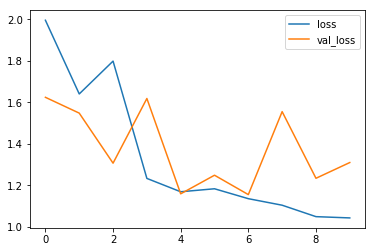

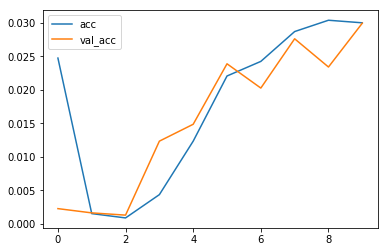

In [18]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot();

# Perform detection on image

In [43]:
model.load_weights("weights_2_classes.h5")

[<utils.BoundBox object at 0x00000000483C21D0>, <utils.BoundBox object at 0x00000000483A98D0>]


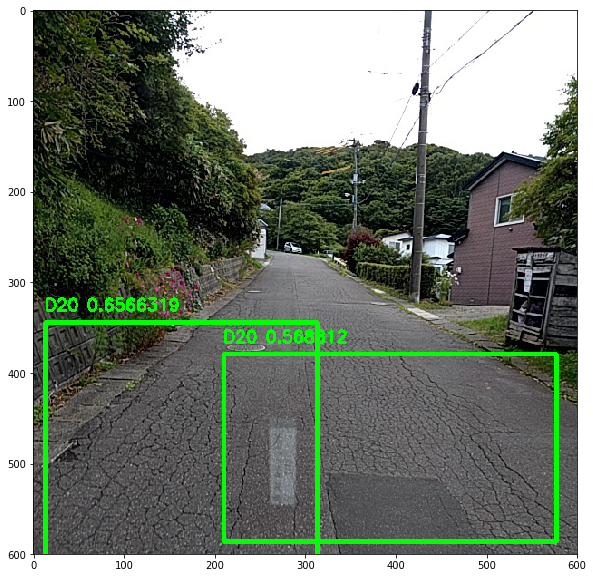

In [50]:
image = cv2.imread("RoadDamageDataset/Val_Images/Muroran_20170911092938.jpg")
#Nagakute_20170911105903.jpg
#Nagakute_20170911095719.jpg
#Muroran_20170906094653.jpg
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416)) #(416, 416)
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

#print(netout[0])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS,                       
                      nb_class=CLASS)
print(boxes)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()